In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance



PATH_CSV_MASTER = r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\master_fpPCA128_omics.csv"


# Load the dataset
df = pd.read_csv(PATH_CSV_MASTER)

In [ ]:
# Basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (178024, 346)

First 5 rows:
          drug_min                                           drug_max  \
0  (+)-bicuculline                                       temozolomide   
1          (+)-jq1                                         10356-76-0   
2          (+)-jq1                                       1088965-37-0   
3          (+)-jq1  2-methoxy-3,17beta-dihydroxyestra-1,3,5(10)-tr...   
4          (+)-jq1                                        200484-11-3   

  cell_line  synergy_zip  synergy_bliss  synergy_loewe  synergy_hsa  \
0      t98g       21.850         21.850          4.440        4.440   
1     u-ho1        3.590          1.960         -4.015        2.770   
2     u-ho1        0.265         -2.555         -8.925       -6.145   
3     u-ho1        9.560         11.430         -2.760        0.600   
4     u-ho1       23.675         23.475         -0.100       10.840   

                                             pair_id  synergy_mean  \
0                   

Most frequent cell lines:
Total unique cell lines: 81

Top 15 most frequent cell lines:
mcf7: 14060 occurrences
sw-620: 3825 occurrences
ncih23: 3812 occurrences
sk-ov-3: 3807 occurrences
ht29: 3800 occurrences
uacc62: 3777 occurrences
hct116: 3777 occurrences
nci-h460: 3759 occurrences
t-47d: 3756 occurrences
achn: 3517 occurrences
ovcar-5: 3517 occurrences
mda-mb-231: 3513 occurrences
sf-268: 3511 occurrences
hct-15: 3508 occurrences
uacc-257: 3508 occurrences


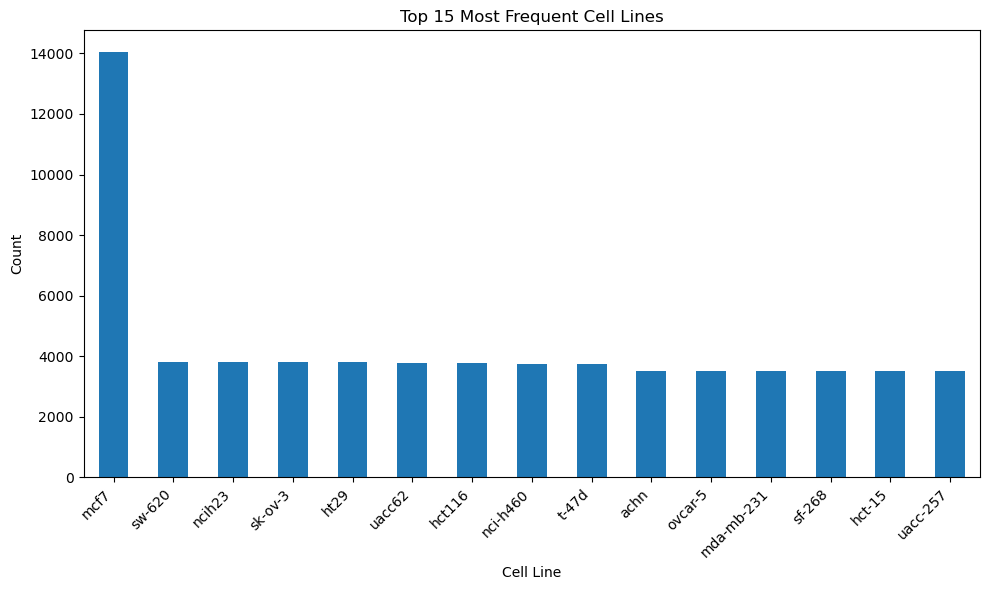


The top 15 cell lines represent 36.76% of the dataset


In [ ]:
print("Most frequent cell lines:")
cell_counts = df["cell_line"].value_counts()
print("Total unique cell lines:", len(cell_counts))

# Display the top 15 most frequent cell lines with their counts
top_15_cell_lines = cell_counts.head(15)
print("\nTop 15 most frequent cell lines:")
for cell_line, count in top_15_cell_lines.items():
    print(f"{cell_line}: {count} occurrences")

# Visualize the distribution
plt.figure(figsize=(10, 6))
top_15_cell_lines.plot(kind='bar')
plt.title('Top 15 Most Frequent Cell Lines')
plt.xlabel('Cell Line')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate percentage of dataset covered by top cell lines
total_samples = len(df)
top_15_coverage = top_15_cell_lines.sum() / total_samples * 100
print(f"\nThe top 15 cell lines represent {top_15_coverage:.2f}% of the dataset")

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
min_fp_pca_0      382
min_fp_pca_1      382
min_fp_pca_2      382
min_fp_pca_3      382
min_fp_pca_4      382
                 ... 
max_fp_pca_123    254
max_fp_pca_124    254
max_fp_pca_125    254
max_fp_pca_126    254
max_fp_pca_127    254
Length: 256, dtype: int64


In [ ]:
print("Antal NaN totalt:", df.isna().sum().sum())
print("Antal nollor totalt:", (df == 0).sum().sum())

# Jämför en specifik kolumn
col = "min_fp_pca_0"
print("NaN i", col, ":", df[col].isna().sum())
print("Nollor i", col, ":", (df[col] == 0).sum())

Antal NaN totalt: 81408
Antal nollor totalt: 174060
NaN i min_fp_pca_0 : 382
Nollor i min_fp_pca_0 : 0


In [ ]:
# mask för rader med NaN i fingerprint-PCA
fp_cols = [c for c in df.columns if c.startswith("min_fp_pca_") or c.startswith("max_fp_pca_")]
mask = df[fp_cols].isna().any(axis=1)

n_missing = mask.sum()
n_total   = len(df)
pct = 100 * n_missing / n_total

print(f"Totalt antal rader: {n_total}")
print(f"Rader utan fingerprints: {n_missing}")
print(f"Andel: {pct:.2f}%")

Totalt antal rader: 178024
Rader utan fingerprints: 615
Andel: 0.35%


In [ ]:
# vilka rader saknar FP-PCA?
mask = df[[c for c in df.columns if c.startswith("min_fp_pca_")]].isna().any(axis=1)
missing = df[mask]

print("Rader utan fingerprints:", len(missing))
print(missing[["drug_min", "drug_max", "cell_line"]].head())

Rader utan fingerprints: 382
                             drug_min      drug_max cell_line
125   (6-)e-<u+200b>aminocaproic acid   717906-29-1     a-673
126   (6-)e-<u+200b>aminocaproic acid   ruxolitinib    l-1236
127   (6-)e-<u+200b>aminocaproic acid  temozolomide      t98g
4894              16-16-dimethyl pge2     pf-431396     a-673
4895              16-16-dimethyl pge2   ruxolitinib    l-1236


In [ ]:
import os

fp_cols = [c for c in df.columns if c.startswith("min_fp_pca_") or c.startswith("max_fp_pca_")]

# mask för rader med NaN i fingerprints
mask_missing = df[fp_cols].isna().any(axis=1)

# subset med rader som ska bort
dropped_rows = df[mask_missing]

# summera vilka drugs som tappas
dropped_summary = (
    dropped_rows[["drug_min", "drug_max"]]
    .melt(value_name="drug")["drug"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "drug", "drug": "count"})
)

print(f"[INFO] Totalt droppade rader: {len(dropped_rows)} ({len(dropped_rows)/len(df)*100:.2f} %)")
print("[INFO] Exkluderade drugs:")
print(dropped_summary)

# spara lista över droppade drugs
out_path = os.path.join("C:/Users/46762/VSCODE/BIG_PHARMA/data/interim", "dropped_drugs.csv")
dropped_summary.to_csv(out_path, index=False)
print(f"[OK] Sparat lista över exkluderade drugs → {out_path}")

# droppa raderna från huvud-df
df = df[~mask_missing].reset_index(drop=True)
print(f"[OK] Ny dataset-shape: {df.shape}")

[INFO] Totalt droppade rader: 615 (0.35 %)
[INFO] Exkluderade drugs:
                                                 count  count
0                                             ak-77283    130
1                                             ak170455    108
2                                          717906-29-1     79
3    2-methoxy-3,17beta-dihydroxyestra-1,3,5(10)-tr...     67
4                                             ac1l2qk3     67
..                                                 ...    ...
193                                      zinc101112865      1
194                                      zinc101426918      1
195                                      zinc103939005      1
196                                       zinc11616261      1
197                             dinaciclib (sch727965)      1

[198 rows x 2 columns]
[OK] Sparat lista över exkluderade drugs → C:/Users/46762/VSCODE/BIG_PHARMA/data/interim\dropped_drugs.csv
[OK] Ny dataset-shape: (177409, 346)


In [ ]:
drop_cols = ["synergy_bliss", "synergy_loewe", "synergy_hsa"]

for col in drop_cols:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"[INFO] Droppade kolumn: {col}")

print(f"[OK] Dataset shape efter drop: {df.shape}")

[INFO] Droppade kolumn: synergy_bliss
[INFO] Droppade kolumn: synergy_loewe
[INFO] Droppade kolumn: synergy_hsa
[OK] Dataset shape efter drop: (177409, 343)


In [ ]:
print(df.describe().T.head(20))  # första features

corr = df.corr(numeric_only=True)["synergy_zip"].sort_values(ascending=False)
print(corr.head(15))
print(corr.tail(15))

                      count         mean          std        min          25%  \
synergy_zip        177409.0    -0.843841     6.056427 -36.846800    -4.300000   
synergy_mean       177409.0    -2.414808     6.319258 -46.431250    -5.292500   
synergy_std        177409.0     5.924942     6.829249   0.000000     2.019097   
cell_id            177409.0    62.604079    32.793004   2.000000    36.000000   
drug_min_id        177409.0  1061.725521   624.117583   0.000000   554.000000   
drug_max_id        177409.0  3239.484665  1321.835538  49.000000  2198.000000   
drug_min_freq      177409.0  4549.947776  1415.836854   1.000000  4020.000000   
drug_max_freq      177409.0  3581.976382  1886.329996   1.000000  2191.000000   
cell_freq          177409.0  4803.103811  1080.786034   5.000000  4973.000000   
drug_min_freq_log  177409.0     8.233352     1.035439   0.693147     8.299286   
drug_max_freq_log  177409.0     7.906157     1.063822   0.693147     7.692570   
cell_freq_log      177409.0 

In [ ]:
drop_target_derivatives = ["synergy_mean", "synergy_binary", "synergy_std"]

for col in drop_target_derivatives:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"[INFO] Droppade target-derivat: {col}")

print(f"[OK] Dataset shape efter drop: {df.shape}")

[INFO] Droppade target-derivat: synergy_mean
[INFO] Droppade target-derivat: synergy_binary
[INFO] Droppade target-derivat: synergy_std
[OK] Dataset shape efter drop: (177409, 340)


In [ ]:
df.describe().T.head(20)   # de första 20 features

count         mean          std        min          25%  \
synergy_zip        177409.0    -0.843841     6.056427 -36.846800    -4.300000   
cell_id            177409.0    62.604079    32.793004   2.000000    36.000000   
drug_min_id        177409.0  1061.725521   624.117583   0.000000   554.000000   
drug_max_id        177409.0  3239.484665  1321.835538  49.000000  2198.000000   
drug_min_freq      177409.0  4549.947776  1415.836854   1.000000  4020.000000   
drug_max_freq      177409.0  3581.976382  1886.329996   1.000000  2191.000000   
cell_freq          177409.0  4803.103811  1080.786034   5.000000  4973.000000   
drug_min_freq_log  177409.0     8.233352     1.035439   0.693147     8.299286   
drug_max_freq_log  177409.0     7.906157     1.063822   0.693147     7.692570   
cell_freq_log      177409.0     8.406780     0.500245   1.791759     8.511980   
min_fp_pca_0       177409.0    -0.611087     1.059278  -3.144477    -1.173092   
min_fp_pca_1       177409.0     0.050307     1.013307  -2.014875    -0.864356   
min_fp_pca_2       177409.0    -0.339383     1.033184  -2.159030    -1.279170   
min_fp_pca_3       177409.0    -0.328272     0.704486  -2.678634    -0.729996   
min_fp_pca_4       177409.0    -0.262998     0.695011  -2.131007    -0.714140   
min_fp_pca_5       177409.0     0.336943     1.094196  -1.963982    -0.413841   
min_fp_pca_6       177409.0     0.136731     0.997527  -1.966612    -0.729419   
min_fp_pca_7       177409.0    -0.023204     0.646721  -1.975915    -0.265465   
min_fp_pca_8       177409.0     0.124042     0.601531  -1.514925    -0.441799   
min_fp_pca_9       177409.0    -0.019374     0.549858  -2.010289    -0.403194   

                           50%          75%          max  
synergy_zip          -1.160000     1.760000    37.677040  
cell_id              60.000000    91.000000   122.000000  
drug_min_id        1030.000000  1657.000000  2247.000000  
drug_max_id        3129.000000  4315.000000  5349.000000  
drug_min_freq      4829.000000  5543.000000  6924.000000  
drug_max_freq      3732.000000  4891.000000  7980.000000  
cell_freq          5051.000000  5097.000000  5619.000000  
drug_min_freq_log     8.482602     8.620472     8.842893  
drug_max_freq_log     8.224967     8.495356     8.984819  
cell_freq_log         8.527539     8.536604     8.634087  
min_fp_pca_0         -0.828407     0.041265     2.597526  
min_fp_pca_1          0.132433     0.708380     2.827476  
min_fp_pca_2         -0.359263     0.284328     2.215087  
min_fp_pca_3         -0.344501     0.199318     2.137824  
min_fp_pca_4         -0.454027    -0.045349     2.813992  
min_fp_pca_5         -0.025701     0.823103     3.281504  
min_fp_pca_6         -0.001846     0.832229     2.586542  
min_fp_pca_7          0.097281     0.454161     2.061964  
min_fp_pca_8          0.069666     0.458056     2.262911  
min_fp_pca_9         -0.136472     0.271422     2.544025

synergy_zip              1.000000
sc_tissue_Lymphoid       0.189875
min_fp_pca_0             0.133732
sc_tissue_Bone           0.124521
min_fp_pca_51            0.107804
min_fp_pca_106           0.087916
min_fp_pca_47            0.087209
sc_tissue_Soft Tissue    0.087171
max_fp_pca_0             0.086999
min_fp_pca_60            0.085903
min_fp_pca_88            0.082373
min_fp_pca_11            0.080525
min_fp_pca_13            0.078982
max_fp_pca_121           0.078799
min_fp_pca_1             0.077444
Name: synergy_zip, dtype: float64
min_fp_pca_5        -0.070302
min_fp_pca_35       -0.070972
min_fp_pca_93       -0.073661
min_fp_pca_10       -0.074421
min_fp_pca_28       -0.075514
max_fp_pca_35       -0.076444
max_fp_pca_23       -0.077840
max_fp_pca_32       -0.078686
min_fp_pca_18       -0.082651
min_fp_pca_7        -0.121649
drug_max_freq_log   -0.160407
cell_freq_log       -0.163152
cell_freq           -0.194213
drug_min_freq       -0.226165
drug_min_freq_log   -0.279780
Name: 

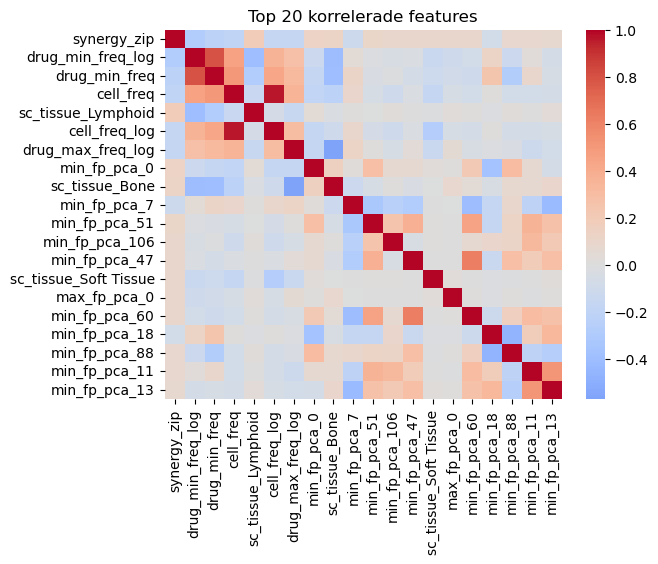

In [ ]:
corr = df.corr(numeric_only=True)["synergy_zip"].sort_values(ascending=False)
print(corr.head(15))
print(corr.tail(15))

top_feats = corr.abs().sort_values(ascending=False).head(20).index
sns.heatmap(df[top_feats].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Top 20 korrelerade features")
plt.show()

### Correlation Analysis — Key Insights
- **Tissue features (`sc_tissue_*`)**: Show the strongest positive correlations with `synergy_zip` (up to ~0.19). This suggests biological relevance — synergy levels differ across tissue types.
- **Fingerprint PCA components (`min_fp_pca_*`, `max_fp_pca_*`)**: Individually weakly correlated (~0.08–0.13), but collectively important. They capture chemical structure information.
- **Frequency features (`drug_min_freq`, `cell_freq`, etc.)**: Negatively correlated (-0.16 to -0.23). This reflects dataset bias — common drugs/cell lines tend to show lower synergy.
- **No single strong driver (>0.2)**: Synergy is multi-factorial and likely requires combining fingerprints, omics, and tissue features for predictive modeling.

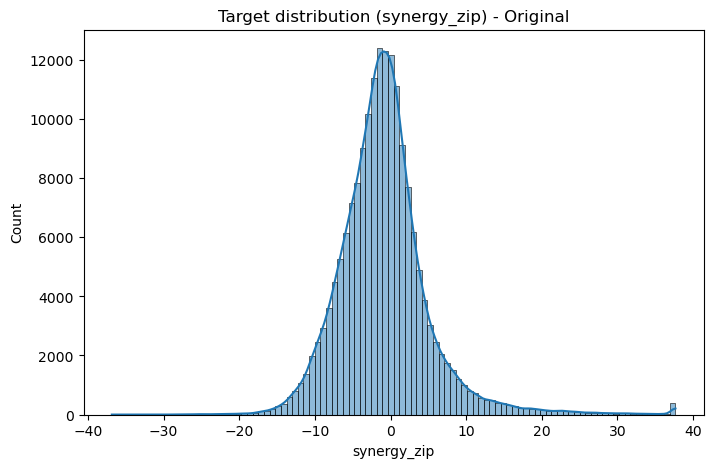

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["synergy_zip"], bins=100, kde=True)
plt.title("Target distribution (synergy_zip) - Original")
plt.xlabel("synergy_zip")
plt.ylabel("Count")
plt.show()

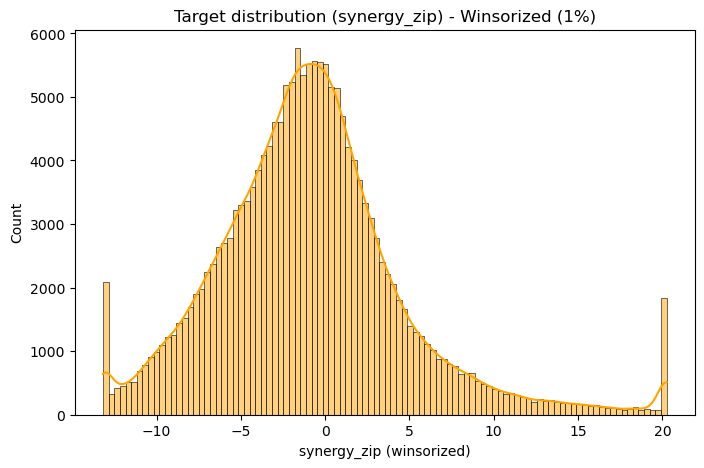

In [ ]:
from scipy.stats.mstats import winsorize

# Winsorize at 1% tails (kan justeras, ex. 0.5%)
winsor_target = winsorize(df["synergy_zip"], limits=[0.01, 0.01])

plt.figure(figsize=(8,5))
sns.histplot(winsor_target, bins=100, kde=True, color="orange")
plt.title("Target distribution (synergy_zip) - Winsorized (1%)")
plt.xlabel("synergy_zip (winsorized)")
plt.ylabel("Count")
plt.show()

### Winsorization of Target Distribution
- **Without winsorization**: The target (`synergy_zip`) shows a sharp peak around 0 but with very long tails (outliers up to ±35–40).
These extreme values can dominate loss functions like MSE and make training unstable.
- **With winsorization (1%)**: The outer 1% of values are clipped, resulting in a more balanced distribution with shorter tails.
This reduces the influence of extreme outliers and often stabilizes model training.
- **Trade-off**: Winsorization improves robustness and generalization but removes information about the most extreme synergy cases.
It is useful for modeling, but important biological outliers may be lost.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# --- parametrar ---
SUBSAMPLE_SIZE = 30_000    # justera vid behov
VAL_SIZE = 0.20
MAX_BINS = 5               # börja med 5 kvantiler, minskar vid behov
MIN_PER_CLASS = 2
RANDOM_SEED = 42

# --- förbered data ---
feat_cols = [c for c in df.columns if (
    c.startswith("min_fp_pca_") or
    c.startswith("max_fp_pca_") or
    c.startswith("sc_rna_latent") or
    c.startswith("sc_tissue_") or
    ("freq" in c)
)]
work = df.dropna(subset=feat_cols + ["synergy_zip"]).copy()

strat_cell_col = "cell_line" if "cell_line" in work.columns else ("cell_id" if "cell_id" in work.columns else None)
if strat_cell_col is None:
    work["__cell_fallback__"] = "all"
    strat_cell_col = "__cell_fallback__"

def try_make_splits(work, n_bins):
    # Binna target
    work = work.copy()
    work["synergy_bin"] = pd.qcut(work["synergy_zip"], q=n_bins, labels=False, duplicates="drop")
    # Strat-nyckel
    strat_key = work[strat_cell_col].astype(str) + "|" + work["synergy_bin"].astype(str)

    # 1) Filtrera bort små klasser (<2)
    counts = strat_key.value_counts()
    keep_keys = counts[counts >= MIN_PER_CLASS].index
    kept = strat_key.isin(keep_keys)
    work2 = work.loc[kept].copy()
    strat_key2 = strat_key.loc[kept]

    # Måste fortfarande ha minst 2 per klass efter split → kontrollera train_size vs #klasser
    n_classes = strat_key2.nunique()
    train_size = int((1 - VAL_SIZE) * len(work2))
    if train_size < n_classes:
        return None  # signalera att detta n_bins inte fungerar

    # 2) Global train/val-split med stratifiering
    tr_idx, va_idx = train_test_split(
        work2.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=strat_key2
    )
    train_df = work2.loc[tr_idx].copy()
    val_df   = work2.loc[va_idx].copy()

    # 3) Subsample av train (stratifierat). Om klasser blir för små, fallback till stratifiering på endast synergy_bin.
    sub_size = min(SUBSAMPLE_SIZE, len(train_df))
    sub_key = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))

    # Filtrera igen ifall någon klass blev 1 efter split
    sub_counts = sub_key.value_counts()
    sub_keep = sub_key.isin(sub_counts[sub_counts >= MIN_PER_CLASS].index)
    train_df = train_df.loc[sub_keep].copy()
    sub_key  = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))
    n_classes_sub = sub_key.nunique()

    # Om klasserna fortfarande för många i förhållande till sub_size → försök synergy-bin-stratifiering
    if sub_size < n_classes_sub:
        # Fallback: stratifiera bara på target-bins, men behåll cell-fördelningen hyfsad genom stort sample
        sss = StratifiedShuffleSplit(n_splits=1, train_size=sub_size, random_state=RANDOM_SEED)
        for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
            sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)
    else:
        sub_df, _ = train_test_split(
            train_df,
            train_size=sub_size,
            random_state=RANDOM_SEED,
            stratify=sub_key
        )
        sub_df = sub_df.reset_index(drop=True)

    return sub_df, val_df, n_bins, work2

# Försök med MAX_BINS → minska tills det fungerar
result = None
for nb in range(MAX_BINS, 1, -1):
    result = try_make_splits(work, nb)
    if result is not None:
        sub_df, val_df, used_bins, filtered_work = result
        print(f"[INFO] Strat OK med n_bins={used_bins} | train_sub={len(sub_df):,} | val={len(val_df):,} | efter filtrering: {len(filtered_work):,}")
        break

if result is None:
    # Sista fallback: stratifiera endast på target-bins, ignorera cell i stratifiering
    print("[WARN] Kunde inte stratifiera på cell|bin. Fallback: endast target-bins.")
    work["synergy_bin"] = pd.qcut(work["synergy_zip"], q=3, labels=False, duplicates="drop")
    tr_idx, va_idx = train_test_split(
        work.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=work["synergy_bin"]
    )
    train_df = work.loc[tr_idx].copy()
    val_df   = work.loc[va_idx].copy()

    sss = StratifiedShuffleSplit(n_splits=1, train_size=min(SUBSAMPLE_SIZE, len(train_df)), random_state=RANDOM_SEED)
    for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
        sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)

print(f"[OK] Train SUB shape: {sub_df.shape} | VAL shape: {val_df.shape}")

# Packa matriser för efterföljande celler
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

[INFO] Strat OK med n_bins=5 | train_sub=30,000 | val=35,481 | efter filtrering: 177,405
[OK] Train SUB shape: (30000, 341) | VAL shape: (35481, 341)


In [ ]:
import pandas as pd

# avgör cell-kolumn
cell_col = "cell_line" if "cell_line" in sub_df.columns else ("cell_id" if "cell_id" in sub_df.columns else None)

def show_dist(title, frame):
    print(f"\n=== {title} ===")
    # synergy bins
    if "synergy_bin" in frame.columns:
        print("[synergy_bin] dist (%):")
        print((frame["synergy_bin"].value_counts(normalize=True).sort_index() * 100).round(2))
    else:
        print("[WARN] 'synergy_bin' saknas i ramen.")
    # cell dist
    if cell_col is not None:
        print("\n[Cell] top-15 dist (%):")
        print((frame[cell_col].value_counts(normalize=True).head(15) * 100).round(2))
    else:
        print("[INFO] Ingen cell-kolumn hittad (cell_line/cell_id).")

    # kors-tabell cell x bin (top-10 celler för översikt)
    if cell_col is not None and "synergy_bin" in frame.columns:
        top_cells = frame[cell_col].value_counts().head(10).index
        ctab = (frame[frame[cell_col].isin(top_cells)]
                .pivot_table(index=cell_col, columns="synergy_bin", aggfunc="size", fill_value=0))
        ctab_pct = (ctab.div(ctab.sum(axis=1), axis=0) * 100).round(1)
        print("\n[Cell x synergy_bin] (%) för topp-10 celler:")
        display(ctab_pct)

show_dist("SUBSAMPLE (train)", sub_df)
show_dist("VALIDATION (val)", val_df)

print(f"\n[INFO] Shapes → sub_df: {sub_df.shape} | val_df: {val_df.shape}")


=== SUBSAMPLE (train) ===
[synergy_bin] dist (%):
synergy_bin
0    20.02
1    20.01
2    20.07
3    19.93
4    19.98
Name: proportion, dtype: float64

[Cell] top-15 dist (%):
cell_line
mcf7          7.93
sw-620        2.15
ncih23        2.15
sk-ov-3       2.14
ht29          2.14
hct116        2.13
uacc62        2.13
nci-h460      2.12
t-47d         2.11
achn          1.98
ovcar-5       1.98
sk-mel-28     1.98
mda-mb-231    1.98
sf-268        1.98
uacc-257      1.98
Name: proportion, dtype: float64

[Cell x synergy_bin] (%) för topp-10 celler:


synergy_bin     0     1     2     3     4
cell_line                                
achn         18.7  21.5  23.0  20.8  16.0
hct116       14.4  20.0  21.6  21.6  22.4
ht29         15.9  15.7  18.7  24.3  25.5
mcf7         25.7  19.7  20.1  18.9  15.6
nci-h460     10.7  17.5  21.1  28.3  22.5
ncih23       20.3  22.8  23.1  20.3  13.4
sk-ov-3      16.8  23.5  21.0  20.8  17.9
sw-620       18.0  17.6  20.7  22.8  20.9
t-47d        21.6  20.7  20.5  19.4  17.8
uacc62       24.6  22.1  23.8  16.6  12.9


=== VALIDATION (val) ===
[synergy_bin] dist (%):
synergy_bin
0    20.01
1    20.00
2    20.07
3    19.93
4    19.99
Name: proportion, dtype: float64

[Cell] top-15 dist (%):
cell_line
mcf7          7.92
sw-620        2.16
ncih23        2.15
sk-ov-3       2.14
ht29          2.14
uacc62        2.13
hct116        2.13
nci-h460      2.12
t-47d         2.12
achn          1.98
hct-15        1.98
ovcar-5       1.98
sf-268        1.98
mda-mb-231    1.98
uacc-257      1.98
Name: proportion, dtype: float64

[Cell x synergy_bin] (%) för topp-10 celler:


synergy_bin     0     1     2     3     4
cell_line                                
achn         18.6  21.4  23.0  20.9  16.1
hct116       14.3  20.1  21.6  21.6  22.5
ht29         15.8  15.8  18.7  24.3  25.4
mcf7         25.8  19.7  20.1  18.9  15.5
nci-h460     10.8  17.4  21.0  28.3  22.5
ncih23       20.3  22.8  23.2  20.3  13.4
sk-ov-3      16.8  23.5  21.0  20.8  17.9
sw-620       18.0  17.6  20.8  22.6  20.9
t-47d        21.7  20.6  20.5  19.4  17.8
uacc62       24.6  22.0  23.8  16.7  13.0


[INFO] Shapes → sub_df: (30000, 341) | val_df: (35481, 341)


[HistGBR] Val MAE=3.391 | RMSE=4.822 | R2=0.365 | r=0.605


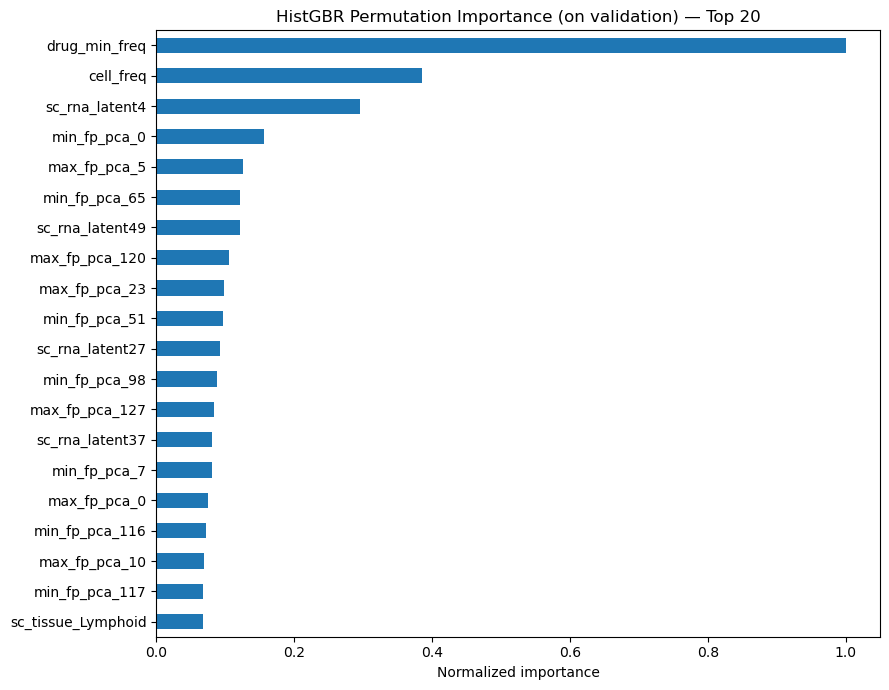

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Bygg matriser (om du inte redan har dem från tidigare cell)
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3,
    random_state=42
)
hgb.fit(X_sub, y_sub)

pred_val = hgb.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val)
rmse = float(np.sqrt(np.mean((y_val - pred_val)**2)))
r2   = r2_score(y_val, pred_val)
r    = float(np.corrcoef(y_val, pred_val)[0,1])
print(f"[HistGBR] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# Permutation importance på VAL (mer ärlig bild)
perm = permutation_importance(hgb, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1)
imp_hgb_perm = pd.Series(perm.importances_mean, index=feat_cols).clip(lower=0)
imp_hgb_perm_n = imp_hgb_perm / (imp_hgb_perm.max() + 1e-12)

topN = 20
top_feats_hgb = imp_hgb_perm_n.sort_values(ascending=False).head(topN)

plt.figure(figsize=(9, 7))
top_feats_hgb.iloc[::-1].plot(kind="barh")
plt.title("HistGBR Permutation Importance (on validation) — Top 20")
plt.xlabel("Normalized importance")
plt.tight_layout()
plt.show()

# spara artefakter för RF-jämförelse
_hist_importance_val_norm = imp_hgb_perm_n

[RandomForest] Val MAE=3.329 | RMSE=4.774 | R2=0.377 | r=0.617


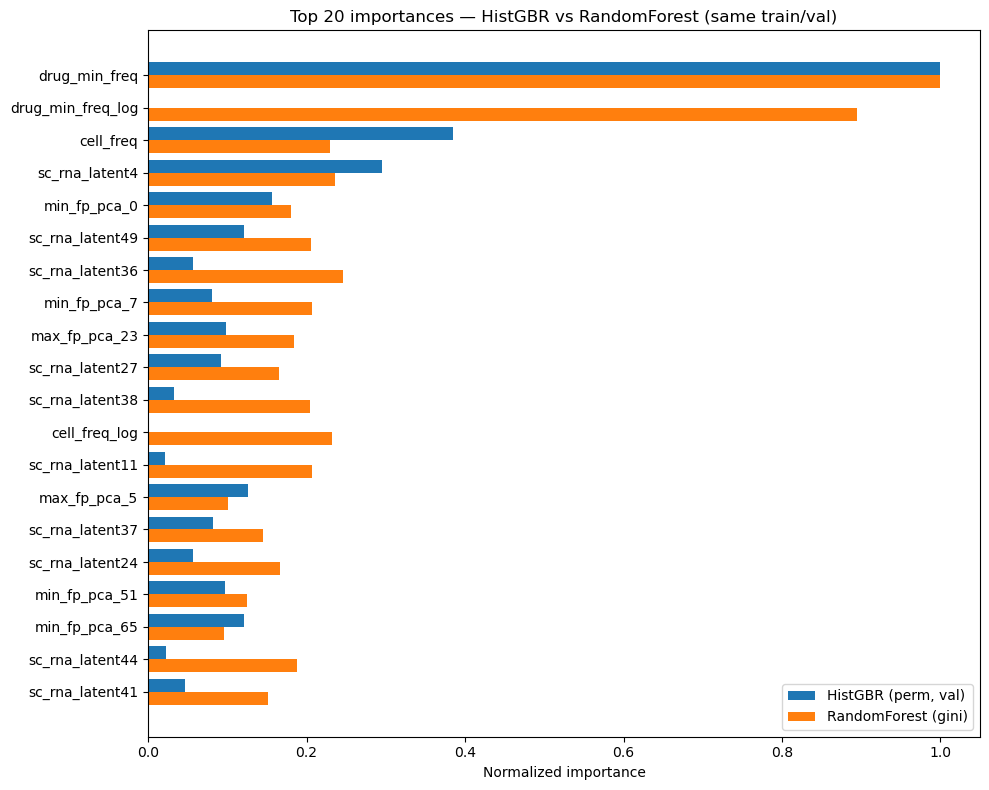

HistGBR (perm, val)  RandomForest (gini)       Avg
Feature                                                              
drug_min_freq                 1.000000             1.000000  1.000000
drug_min_freq_log             0.000000             0.894988  0.447494
cell_freq                     0.385343             0.229724  0.307533
sc_rna_latent4                0.294989             0.236307  0.265648
min_fp_pca_0                  0.155883             0.180097  0.167990
sc_rna_latent49               0.120955             0.205208  0.163081
sc_rna_latent36               0.056340             0.245457  0.150898
min_fp_pca_7                  0.081111             0.206136  0.143624
max_fp_pca_23                 0.097649             0.184239  0.140944
sc_rna_latent27               0.092228             0.164921  0.128575
sc_rna_latent38               0.031963             0.204187  0.118075
cell_freq_log                 0.000000             0.231478  0.115739
sc_rna_latent11               0.021112             0.206635  0.113874
max_fp_pca_5                  0.125950             0.101189  0.113570
sc_rna_latent37               0.081158             0.144312  0.112735
sc_rna_latent24               0.057100             0.166320  0.111710
min_fp_pca_51                 0.096732             0.124187  0.110459
min_fp_pca_65                 0.121484             0.096149  0.108816
sc_rna_latent44               0.021971             0.187290  0.104630
sc_rna_latent41               0.046871             0.151508  0.099190

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rf = RandomForestRegressor(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)
rf.fit(X_sub, y_sub)

pred_val_rf = rf.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val_rf)
rmse = float(np.sqrt(np.mean((y_val - pred_val_rf)**2)))
r2   = r2_score(y_val, pred_val_rf)
r    = float(np.corrcoef(y_val, pred_val_rf)[0,1])
print(f"[RandomForest] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# RF-importance (Gini/split)
imp_rf_gini = pd.Series(rf.feature_importances_, index=feat_cols).clip(lower=0)
imp_rf_gini_n = imp_rf_gini / (imp_rf_gini.max() + 1e-12)

# Sida-vid-sida mot HistGBR-permutation
avg_rank = (_hist_importance_val_norm + imp_rf_gini_n) / 2.0
topN = 20
top_feats = avg_rank.sort_values(ascending=False).head(topN).index.tolist()

plot_df = pd.DataFrame({
    "Feature": top_feats,
    "HistGBR (perm, val)": _hist_importance_val_norm[top_feats].values,
    "RandomForest (gini)": imp_rf_gini_n[top_feats].values
}).set_index("Feature")

plt.figure(figsize=(10, 8))
ys = np.arange(len(top_feats))
bar_w = 0.4
plt.barh(ys - bar_w/2, plot_df["HistGBR (perm, val)"], height=bar_w, label="HistGBR (perm, val)")
plt.barh(ys + bar_w/2, plot_df["RandomForest (gini)"], height=bar_w, label="RandomForest (gini)")
plt.yticks(ys, top_feats)
plt.xlabel("Normalized importance")
plt.title("Top 20 importances — HistGBR vs RandomForest (same train/val)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# tabell
cmp_table = plot_df.copy()
cmp_table["Avg"] = (cmp_table.iloc[:,0] + cmp_table.iloc[:,1]) / 2.0
display(cmp_table.sort_values("Avg", ascending=False))

c:\Users\46762\VSCODE\conda\envs\tf-2.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CPU UMAP:   0%|          | 0/4 [00:00<?, ?step/s]c:\Users\46762\VSCODE\conda\envs\tf-2.10\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
CPU UMAP:  75%|███████▌  | 3/4 [01:25<00:21, 21.39s/step, saved embeddings]

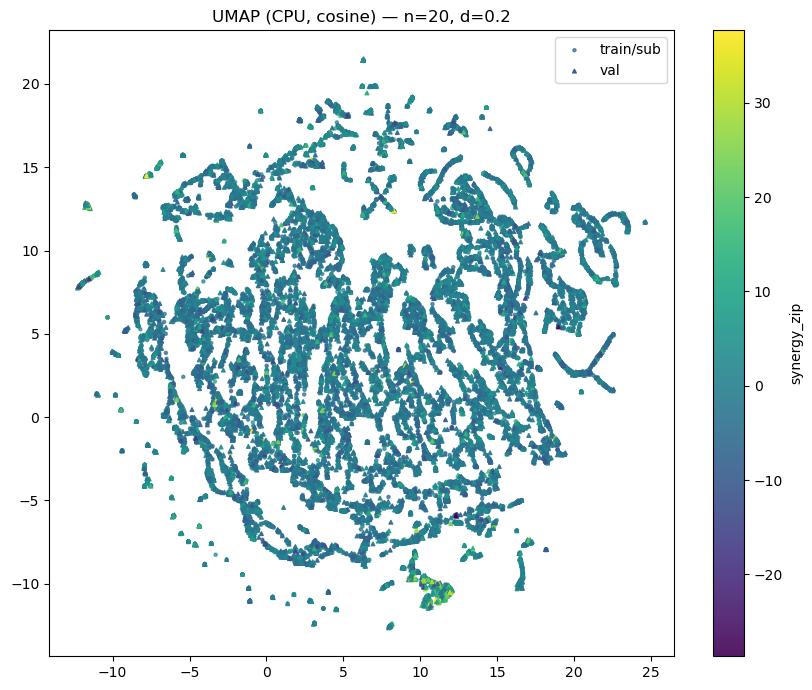

CPU UMAP: 100%|██████████| 4/4 [01:27<00:00, 21.75s/step, plotted]         


[OK] Embeddings: C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\umap_single_cpu\umap_cpu_cosine_n20_d0.20_embeddings.csv
[OK] Figure:     C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\umap_single_cpu\umap_cpu_cosine_n20_d0.20.png
[INFO] Elapsed:  87.0s
[Trustworthiness] train=0.969 | val=0.970


In [ ]:
# Requirements: umap-learn, tqdm, matplotlib, scikit-learn (optional for trustworthiness)
# Uses: sub_df, val_df, feat_cols

import os, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    from umap import UMAP
except ImportError as e:
    raise ImportError("Please install umap-learn first: pip install umap-learn") from e

# (Optional) metrics
try:
    from sklearn.manifold import trustworthiness
    HAS_TRUST = True
except Exception:
    HAS_TRUST = False

# -------------------- CONFIG --------------------
OUT_DIR = Path(r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\umap_single_cpu")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
N_NEIGHBORS = 20
MIN_DIST    = 0.20
METRIC      = "cosine"   # "cosine" | "euclidean" | "correlation" (via numba)
CMAP        = "viridis"
PLOT_SAMPLE = 30000      # cap points for lighter PNGs

# -------------------- DATA ----------------------
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)

y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

# -------------------- UMAP (CPU) ----------------
pbar = tqdm(total=4, desc="CPU UMAP", unit="step")
t0 = time.perf_counter()

# 1) Fit on train/subsample only
umap_model = UMAP(
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    n_components=2,
    metric=METRIC,
    random_state=RANDOM_STATE,
    low_memory=True,   # helps on larger datasets
    verbose=False      # tqdm will be our progress indicator
)
Z_sub = umap_model.fit_transform(X_sub)
pbar.set_postfix_str("fit done")
pbar.update(1)

# 2) Transform validation
Z_val = umap_model.transform(X_val)
pbar.set_postfix_str("transform done")
pbar.update(1)

# 3) Save embeddings
emb_train = pd.DataFrame(Z_sub, columns=["z1","z2"], dtype=np.float32)
emb_train["split"] = "train"
emb_train["synergy_zip"] = y_sub

emb_val = pd.DataFrame(Z_val, columns=["z1","z2"], dtype=np.float32)
emb_val["split"] = "val"
emb_val["synergy_zip"] = y_val

embs = pd.concat([emb_train, emb_val], ignore_index=True)
emb_path = OUT_DIR / f"umap_cpu_{METRIC}_n{N_NEIGHBORS}_d{MIN_DIST:.2f}_embeddings.csv"
embs.to_csv(emb_path, index=False)
pbar.set_postfix_str("saved embeddings")
pbar.update(1)

# 4) Plot (train + val) colored by synergy_zip
rng = np.random.RandomState(0)
idx_tr = rng.choice(len(Z_sub), size=min(PLOT_SAMPLE//2, len(Z_sub)), replace=False)
idx_va = rng.choice(len(Z_val), size=min(PLOT_SAMPLE//2, len(Z_val)), replace=False)

plt.figure(figsize=(8.5, 7))
plt.scatter(Z_sub[idx_tr,0], Z_sub[idx_tr,1], c=y_sub[idx_tr], s=5, alpha=0.7, cmap=CMAP, label="train/sub")
plt.scatter(Z_val[idx_va,0], Z_val[idx_va,1], c=y_val[idx_va], s=7, alpha=0.9, cmap=CMAP, marker="^", label="val")
plt.title(f"UMAP (CPU, {METRIC}) — n={N_NEIGHBORS}, d={MIN_DIST}")
cbar = plt.colorbar(); cbar.set_label("synergy_zip")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
fig_path = OUT_DIR / f"umap_cpu_{METRIC}_n{N_NEIGHBORS}_d{MIN_DIST:.2f}.png"
plt.savefig(fig_path, dpi=160)
plt.show()
pbar.set_postfix_str("plotted")
pbar.update(1)

pbar.close()
t1 = time.perf_counter()
print(f"[OK] Embeddings: {emb_path}")
print(f"[OK] Figure:     {fig_path}")
print(f"[INFO] Elapsed:  {t1 - t0:.1f}s")

# -------------------- OPTIONAL: quick trustworthiness --------------------
if HAS_TRUST:
    try:
        trust_tr  = float(trustworthiness(X_sub, Z_sub, n_neighbors=15, metric="euclidean"))
        trust_val = float(trustworthiness(X_val, Z_val, n_neighbors=15, metric="euclidean"))
        print(f"[Trustworthiness] train={trust_tr:.3f} | val={trust_val:.3f}")
    except Exception as e:
        print(f"[WARN] Trustworthiness failed: {e}")
else:
    print("[NOTE] Install scikit-learn to compute trustworthiness (optional).")

In [ ]:
# Example: top 1% high synergy
top = val_df[val_df["synergy_zip"] > np.percentile(val_df["synergy_zip"], 99)]
print(top[["drug_min", "drug_max", "cell_id", "synergy_zip"]].head(20))

                          drug_min              drug_max  cell_id  synergy_zip
104582                  carmustine           methoxsalen       30     20.33000
68194                    as-604850          temozolomide      108     24.76000
9803                   451492-95-8       ncgc00263265-01      113     22.55000
25694         abt-263 (navitoclax)          camptothecin      113     24.39000
28389                actinomycin d     emcyt (pharmacia)       68     25.73000
98329                  cabazitaxel   vincristine sulfate       68     28.37000
147260  daunorubicin hydrochloride     tamoxifen citrate       87     20.62000
142930                   dasatinib               mk-8776        6     23.93000
160259           emcyt (pharmacia)            nsc-127716       93     20.46000
52351               anagrelide hcl          temozolomide      108     26.14000
26746                      abt-888          temozolomide       13     24.90250
127531                  crenolanib                 s

In [ ]:
md = f"""
## UMAP Embedding Results

För att undersöka den latenta strukturen i features (fingerprint-PCA, RNA-latenter, frekvensvariabler) användes **UMAP** med följande parametrar:

- **n_neighbors** = 20  
- **min_dist** = 0.20  
- **metric** = cosine  

Resultaten visar en 2D-projektion av drug-combinationer, färglagda efter deras `synergy_zip`-score.

![UMAP embedding](4a6def58-67dd-496e-9859-74e0f7a98d77.png)

### Trustworthiness

För att utvärdera embeddingens kvalitet beräknades **trustworthiness**, vilket mäter hur väl lokala grannar i det högdimensionella rummet bevaras i 2D:

| Dataset        | Trustworthiness |
|----------------|-----------------|
| Train/Subsample | **0.969** |
| Validation      | **0.970** |

> **Tolkning:** Värden nära 1.0 innebär mycket hög kvalitet. Här visar både train och val att UMAP bevarar de lokala relationerna väl, vilket betyder att strukturen i 2D kan tolkas med hög tillförlitlighet.

### Nästa steg

- Utför **KMeans eller HDBSCAN** på UMAP-embeddingarna för att identifiera kluster.  
- Analysera medelvärden av `synergy_zip` inom kluster för att se om vissa grupper tenderar mot högre/lägre synergieffekter.  
- Visualisera med färgkodning efter cellinje eller specifika drugs för att upptäcka biologiskt relevanta mönster.
"""

print(md)


## UMAP Embedding Results

För att undersöka den latenta strukturen i features (fingerprint-PCA, RNA-latenter, frekvensvariabler) användes **UMAP** med följande parametrar:

- **n_neighbors** = 20  
- **min_dist** = 0.20  
- **metric** = cosine  

Resultaten visar en 2D-projektion av drug-combinationer, färglagda efter deras `synergy_zip`-score.

![UMAP embedding](4a6def58-67dd-496e-9859-74e0f7a98d77.png)

### Trustworthiness

För att utvärdera embeddingens kvalitet beräknades **trustworthiness**, vilket mäter hur väl lokala grannar i det högdimensionella rummet bevaras i 2D:

| Dataset        | Trustworthiness |
|----------------|-----------------|
| Train/Subsample | **0.969** |
| Validation      | **0.970** |

> **Tolkning:** Värden nära 1.0 innebär mycket hög kvalitet. Här visar både train och val att UMAP bevarar de lokala relationerna väl, vilket betyder att strukturen i 2D kan tolkas med hög tillförlitlighet.

### Nästa steg

- Utför **KMeans eller HDBSCAN** på UMAP-embeddingar

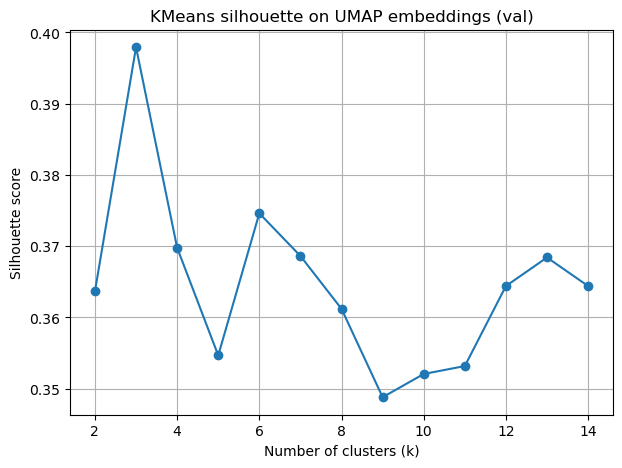

[KMeans] Best silhouette=0.398 at k=3


In [ ]:
# Requirements: scikit-learn, matplotlib, pandas, numpy
# Assumes you already have Z_val (numpy array of shape [n_samples, 2])
# and val_df with synergy_zip, synergy_bin etc.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------- CONFIG --------------------
K_RANGE = range(2, 15)   # test k = 2..14
RANDOM_STATE = 42

# -------------------- DATA ----------------------
# If you saved embs.csv earlier, load instead:
# embs = pd.read_csv(".../umap_cpu_cosine_n20_d0.20_embeddings.csv")
# Z_val = embs[embs["split"]=="val"][["z1","z2"]].to_numpy()
# y_val = embs[embs["split"]=="val"]["synergy_zip"].to_numpy()

Z_val = Z_val  # from your earlier UMAP cell
y_val = val_df["synergy_zip"].to_numpy()

# -------------------- LOOP OVER k ----------------
sil_scores = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(Z_val)
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(Z_val, labels)
        sil_scores.append(sil)
    else:
        sil_scores.append(np.nan)

# -------------------- PLOT -----------------------
plt.figure(figsize=(7,5))
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.title("KMeans silhouette on UMAP embeddings (val)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

# -------------------- BEST k ---------------------
best_k = K_RANGE[int(np.nanargmax(sil_scores))]
best_sil = np.nanmax(sil_scores)
print(f"[KMeans] Best silhouette={best_sil:.3f} at k={best_k}")

[INFO] Top 1.0% synergy threshold: 20.25
[INFO] 357 / 35481 validation points selected.

% of top synergy points per cluster:
cluster
2    42.86
0    39.78
1    17.37
Name: proportion, dtype: float64


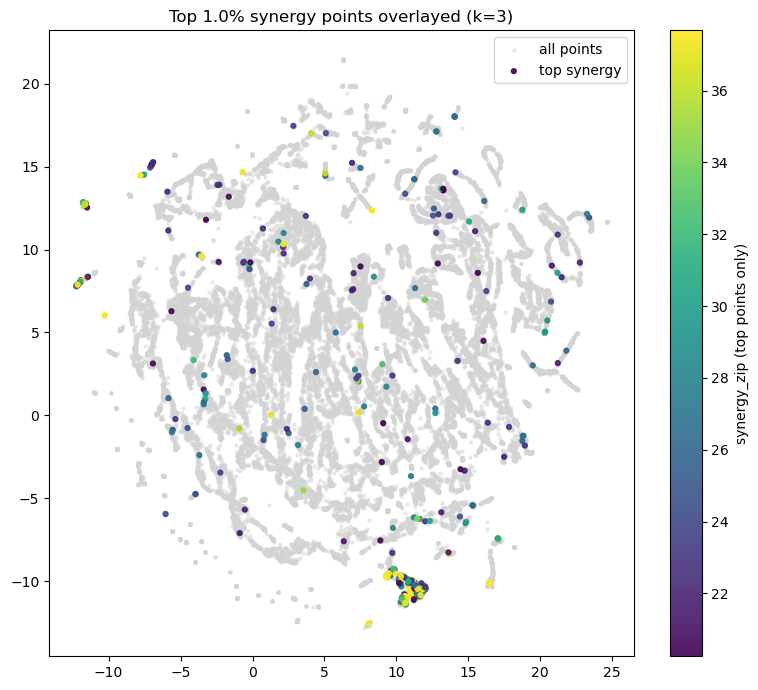


Cluster-level summary of top synergy points:
         count       mean   median       max
cluster                                     
0          142  28.910393  26.9750  37.67704
2          153  28.859397  27.6400  37.67704
1           62  25.237937  24.2025  37.67704


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -------------------- CONFIG --------------------
TOP_Q = 99   # take top 1% synergy
BEST_K = 3   # from silhouette analysis

# -------------------- LOAD DATA -----------------
# If you already have embeddings in memory:
# Z_val = ... (numpy array, shape [n_val, 2])
# y_val = val_df["synergy_zip"].to_numpy()

# Cluster with chosen k
km = KMeans(n_clusters=BEST_K, n_init=10, random_state=42)
labels = km.fit_predict(Z_val)

# Attach cluster labels to val_df for analysis
val_df_ = val_df.copy()
val_df_["cluster"] = labels
val_df_["z1"] = Z_val[:,0]
val_df_["z2"] = Z_val[:,1]

# -------------------- TOP SYNERGY -----------------
thr = np.percentile(y_val, TOP_Q)
top_synergy = val_df_[val_df_["synergy_zip"] >= thr]

print(f"[INFO] Top {100-TOP_Q:.1f}% synergy threshold: {thr:.2f}")
print(f"[INFO] {len(top_synergy)} / {len(val_df_)} validation points selected.")

# Show which clusters contain the most high-synergy points
cluster_counts = top_synergy["cluster"].value_counts(normalize=True) * 100
print("\n% of top synergy points per cluster:")
print(cluster_counts.round(2))

# -------------------- VISUALIZE -----------------
plt.figure(figsize=(8,7))
plt.scatter(val_df_["z1"], val_df_["z2"], c="lightgray", s=5, alpha=0.4, label="all points")
plt.scatter(top_synergy["z1"], top_synergy["z2"], c=top_synergy["synergy_zip"],
            cmap="viridis", s=12, alpha=0.9, label="top synergy")
plt.colorbar(label="synergy_zip (top points only)")
plt.title(f"Top {100-TOP_Q:.1f}% synergy points overlayed (k={BEST_K})")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# -------------------- SUMMARY TABLE -----------------
summary = (
    top_synergy.groupby("cluster")["synergy_zip"]
    .agg(["count","mean","median","max"])
    .sort_values("mean", ascending=False)
)
print("\nCluster-level summary of top synergy points:")
print(summary)

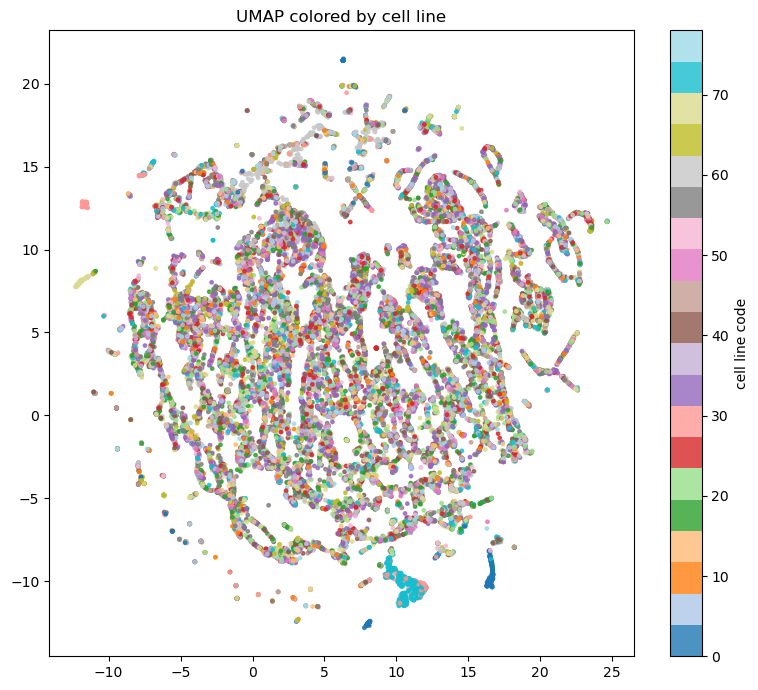

Two significant clusters identified to the south, rest of celline evenly clustered


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
scatter = plt.scatter(val_df_["z1"], val_df_["z2"], 
                      c=val_df_[cell_col].astype("category").cat.codes, 
                      cmap="tab20", s=6, alpha=0.8)
plt.title("UMAP colored by cell line")
plt.colorbar(scatter, label="cell line code")
plt.tight_layout()
plt.show()
print("Two significant clusters identified to the south, rest of celline evenly clustered")

[INFO] DBSCAN islands found: 52 (label -1 is noise)

=== Island summary (sorted by mean synergy then size) ===
 island  count  mean_synergy  median_synergy  max_synergy top_cell  top_cell_share  frac_top5%_global
     20    175      9.357171        6.980000     37.67704     t98g        0.817143           0.468571
     19    211      8.942809        5.560000     37.67704   l-1236        1.000000           0.383886
     17    650      8.025354        6.599000     37.67704    tc-71        0.393846           0.393846
     27    120      7.094347        5.496250     37.67704   l-1236        0.350000           0.383333
     45     26      5.581731        4.778750     24.90250     dld1        0.115385           0.153846
     44     25      4.711700        3.845000     16.29500     kpl1        0.160000           0.200000
     23    130      4.114582        3.810167     37.67704    a-673        0.153846           0.200000
     16     91      3.280055        2.192500     36.05000    sw837       

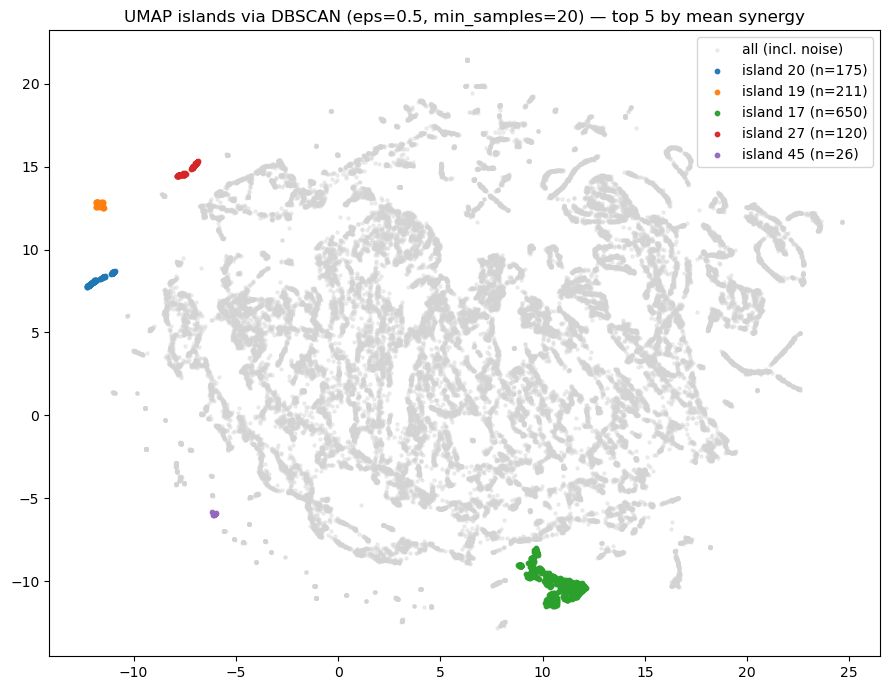


--- Island 20 (n=175) ---
mean       9.357171
median     6.980000
max       37.677040
Name: synergy_zip, dtype: float64

Top cell lines (%):
cell_line
t98g       81.71
l-428       3.43
hdlm-2      2.86
a2780       1.71
ov90        1.14
a2058       1.14
rd          1.14
sms-ctr     1.14
u-ho1       0.57
uwb1289     0.57
Name: proportion, dtype: float64

Top 10 drug pairs (count):
dexamethasone / temozolomide                   6
etoposide / temozolomide                       5
dexamethasone / zolinza                        3
2-fluoroadenosine / vincristine sulfate        2
bgj398 (nvp-bgj398) / mk-2206                  2
866323-14-0 / mk-2206                          2
etoposide / zolinza                            2
abt-263 (navitoclax) / ruxolitinib             2
803712-67-6 / ruxolitinib                      2
4-methylumbelliferone (4-mu) / temozolomide    1
Name: count, dtype: int64

Island-specific top 5% synergy threshold: 36.45 (n=9)
Top drug pairs among island-top synergy:
cepha

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN

# -------------------- CONFIG --------------------
# UMAP coordinates source
USE_Z_FROM_MEMORY = True   # if False, will read from val_df['z1','z2']
# DBSCAN params (tune eps if islands are too split/merged)
EPS = 0.5
MIN_SAMPLES = 20
# Define top synergy band (percentile threshold inside each island and globally)
TOP_Q_GLOBAL = 95

# -------------------- DATA ----------------------
assert "val_df" in globals(), "val_df not found."
val_df_ = val_df.copy()

# attach embedding
if USE_Z_FROM_MEMORY and "Z_val" in globals():
    val_df_["z1"] = Z_val[:, 0]
    val_df_["z2"] = Z_val[:, 1]
else:
    assert all(c in val_df_.columns for c in ["z1", "z2"]), "Need z1,z2 or Z_val."
    
X2 = val_df_[["z1", "z2"]].to_numpy(np.float32)
y  = val_df_["synergy_zip"].to_numpy(np.float32)

# helper to pick cell line column
cell_col = "cell_line" if "cell_line" in val_df_.columns else ("cell_id" if "cell_id" in val_df_.columns else None)

# -------------------- CLUSTERING ----------------
# DBSCAN finds dense "islands" in 2D space; -1 = noise
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
labels = db.fit_predict(X2)
val_df_["island"] = labels

n_islands = int(val_df_["island"].nunique() - (1 if -1 in labels else 0))
print(f"[INFO] DBSCAN islands found: {n_islands} (label -1 is noise)")

# -------------------- ISLAND SUMMARY ----------------
# global top threshold
thr_global = np.percentile(y, TOP_Q_GLOBAL)

def top_pairs(df, k=10):
    # Normalize pair name order for counting (sorted tokens)
    # If your dataset already has consistent min/max order, this still works.
    key = df.apply(lambda r: " / ".join(sorted([str(r.get("drug_min","?")), str(r.get("drug_max","?"))])), axis=1)
    return key.value_counts().head(k)

rows = []
for isl, g in val_df_.groupby("island"):
    if isl == -1:  # skip noise in main summary, but you can include if you want
        continue
    cnt = len(g)
    mean = g["synergy_zip"].mean()
    med  = g["synergy_zip"].median()
    mx   = g["synergy_zip"].max()

    # composition by cell line
    top_cell = None
    top_cell_share = np.nan
    if cell_col is not None and cnt > 0:
        counts = g[cell_col].value_counts()
        top_cell = counts.idxmax()
        top_cell_share = float(counts.iloc[0]) / cnt

    # fraction of global top synergy inside island
    frac_top_global = float((g["synergy_zip"] >= thr_global).mean())

    rows.append({
        "island": isl, "count": cnt,
        "mean_synergy": mean, "median_synergy": med, "max_synergy": mx,
        "top_cell": top_cell, "top_cell_share": top_cell_share,
        f"frac_top{100-TOP_Q_GLOBAL:.0f}%_global": frac_top_global
    })

summary = pd.DataFrame(rows).sort_values(["mean_synergy","count"], ascending=[False, False])
print("\n=== Island summary (sorted by mean synergy then size) ===")
print(summary.head(15).to_string(index=False))

# -------------------- PLOT: highlight top-N islands by mean synergy ----------------
TOP_N = min(5, len(summary))
top_islands = summary.head(TOP_N)["island"].tolist()

plt.figure(figsize=(9,7))
# background: all points as light gray
plt.scatter(val_df_["z1"], val_df_["z2"], c="lightgray", s=5, alpha=0.35, label="all (incl. noise)")

# overlay each top island with distinct color
cmap = plt.get_cmap("tab10")
for i, isl in enumerate(top_islands):
    gi = val_df_[val_df_["island"] == isl]
    plt.scatter(gi["z1"], gi["z2"], s=10, alpha=0.95, color=cmap(i % 10), label=f"island {isl} (n={len(gi)})")

plt.title(f"UMAP islands via DBSCAN (eps={EPS}, min_samples={MIN_SAMPLES}) — top {TOP_N} by mean synergy")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()

# -------------------- DEEP DIVE: top islands — drug pairs & cell composition ----------------
for isl in top_islands:
    gi = val_df_[val_df_["island"] == isl].copy()
    print(f"\n--- Island {isl} (n={len(gi)}) ---")
    print(gi["synergy_zip"].describe()[["mean","50%","max"]].rename({"50%":"median"}))

    # top cell lines
    if cell_col is not None:
        cell_tbl = gi[cell_col].value_counts(normalize=True).head(10) * 100
        print("\nTop cell lines (%):")
        print(cell_tbl.round(2))

    # top drug pairs overall
    if {"drug_min","drug_max"}.issubset(gi.columns):
        top10 = top_pairs(gi[["drug_min","drug_max"]], k=10)
        print("\nTop 10 drug pairs (count):")
        print(top10)

    # top synergy subset inside this island (e.g., island-specific 95th percentile)
    thr_island = np.percentile(gi["synergy_zip"], 95)
    gi_top = gi[gi["synergy_zip"] >= thr_island]
    print(f"\nIsland-specific top 5% synergy threshold: {thr_island:.2f} (n={len(gi_top)})")
    if len(gi_top) > 0 and {"drug_min","drug_max"}.issubset(gi.columns):
        print("Top drug pairs among island-top synergy:")
        print(top_pairs(gi_top[["drug_min","drug_max"]], k=10))

In [ ]:
import pandas as pd

assert "val_df_" in globals(), "Run DBSCAN cell first to get val_df_ with 'island'."

def top_pairs(df, k=10):
    """Return top-k drug pair counts (normalized order)."""
    if not {"drug_min","drug_max"}.issubset(df.columns):
        return pd.Series(dtype=int)
    keys = df.apply(lambda r: " / ".join(sorted([str(r["drug_min"]), str(r["drug_max"])])), axis=1)
    return keys.value_counts().head(k)

# collect summaries
island_summaries = {}

for isl, g in val_df_.groupby("island"):
    if isl == -1:  # skip noise cluster
        continue
    n = len(g)
    mean = g["synergy_zip"].mean()
    med  = g["synergy_zip"].median()
    mx   = g["synergy_zip"].max()

    # top cell lines
    if "cell_line" in g.columns:
        cell_tbl = (g["cell_line"].value_counts(normalize=True).head(5) * 100).round(2)
    elif "cell_id" in g.columns:
        cell_tbl = (g["cell_id"].value_counts(normalize=True).head(5) * 100).round(2)
    else:
        cell_tbl = pd.Series(dtype=float)

    # top drug pairs
    pairs = top_pairs(g, k=10)

    island_summaries[isl] = {
        "count": n,
        "mean_synergy": mean,
        "median_synergy": med,
        "max_synergy": mx,
        "top_cells_%": cell_tbl.to_dict(),
        "top_pairs": pairs.to_dict()
    }

# print results
for isl, info in island_summaries.items():
    print(f"\n=== Island {isl} (n={info['count']}) ===")
    print(f"mean={info['mean_synergy']:.3f} | median={info['median_synergy']:.3f} | max={info['max_synergy']:.3f}")

    print("\nTop cell lines (%):")
    if info["top_cells_%"]:
        for c, v in info["top_cells_%"].items():
            print(f"  {c:15s} {v:5.2f}%")
    else:
        print("  [no cell line info]")

    print("\nTop drug pairs:")
    if info["top_pairs"]:
        for p, cnt in info["top_pairs"].items():
            print(f"  {p:40s} {cnt}")
    else:
        print("  [no drug pair info]")


=== Island 0 (n=27281) ===
mean=-1.383 | median=-1.450 | max=37.677

Top cell lines (%):
  mcf7             8.72%
  ht29             2.31%
  nci-h460         2.28%
  hct116           2.28%
  sk-ov-3          2.28%

Top drug pairs:
  adm hydrochloride / raloxifene           20
  carboplatin / raloxifene                 20
  anastrozole / fulvestrant                18
  bortezomib / dexrazoxane                 18
  crizotinib / nsc256439                   18
  axitinib / thiotepa                      18
  erlotinib hydrochloride / exemestane     17
  axitinib / dexrazoxane                   17
  aminolevulinic acid hydrochloride / procarbazine hydrochloride 17
  eloxatin (tn) (sanofi synthelab) / nilotinib 17

=== Island 1 (n=221) ===
mean=-3.481 | median=-3.980 | max=14.620

Top cell lines (%):
  mcf7            10.41%
  sk-mel-2         9.95%
  k-562            4.98%
  pc-3             4.52%
  a549             4.52%

Top drug pairs:
  5-fu / nsc 85998                         11
  5-fu

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ---------- Preconditions ----------
# Expect: Z_sub, Z_val, sub_df, val_df, feat_cols already defined from your UMAP cell
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing. Run UMAP + data prep first."

# ---------- 1) DBSCAN on TRAIN ONLY (avoid leakage) ----------
def pick_eps_auto(Z, frac=0.002, k_min=5, k_max=15):
    """Heuristic eps: median distance to k-th NN in 2D."""
    k = np.clip(int(frac * len(Z)), k_min, k_max)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(Z)
    dists, _ = nn.kneighbors(Z)
    return float(np.median(dists[:, -1]))

Ztr = Z_sub.astype(np.float32, copy=False)
eps = pick_eps_auto(Ztr, frac=0.002, k_min=5, k_max=12)
min_samples = max(15, int(0.0015 * len(Ztr)))

db = DBSCAN(eps=eps, min_samples=min_samples)
train_labels = db.fit_predict(Ztr)              # -1 = noise
sub_df_ = sub_df.copy()
sub_df_["island"] = train_labels
print(f"[INFO] DBSCAN train: eps={eps:.3f}, min_samples={min_samples}, islands={sub_df_['island'].nunique() - (1 if -1 in train_labels else 0)}")

# ---------- 2) Propagate labels to VALIDATION ----------
# Use core points from train as reference; assign val to nearest core within eps; else -1
core_mask = np.zeros(len(Ztr), dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = Ztr[core_mask]
core_labels = train_labels[core_mask]

if len(core_points) == 0:
    raise RuntimeError("No core points found by DBSCAN. Increase sample size or adjust eps/min_samples.")

nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)
dist, idx = nbrs.kneighbors(Z_val.astype(np.float32, copy=False))
dist = dist.ravel()
idx = idx.ravel()
val_labels = np.where(dist <= eps, core_labels[idx], -1)

val_df_ = val_df.copy()
val_df_["island"] = val_labels

# ---------- 3) Rank islands by train mean synergy (or use your own scoring) ----------
isum = (sub_df_.loc[sub_df_["island"]!=-1]
        .groupby("island")["synergy_zip"]
        .agg(["count","mean","median","max"])
        .sort_values(["mean","count"], ascending=[False, False]))
top_islands = isum.head(3).index.tolist()
print("\n[INFO] Top islands by train mean synergy:", top_islands)
display(isum.head(10))

# ---------- 4) Train one regressor per island ----------
def evaluate_model(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2 = r2_score(yva, pred)
    r  = float(np.corrcoef(yva, pred)[0,1]) if len(yva) > 1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "r": r}

# Global baseline on the same feature set (for comparison)
X_sub_all = sub_df_[feat_cols].fillna(0).to_numpy(np.float32)
y_sub_all = sub_df_["synergy_zip"].to_numpy(np.float32)
X_val_all = val_df_[feat_cols].fillna(0).to_numpy(np.float32)
y_val_all = val_df_["synergy_zip"].to_numpy(np.float32)

hgb_global = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
print("\n=== Global baseline ===")
global_metrics = evaluate_model(hgb_global, X_sub_all, y_sub_all, X_val_all, y_val_all, "Global")

# Per-island models
per_island_metrics = {}
feature_importances = {}

for isl in top_islands:
    tr_mask = (sub_df_["island"] == isl)
    va_mask = (val_df_["island"] == isl)

    Xtr = sub_df_.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_df_.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_df_.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_df_.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    if len(Xtr) < 200 or len(Xva) < 50:
        print(f"[WARN] Island {isl}: too few samples (train={len(Xtr)}, val={len(Xva)}). Results may be unstable.")

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=400,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    print(f"\n=== Island {isl} model (train n={len(Xtr)}, val n={len(Xva)}) ===")
    per_island_metrics[isl] = evaluate_model(model, Xtr, ytr, Xva, yva, f"Island {isl}")

    # Permutation importance on validation (optional; costs time)
    try:
        from sklearn.inspection import permutation_importance
        perm = permutation_importance(model, Xva, yva, n_repeats=5, random_state=42, n_jobs=-1)
        imp = pd.Series(perm.importances_mean, index=feat_cols).clip(lower=0).sort_values(ascending=False).head(20)
        feature_importances[isl] = imp
        print(f"[Island {isl}] Top features:")
        display(imp)
    except Exception as e:
        print(f"[WARN] Permutation importance failed for island {isl}: {e}")

# ---------- 5) Compare metrics ----------
print("\n=== Summary: metrics (per island vs global) ===")
summary_rows = [{"island":"Global", **global_metrics}]
for isl in top_islands:
    row = per_island_metrics[isl].copy()
    row["island"] = isl
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows).set_index("island")
display(summary_df)

# (Optional) Save results
# summary_df.to_csv("island_regression_metrics.csv", index=True)

[INFO] DBSCAN train: eps=0.126, min_samples=45, islands=5

[INFO] Top islands by train mean synergy: [3, 1, 0]


count       mean   median       max
island                                     
3          91  11.276760  11.2900  37.67704
1         173   9.116060   7.4000  37.67704
0         189   3.035959   1.3500  37.67704
2          91   2.568462   2.0130  37.67704
4          53   2.014948   1.7975  13.13250


=== Global baseline ===
[Global] Val MAE=3.391 | RMSE=4.822 | R2=0.365 | r=0.605
[WARN] Island 3: too few samples (train=91, val=115). Results may be unstable.

=== Island 3 model (train n=91, val n=115) ===
[Island 3] Val MAE=13.153 | RMSE=15.963 | R2=-0.311 | r=-0.045
[Island 3] Top features:


min_fp_pca_90     0.038221
min_fp_pca_63     0.020022
min_fp_pca_112    0.017434
min_fp_pca_25     0.013222
min_fp_pca_35     0.011424
min_fp_pca_64     0.010312
min_fp_pca_105    0.010177
min_fp_pca_0      0.006808
min_fp_pca_15     0.006110
min_fp_pca_80     0.004967
min_fp_pca_114    0.004852
min_fp_pca_104    0.004630
min_fp_pca_49     0.004490
min_fp_pca_70     0.004306
min_fp_pca_17     0.004172
min_fp_pca_78     0.004137
min_fp_pca_12     0.003107
min_fp_pca_77     0.002984
min_fp_pca_41     0.002805
min_fp_pca_36     0.002587
dtype: float64

[WARN] Island 1: too few samples (train=173, val=208). Results may be unstable.

=== Island 1 model (train n=173, val n=208) ===
[Island 1] Val MAE=10.370 | RMSE=13.505 | R2=-0.167 | r=0.053
[Island 1] Top features:


min_fp_pca_17     0.016597
min_fp_pca_33     0.011140
min_fp_pca_22     0.010480
min_fp_pca_16     0.010417
min_fp_pca_31     0.009916
min_fp_pca_58     0.008721
min_fp_pca_115    0.007130
min_fp_pca_62     0.006793
min_fp_pca_85     0.006518
min_fp_pca_56     0.006325
min_fp_pca_80     0.005994
min_fp_pca_48     0.005943
min_fp_pca_120    0.005603
min_fp_pca_57     0.005521
min_fp_pca_105    0.005334
min_fp_pca_29     0.004308
min_fp_pca_59     0.004039
min_fp_pca_76     0.003801
min_fp_pca_107    0.003405
min_fp_pca_123    0.003320
dtype: float64

[WARN] Island 0: too few samples (train=189, val=200). Results may be unstable.

=== Island 0 model (train n=189, val n=200) ===
[Island 0] Val MAE=4.890 | RMSE=6.923 | R2=-0.688 | r=0.077
[Island 0] Top features:


max_fp_pca_18     0.030484
max_fp_pca_69     0.030391
max_fp_pca_43     0.026591
max_fp_pca_86     0.021946
max_fp_pca_96     0.017787
max_fp_pca_80     0.016557
max_fp_pca_1      0.014773
max_fp_pca_57     0.014145
max_fp_pca_3      0.013365
max_fp_pca_83     0.012089
max_fp_pca_14     0.012040
max_fp_pca_65     0.011863
max_fp_pca_104    0.011356
max_fp_pca_66     0.009863
max_fp_pca_49     0.009862
max_fp_pca_27     0.008871
max_fp_pca_29     0.008714
max_fp_pca_88     0.007872
max_fp_pca_5      0.007362
max_fp_pca_98     0.007355
dtype: float64


=== Summary: metrics (per island vs global) ===


MAE       RMSE        R2         r
island                                          
Global   3.390583   4.821554  0.365041  0.604736
3       13.152603  15.962742 -0.311161 -0.044750
1       10.369648  13.504608 -0.166585  0.052667
0        4.890264   6.923283 -0.687869  0.076865

In [ ]:
# Assumes: sub_df, val_df, feat_cols present from your pipeline.
# Comments in ENGLISH.

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# ------------------------- 1) Column groups -------------------------
min_fp_cols = [c for c in feat_cols if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in feat_cols if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in feat_cols if c.startswith("sc_rna_latent")]
freq_cols   = [c for c in feat_cols if ("freq" in c and c not in min_fp_cols + max_fp_cols + rna_cols)]

assert len(min_fp_cols) > 0 and len(max_fp_cols) > 0 and len(rna_cols) > 0, \
    "Expected PCA fingerprint cols (min_/max_fp_pca_*) and RNA latents (sc_rna_latent*)."

# ------------------------- 2) Build numpy + scaling -------------------------
def to_np(df):
    X_min = df[min_fp_cols].fillna(0).to_numpy(np.float32)
    X_max = df[max_fp_cols].fillna(0).to_numpy(np.float32)
    X_rna = df[rna_cols].fillna(0).to_numpy(np.float32)
    X_frq = df[freq_cols].fillna(0).to_numpy(np.float32) if len(freq_cols) else None
    y     = df["synergy_zip"].to_numpy(np.float32)
    return X_min, X_max, X_rna, X_frq, y

Xmin_tr, Xmax_tr, Xrna_tr, Xfrq_tr, y_tr = to_np(sub_df)
Xmin_va, Xmax_va, Xrna_va, Xfrq_va, y_va = to_np(val_df)

sc_min = StandardScaler().fit(Xmin_tr)
sc_max = StandardScaler().fit(Xmax_tr)
sc_rna = StandardScaler().fit(Xrna_tr)
sc_frq = StandardScaler().fit(Xfrq_tr) if Xfrq_tr is not None else None

Xmin_tr = sc_min.transform(Xmin_tr); Xmin_va = sc_min.transform(Xmin_va)
Xmax_tr = sc_max.transform(Xmax_tr); Xmax_va = sc_max.transform(Xmax_va)
Xrna_tr = sc_rna.transform(Xrna_tr); Xrna_va = sc_rna.transform(Xrna_va)
if Xfrq_tr is not None:
    Xfrq_tr = sc_frq.transform(Xfrq_tr); Xfrq_va = sc_frq.transform(Xfrq_va)

# ------------------------- 3) Model (three-tower with shared drug encoder) -------------------------
def build_shared_drug_encoder(input_dim, width=256, depth=2, name="drug_enc"):
    """Small MLP used for BOTH min/max fingerprints (shared weights)."""
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

def build_cell_encoder(input_dim, width=256, depth=2, name="cell_enc"):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

# Inputs
inp_min = keras.Input(shape=(Xmin_tr.shape[1],), name="min_fp")
inp_max = keras.Input(shape=(Xmax_tr.shape[1],), name="max_fp")
inp_rna = keras.Input(shape=(Xrna_tr.shape[1],), name="rna")
inp_frq = keras.Input(shape=(Xfrq_tr.shape[1],), name="freq") if Xfrq_tr is not None else None

# Encoders
drug_enc = build_shared_drug_encoder(Xmin_tr.shape[1], width=256, depth=2, name="drug_enc")  # shared
cell_enc = build_cell_encoder(Xrna_tr.shape[1], width=256, depth=2, name="cell_enc")

z_min = drug_enc(inp_min)  # shared weights for min
z_max = drug_enc(inp_max)  # shared weights for max
z_rna = cell_enc(inp_rna)

# Core interactions capturing "complementarity" and "context-matching"
abs_diff   = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([z_min, z_max])   # |A-B|
hadamard   = layers.Multiply()([z_min, z_max])                                 # A ⊙ B
pair_sum   = layers.Add()([z_min, z_max])                                      # A + B
pair_cell  = layers.Multiply()([pair_sum, z_rna])                              # (A+B) ⊙ Cell
pair_match = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([pair_sum, z_rna])# |(A+B)-Cell|

blocks = [z_min, z_max, abs_diff, hadamard, z_rna, pair_cell, pair_match]
if inp_frq is not None:
    # simple frequency covariates branch
    frq_z = layers.Dense(16, activation="relu")(inp_frq)
    blocks.append(frq_z)

h = layers.Concatenate()(blocks)
h = layers.Dense(256, activation="relu")(h)
h = layers.Dense(128, activation="relu")(h)
out = layers.Dense(1, activation=None, name="synergy")(h)

inputs = [inp_min, inp_max, inp_rna] + ([inp_frq] if inp_frq is not None else [])
model = keras.Model(inputs, out, name="SynergyHypothesisModel")

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
print(model.summary())

# ------------------------- 4) Train -------------------------
cbs = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]
train_inputs = [Xmin_tr, Xmax_tr, Xrna_tr] + ([Xfrq_tr] if Xfrq_tr is not None else [])
val_inputs   = [Xmin_va, Xmax_va, Xrna_va] + ([Xfrq_va] if Xfrq_va is not None else [])

hist = model.fit(
    train_inputs, y_tr,
    validation_data=(val_inputs, y_va),
    epochs=40, batch_size=1024, verbose=1, callbacks=cbs
)

# ------------------------- 5) Metrics -------------------------
pred_va = model.predict(val_inputs, batch_size=4096, verbose=0).ravel()
mae  = mean_absolute_error(y_va, pred_va)
rmse = float(np.sqrt(np.mean((y_va - pred_va)**2)))
r2   = r2_score(y_va, pred_va)
r    = float(np.corrcoef(y_va, pred_va)[0,1]) if len(y_va)>1 else np.nan
print(f"[HypothesisModel] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# ------------------------- 6) Block permutation importance (RNA vs FP vs Freq) -------------------------
# Idea: permute blocks and measure MAE delta (higher = more important).
rng = np.random.RandomState(42)
def perm_importance(block_name, permuter):
    Xmin_p, Xmax_p, Xrna_p, Xfrq_p = Xmin_va.copy(), Xmax_va.copy(), Xrna_va.copy(), (Xfrq_va.copy() if Xfrq_va is not None else None)
    permuter(Xmin_p, Xmax_p, Xrna_p, Xfrq_p)
    val_in = [Xmin_p, Xmax_p, Xrna_p] + ([Xfrq_p] if Xfrq_p is not None else [])
    pred = model.predict(val_in, batch_size=4096, verbose=0).ravel()
    return mean_absolute_error(y_va, pred) - mae

def shuffle_inplace(A): rng.shuffle(A)

imp = {}
# 6.1 RNA block
imp["RNA_latents"] = perm_importance("RNA", lambda a,b,c,d: shuffle_inplace(c))
# 6.2 Drug fingerprints as a pair (shuffle min and max independently)
imp["FP_min"] = perm_importance("FP_min", lambda a,b,c,d: shuffle_inplace(a))
imp["FP_max"] = perm_importance("FP_max", lambda a,b,c,d: shuffle_inplace(b))
# 6.3 Frequency covariates (if present)
if Xfrq_va is not None:
    imp["Freq"] = perm_importance("Freq", lambda a,b,c,d: shuffle_inplace(d))

print("\n[Permutation importance: ΔMAE on validation (higher = more important)]")
for k,v in sorted(imp.items(), key=lambda kv: -kv[1]):
    print(f"  {k:12s} +{v:.4f}")

# ------------------------- 7) Optional: per-cell-line evaluation (sanity) -------------------------
if "cell_line" in val_df.columns:
    grp = val_df.assign(pred=pred_va).groupby("cell_line")
    per_cell = grp.apply(lambda g: pd.Series({
        "n": len(g),
        "MAE": mean_absolute_error(g["synergy_zip"], g["pred"]),
        "R":   np.corrcoef(g["synergy_zip"], g["pred"])[0,1] if len(g)>1 else np.nan
    }))
    print("\n[Per-cell-line metrics] (top 10 by n)")
    display(per_cell.sort_values("n", ascending=False).head(10))

# ------------------------- Notes -------------------------
# - Hypothesis: synergy arises when (A,B) complement each other (|A-B|, A⊙B)
#   AND match the cell vulnerability ( (A+B)⊙Cell, |(A+B)-Cell| ).
# - The shared drug encoder enforces symmetry and parameter sharing between the two drugs.
# - You can tune widths/depths and regularization; try dropout/batchnorm if overfitting.
# - For island-specific specialists: filter sub_df/val_df by island label and train the same model per island.

Model: "SynergyHypothesisModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 min_fp (InputLayer)            [(None, 128)]        0           []                               
                                                                                                  
 max_fp (InputLayer)            [(None, 128)]        0           []                               
                                                                                                  
 drug_enc (Functional)          (None, 64)           74176       ['min_fp[0][0]',                 
                                                                  'max_fp[0][0]']                 
                                                                                                  
 rna (InputLayer)               [(None, 50)]         0           []          

n       MAE         R
cell_line                            
mcf7       2811.0  2.837238  0.685912
sw-620      765.0  3.549049  0.585073
ncih23      763.0  3.346161  0.443628
sk-ov-3     761.0  3.225552  0.526225
ht29        760.0  3.781557  0.532960
uacc62      756.0  2.765698  0.650584
hct116      756.0  3.651952  0.438274
t-47d       752.0  3.331945  0.532269
nci-h460    752.0  3.401201  0.550693
achn        704.0  3.222898  0.475831

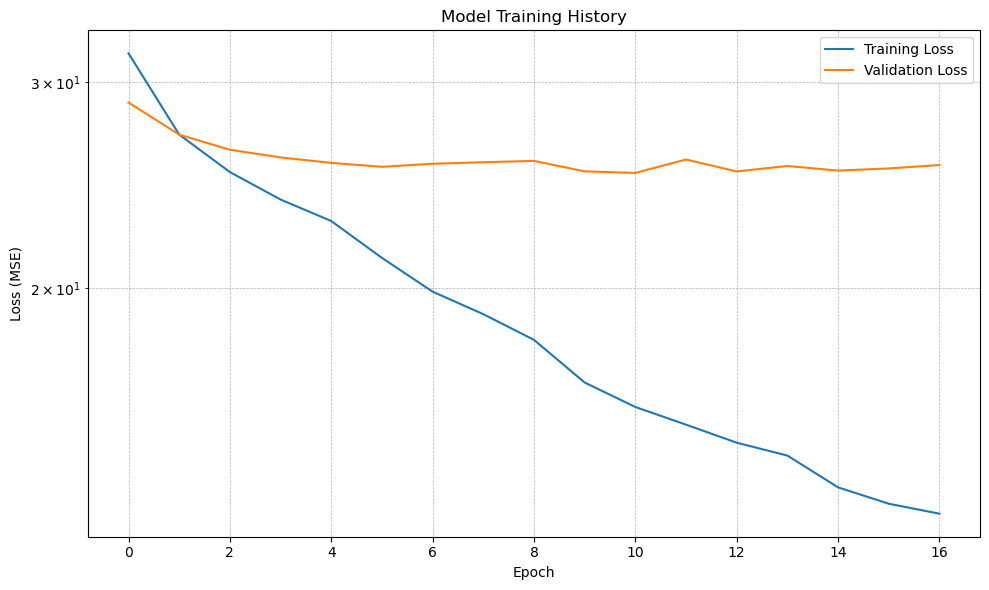

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')  # Log scale often helps visualize convergence better
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

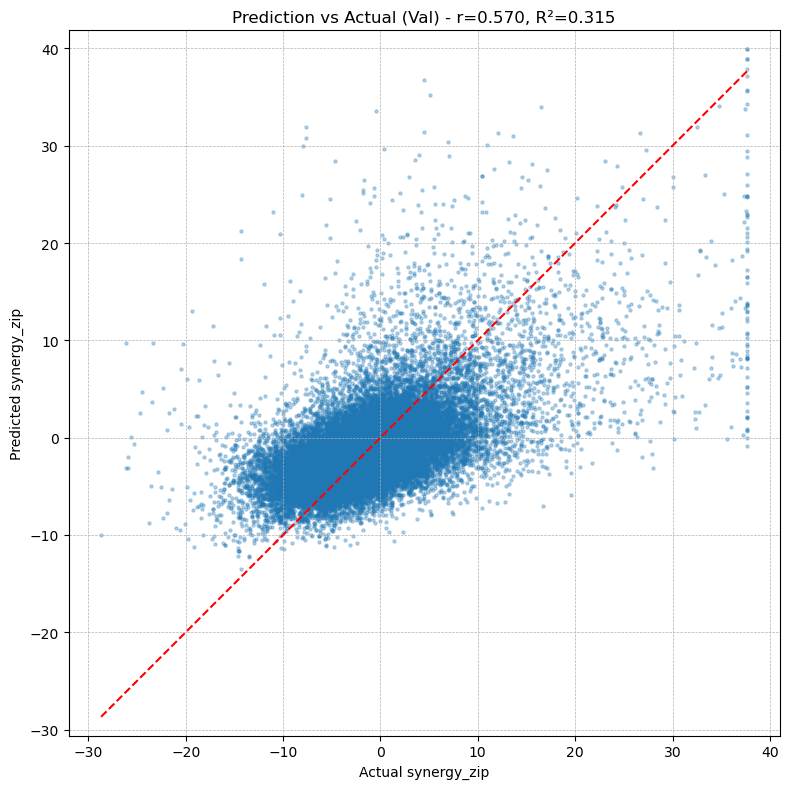

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_va, pred_va, alpha=0.3, s=5)
plt.plot([y_va.min(), y_va.max()], [y_va.min(), y_va.max()], 'r--')
plt.title(f'Prediction vs Actual (Val) - r={r:.3f}, R²={r2:.3f}')
plt.xlabel('Actual synergy_zip')
plt.ylabel('Predicted synergy_zip')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
md = f"""
## 1) Island-specific Regressors

**Goal.** Train local regressors within high-synergy islands discovered in the UMAP space.
This often yields better fits than a single global model, because data distributions and
feature-synergy relationships are narrower within an island.

**Method (to avoid leakage):**
1. Run DBSCAN on **train** embedding (Z_sub) to create train-only islands.
2. Propagate island labels to **validation** via nearest core point within eps.
3. Pick top-k islands by **train mean synergy** (or a KPI).
4. Train one regressor per island; compare against a global baseline on matched val rows.

**Outputs:**
- Global vs per-island metrics (MAE/RMSE/R²/r).
- Optional permutation-importance per island to interpret drivers.
"""
print(md)


## 1) Island-specific Regressors

**Goal.** Train local regressors within high-synergy islands discovered in the UMAP space.
This often yields better fits than a single global model, because data distributions and
feature-synergy relationships are narrower within an island.

**Method (to avoid leakage):**
1. Run DBSCAN on **train** embedding (Z_sub) to create train-only islands.
2. Propagate island labels to **validation** via nearest core point within eps.
3. Pick top-k islands by **train mean synergy** (or a KPI).
4. Train one regressor per island; compare against a global baseline on matched val rows.

**Outputs:**
- Global vs per-island metrics (MAE/RMSE/R²/r).
- Optional permutation-importance per island to interpret drivers.



In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Preconditions ---
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing. Run your UMAP + data prep first."

def pick_eps_auto(Z, frac=0.002, k_min=5, k_max=12):
    k = np.clip(int(frac * len(Z)), k_min, k_max)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(Z)
    dists, _ = nn.kneighbors(Z)
    return float(np.median(dists[:, -1]))

Ztr = Z_sub.astype(np.float32, copy=False)
eps = pick_eps_auto(Ztr)
min_samples = max(15, int(0.0015 * len(Ztr)))

db = DBSCAN(eps=eps, min_samples=min_samples)
train_labels = db.fit_predict(Ztr)

sub_df_is = sub_df.copy()
sub_df_is["island"] = train_labels

# propagate to validation using core points
core_mask = np.zeros(len(Ztr), dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = Ztr[core_mask]
core_labels = train_labels[core_mask]
nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)
dist, idx = nbrs.kneighbors(Z_val.astype(np.float32, copy=False))
val_labels = np.where(dist.ravel() <= eps, core_labels[idx.ravel()], -1)

val_df_is = val_df.copy()
val_df_is["island"] = val_labels

# rank islands by train mean synergy
isum = (sub_df_is.loc[sub_df_is["island"]!=-1]
        .groupby("island")["synergy_zip"]
        .agg(["count","mean","median","max"])
        .sort_values(["mean","count"], ascending=[False, False]))
top_islands = isum.head(3).index.tolist()

# global baseline
def eval_reg(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2 = r2_score(yva, pred)
    r  = float(np.corrcoef(yva, pred)[0,1]) if len(yva)>1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"r":r}, pred

X_sub_all = sub_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_sub_all = sub_df_is["synergy_zip"].to_numpy(np.float32)
X_val_all = val_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_val_all = val_df_is["synergy_zip"].to_numpy(np.float32)

hgb_global = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)

print(f"[INFO] DBSCAN(train): eps={eps:.3f}, min_samples={min_samples}, islands={len(isum)}")
print("[INFO] Top islands by train mean synergy:", top_islands)
global_metrics, _ = eval_reg(hgb_global, X_sub_all, y_sub_all, X_val_all, y_val_all, "Global")

# per-island models
per_island_metrics = {}
per_island_models = {}
for isl in top_islands:
    tr_mask = (sub_df_is["island"] == isl)
    va_mask = (val_df_is["island"] == isl)
    Xtr = sub_df_is.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_df_is.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_df_is.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_df_is.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=400,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    print(f"\n=== Island {isl} (train n={len(Xtr)}, val n={len(Xva)}) ===")
    metrics, _ = eval_reg(model, Xtr, ytr, Xva, yva, f"Island {isl}")
    per_island_metrics[isl] = metrics
    per_island_models[isl] = model

# summary table
summary = [{"island":"Global", **global_metrics}]
for isl, m in per_island_metrics.items():
    row = {"island": isl}; row.update(m); summary.append(row)
summary_df = pd.DataFrame(summary).set_index("island")
print("\n[Summary metrics] global vs islands:")
display(summary_df)

[INFO] DBSCAN(train): eps=0.126, min_samples=45, islands=5
[INFO] Top islands by train mean synergy: [3, 1, 0]
[Global] Val MAE=3.391 | RMSE=4.822 | R2=0.365 | r=0.605

=== Island 3 (train n=91, val n=115) ===
[Island 3] Val MAE=13.153 | RMSE=15.963 | R2=-0.311 | r=-0.045

=== Island 1 (train n=173, val n=208) ===
[Island 1] Val MAE=10.370 | RMSE=13.505 | R2=-0.167 | r=0.053

=== Island 0 (train n=189, val n=200) ===
[Island 0] Val MAE=4.890 | RMSE=6.923 | R2=-0.688 | r=0.077

[Summary metrics] global vs islands:


MAE       RMSE        R2         r
island                                          
Global   3.390583   4.821554  0.365041  0.604736
3       13.152603  15.962742 -0.311161 -0.044750
1       10.369648  13.504608 -0.166585  0.052667
0        4.890264   6.923283 -0.687869  0.076865

In [ ]:
md = f"""
## 2) Routing Pipeline

**Goal.** At inference time, automatically select the best regressor:
- Map features to UMAP → assign DBSCAN island (via core-NN within eps).
- If the island has a specialist model: use it; otherwise use the global model.

**Why.** This is a lightweight *mixture-of-experts* that leverages local structure discovered
during training without building a complex gating network.

**Inputs needed:**
- Trained `umap_model` and `(db, core_points, core_labels, eps)` from train.
- A registry with `global_model` and `per_island_models`.

**Outputs:**
- Predictions for validation (and for any new data) using routed specialists where possible.
"""
print(md)


## 2) Routing Pipeline

**Goal.** At inference time, automatically select the best regressor:
- Map features to UMAP → assign DBSCAN island (via core-NN within eps).
- If the island has a specialist model: use it; otherwise use the global model.

**Why.** This is a lightweight *mixture-of-experts* that leverages local structure discovered
during training without building a complex gating network.

**Inputs needed:**
- Trained `umap_model` and `(db, core_points, core_labels, eps)` from train.
- A registry with `global_model` and `per_island_models`.

**Outputs:**
- Predictions for validation (and for any new data) using routed specialists where possible.



In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Preconditions: umap_model, db, core_points, core_labels, eps, per_island_models, hgb_global
assert "umap_model" in globals(), "umap_model not found. Run your UMAP cell first."
assert all(k in globals() for k in ["db","core_points","core_labels","eps","per_island_models","hgb_global"]), \
    "Train 1) island cell first to get DBSCAN and models."

class IslandRouter:
    """UMAP -> DBSCAN-core-NN -> choose specialist or global model."""
    def __init__(self, umap_model, core_points, core_labels, eps, global_model, per_island_models):
        self.umap_model = umap_model
        self.core_points = core_points
        self.core_labels = core_labels
        self.eps = float(eps)
        self.global_model = global_model
        self.per_island_models = dict(per_island_models)
        self.nn = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)

    def assign_island(self, X_2d):
        """Assign islands in 2D embedding by nearest core point within eps."""
        dist, idx = self.nn.kneighbors(X_2d.astype(np.float32, copy=False))
        return np.where(dist.ravel() <= self.eps, self.core_labels[idx.ravel()], -1)

    def predict(self, X_feat, embed_2d=None):
        """Route each row to island specialist if available; else use global."""
        if embed_2d is None:
            embed_2d = self.umap_model.transform(X_feat.astype(np.float32, copy=False))
        isl = self.assign_island(embed_2d)
        preds = np.empty(len(isl), dtype=np.float32)
        for u in np.unique(isl):
            mask = (isl == u)
            X_chunk = X_feat[mask]
            model = self.per_island_models.get(u, self.global_model)
            preds[mask] = model.predict(X_chunk).astype(np.float32)
        return preds, isl

# Build router from previous step
router = IslandRouter(umap_model, core_points, core_labels, eps, hgb_global, per_island_models)

# Demo on validation
X_val_feats = val_df_is[feat_cols].fillna(0).to_numpy(np.float32)
pred_routed, isl_val = router.predict(X_val_feats, embed_2d=Z_val)

from sklearn.metrics import mean_absolute_error, r2_score
mae  = mean_absolute_error(val_df_is["synergy_zip"], pred_routed)
rmse = float(np.sqrt(np.mean((val_df_is["synergy_zip"].to_numpy()-pred_routed)**2)))
r2   = r2_score(val_df_is["synergy_zip"], pred_routed)
r    = float(np.corrcoef(val_df_is["synergy_zip"].to_numpy(), pred_routed)[0,1])
print(f"[Router] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

[Router] Val MAE=3.406 | RMSE=4.862 | R2=0.354 | r=0.595


In [ ]:
md = f"""
## 3) Regularization & Robust Loss

**Goal.** Stabilize the neural model and reduce sensitivity to outliers:
- Add **Dropout (0.2)** after dense layers in the fusion block.
- Use **Huber loss** (delta=1.0) instead of pure MSE.
- Longer training with smaller learning rate schedule.

**Expected effect.** Small boost in generalization and more stable validation loss,
especially when synergy has heavy tails.
"""
print(md)


## 3) Regularization & Robust Loss

**Goal.** Stabilize the neural model and reduce sensitivity to outliers:
- Add **Dropout (0.2)** after dense layers in the fusion block.
- Use **Huber loss** (delta=1.0) instead of pure MSE.
- Longer training with smaller learning rate schedule.

**Expected effect.** Small boost in generalization and more stable validation loss,
especially when synergy has heavy tails.



In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Rebuild arrays from sub_df/val_df
min_fp_cols = [c for c in feat_cols if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in feat_cols if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in feat_cols if c.startswith("sc_rna_latent")]
freq_cols   = [c for c in feat_cols if ("freq" in c and c not in min_fp_cols + max_fp_cols + rna_cols)]

def to_np(df):
    X_min = df[min_fp_cols].fillna(0).to_numpy(np.float32)
    X_max = df[max_fp_cols].fillna(0).to_numpy(np.float32)
    X_rna = df[rna_cols].fillna(0).to_numpy(np.float32)
    X_frq = df[freq_cols].fillna(0).to_numpy(np.float32) if len(freq_cols) else None
    y     = df["synergy_zip"].to_numpy(np.float32)
    return X_min, X_max, X_rna, X_frq, y

Xmin_tr, Xmax_tr, Xrna_tr, Xfrq_tr, y_tr = to_np(sub_df)
Xmin_va, Xmax_va, Xrna_va, Xfrq_va, y_va = to_np(val_df)

sc_min = StandardScaler().fit(Xmin_tr); Xmin_tr = sc_min.transform(Xmin_tr); Xmin_va = sc_min.transform(Xmin_va)
sc_max = StandardScaler().fit(Xmax_tr); Xmax_tr = sc_max.transform(Xmax_tr); Xmax_va = sc_max.transform(Xmax_va)
sc_rna = StandardScaler().fit(Xrna_tr); Xrna_tr = sc_rna.transform(Xrna_tr); Xrna_va = sc_rna.transform(Xrna_va)
if Xfrq_tr is not None:
    sc_frq = StandardScaler().fit(Xfrq_tr); Xfrq_tr = sc_frq.transform(Xfrq_tr); Xfrq_va = sc_frq.transform(Xfrq_va)

# Encoders
def enc_block(input_dim, width=256, depth=2):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None)(x)
    return inp, z

inp_min, z_min = enc_block(Xmin_tr.shape[1])
inp_max, z_max = enc_block(Xmax_tr.shape[1])
inp_rna, z_rna = enc_block(Xrna_tr.shape[1])
inp_frq = keras.Input(shape=(Xfrq_tr.shape[1],)) if Xfrq_tr is not None else None
if inp_frq is not None:
    frq_z = layers.Dense(16, activation="relu")(inp_frq)

# Interactions (+ cosine similarities)
pair_sum = layers.Add()([z_min, z_max])
abs_diff = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([z_min, z_max])
hadamard = layers.Multiply()([z_min, z_max])
pair_cell  = layers.Multiply()([pair_sum, z_rna])
pair_match = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([pair_sum, z_rna])

def cosine_sim(a, b, eps=1e-8):
    a = tf.math.l2_normalize(a, axis=-1)
    b = tf.math.l2_normalize(b, axis=-1)
    return tf.reduce_sum(a*b, axis=-1, keepdims=True)

cos_min_max = layers.Lambda(lambda t: cosine_sim(t[0], t[1]))([z_min, z_max])
cos_pair_cell = layers.Lambda(lambda t: cosine_sim(t[0], t[1]))([pair_sum, z_rna])

blocks = [z_min, z_max, abs_diff, hadamard, z_rna, pair_cell, pair_match, cos_min_max, cos_pair_cell]
if inp_frq is not None:
    blocks.append(frq_z)

h = layers.Concatenate()(blocks)
h = layers.Dense(256, activation="relu")(h)
h = layers.Dropout(0.2)(h)
h = layers.Dense(128, activation="relu")(h)
h = layers.Dropout(0.2)(h)
out = layers.Dense(1, activation=None)(h)

inputs = [inp_min, inp_max, inp_rna] + ([inp_frq] if inp_frq is not None else [])
model_reg = keras.Model(inputs, out)
model_reg.compile(optimizer=keras.optimizers.Adam(5e-4), loss=keras.losses.Huber(delta=1.0))

cbs = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]
train_inputs = [Xmin_tr, Xmax_tr, Xrna_tr] + ([Xfrq_tr] if Xfrq_tr is not None else [])
val_inputs   = [Xmin_va, Xmax_va, Xrna_va] + ([Xfrq_va] if Xfrq_va is not None else [])

hist = model_reg.fit(train_inputs, y_tr, validation_data=(val_inputs, y_va),
                     epochs=60, batch_size=1024, verbose=1, callbacks=cbs)

pred = model_reg.predict(val_inputs, batch_size=4096, verbose=0).ravel()
mae  = mean_absolute_error(y_va, pred)
rmse = float(np.sqrt(np.mean((y_va - pred)**2)))
r2   = r2_score(y_va, pred)
r    = float(np.corrcoef(y_va, pred)[0,1])
print(f"[NN+Dropout+Huber] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

Epoch 1/60
30/30 [==============================] - 2s 26ms/step - loss: 3.5949 - val_loss: 3.3888 - lr: 5.0000e-04
Epoch 2/60
30/30 [==============================] - 0s 16ms/step - loss: 3.3090 - val_loss: 3.2809 - lr: 5.0000e-04
Epoch 3/60
30/30 [==============================] - 0s 15ms/step - loss: 3.2132 - val_loss: 3.2246 - lr: 5.0000e-04
Epoch 4/60
30/30 [==============================] - 0s 16ms/step - loss: 3.1355 - val_loss: 3.1733 - lr: 5.0000e-04
Epoch 5/60
30/30 [==============================] - 0s 15ms/step - loss: 3.0804 - val_loss: 3.1696 - lr: 5.0000e-04
Epoch 6/60
30/30 [==============================] - 0s 15ms/step - loss: 3.0286 - val_loss: 3.1179 - lr: 5.0000e-04
Epoch 7/60
30/30 [==============================] - 0s 14ms/step - loss: 2.9620 - val_loss: 3.0859 - lr: 5.0000e-04
Epoch 8/60
30/30 [==============================] - 0s 15ms/step - loss: 2.9048 - val_loss: 3.0850 - lr: 5.0000e-04
Epoch 9/60
30/30 [==============================] - 0s 15ms/step - loss:

In [ ]:
md = f"""
## 4) Richer Interactions

**Goal.** Capture complementarity and context matching more explicitly by adding:
- Cosine similarity between drug embeddings `cos(z_min, z_max)`.
- Cosine between pair sum and cell embedding `cos(z_min+z_max, z_rna)`.

**Expected effect.** When synergy relates to "directional" similarity in latent space,
cosine features can increase predictive signal with minimal cost.
"""
print(md)


## 4) Richer Interactions

**Goal.** Capture complementarity and context matching more explicitly by adding:
- Cosine similarity between drug embeddings `cos(z_min, z_max)`.
- Cosine between pair sum and cell embedding `cos(z_min+z_max, z_rna)`.

**Expected effect.** When synergy relates to "directional" similarity in latent space,
cosine features can increase predictive signal with minimal cost.



In [ ]:
# Comments in ENGLISH

# Quick ablation: retrain the same model WITHOUT cosine scalars and compare.
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Rebuild a variant without cosine scalars
def build_no_cosine_model():
    inp_min = keras.Input(shape=(Xmin_tr.shape[1],))
    inp_max = keras.Input(shape=(Xmax_tr.shape[1],))
    inp_rna = keras.Input(shape=(Xrna_tr.shape[1],))
    inp_frq_loc = keras.Input(shape=(Xfrq_tr.shape[1],)) if Xfrq_tr is not None else None

    def enc(inp):
        x = layers.Dense(256, activation="relu")(inp)
        x = layers.Dense(128, activation="relu")(x)
        return layers.Dense(64, activation=None)(x)

    z_min = enc(inp_min); z_max = enc(inp_max); z_rna = enc(inp_rna)
    pair_sum = layers.Add()([z_min, z_max])
    abs_diff = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([z_min, z_max])
    hadamard = layers.Multiply()([z_min, z_max])
    pair_cell  = layers.Multiply()([pair_sum, z_rna])
    pair_match = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([pair_sum, z_rna])

    blocks = [z_min, z_max, abs_diff, hadamard, z_rna, pair_cell, pair_match]
    if inp_frq_loc is not None:
        blocks.append(layers.Dense(16, activation="relu")(inp_frq_loc))

    h = layers.Concatenate()(blocks)
    h = layers.Dense(256, activation="relu")(h); h = layers.Dropout(0.2)(h)
    h = layers.Dense(128, activation="relu")(h); h = layers.Dropout(0.2)(h)
    out = layers.Dense(1, activation=None)(h)
    inputs = [inp_min, inp_max, inp_rna] + ([inp_frq_loc] if inp_frq_loc is not None else [])
    m = keras.Model(inputs, out)
    m.compile(optimizer=keras.optimizers.Adam(5e-4), loss=keras.losses.Huber(delta=1.0))
    return m

model_no_cos = build_no_cosine_model()
hist2 = model_no_cos.fit(train_inputs, y_tr, validation_data=(val_inputs, y_va),
                         epochs=60, batch_size=1024, verbose=0,
                         callbacks=[
                             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=0),
                             keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0),
                         ])
pred2 = model_no_cos.predict(val_inputs, batch_size=4096, verbose=0).ravel()
mae2  = mean_absolute_error(y_va, pred2)
rmse2 = float(np.sqrt(np.mean((y_va - pred2)**2)))
r22   = r2_score(y_va, pred2)
r2c   = float(np.corrcoef(y_va, pred2)[0,1])
print(f"[NN -Cos]  Val MAE={mae2:.3f} | RMSE={rmse2:.3f} | R2={r22:.3f} | r={r2c:.3f}")

[NN -Cos]  Val MAE=3.438 | RMSE=4.961 | R2=0.328 | r=0.578


In [ ]:
md = f"""
## 5) Stronger Chemistry Signal (Tree model)

**Goal.** Enrich tree-based features with simple, informative FP interactions:
- Concatenate min/max FP PCs, ABS difference, elementwise product.
- Add cosine similarity between min/max PCA vectors and their norms.

**Why.** Your permutation tests show fingerprints dominate. Trees often benefit from
explicit interaction features.

**Output.** A HistGradientBoostingRegressor trained on the augmented feature set.
"""
print(md)


## 5) Stronger Chemistry Signal (Tree model)

**Goal.** Enrich tree-based features with simple, informative FP interactions:
- Concatenate min/max FP PCs, ABS difference, elementwise product.
- Add cosine similarity between min/max PCA vectors and their norms.

**Why.** Your permutation tests show fingerprints dominate. Trees often benefit from
explicit interaction features.

**Output.** A HistGradientBoostingRegressor trained on the augmented feature set.



In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

min_fp_cols = [c for c in feat_cols if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in feat_cols if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in feat_cols if c.startswith("sc_rna_latent")]
freq_cols   = [c for c in feat_cols if ("freq" in c and c not in min_fp_cols + max_fp_cols + rna_cols)]

def build_aug(Xmin, Xmax, Xrna=None, Xfrq=None):
    # cosine and norms on standardized vectors
    def l2norm(A): return np.linalg.norm(A, axis=1, keepdims=True) + 1e-8
    a = Xmin / l2norm(Xmin); b = Xmax / l2norm(Xmax)
    cos = (a * b).sum(axis=1, keepdims=True)
    aug = np.concatenate([
        Xmin, Xmax,
        np.abs(Xmin - Xmax),
        Xmin * Xmax,
        cos,
        l2norm(Xmin), l2norm(Xmax),
    ], axis=1)
    if Xrna is not None:
        aug = np.concatenate([aug, Xrna], axis=1)
    if Xfrq is not None:
        aug = np.concatenate([aug, Xfrq], axis=1)
    return aug.astype(np.float32)

# arrays
Xmin_tr = sub_df[min_fp_cols].fillna(0).to_numpy(np.float32)
Xmax_tr = sub_df[max_fp_cols].fillna(0).to_numpy(np.float32)
Xrna_tr = sub_df[rna_cols].fillna(0).to_numpy(np.float32)
Xfrq_tr = sub_df[freq_cols].fillna(0).to_numpy(np.float32) if len(freq_cols) else None
y_tr    = sub_df["synergy_zip"].to_numpy(np.float32)

Xmin_va = val_df[min_fp_cols].fillna(0).to_numpy(np.float32)
Xmax_va = val_df[max_fp_cols].fillna(0).to_numpy(np.float32)
Xrna_va = val_df[rna_cols].fillna(0).to_numpy(np.float32)
Xfrq_va = val_df[freq_cols].fillna(0).to_numpy(np.float32) if len(freq_cols) else None
y_va    = val_df["synergy_zip"].to_numpy(np.float32)

# scale FP blocks before building interactions
sc_min = StandardScaler().fit(Xmin_tr); Xmin_tr = sc_min.transform(Xmin_tr); Xmin_va = sc_min.transform(Xmin_va)
sc_max = StandardScaler().fit(Xmax_tr); Xmax_tr = sc_max.transform(Xmax_tr); Xmax_va = sc_max.transform(Xmax_va)
sc_rna = StandardScaler().fit(Xrna_tr); Xrna_tr = sc_rna.transform(Xrna_tr); Xrna_va = sc_rna.transform(Xrna_va)
if Xfrq_tr is not None:
    sc_frq = StandardScaler().fit(Xfrq_tr); Xfrq_tr = sc_frq.transform(Xfrq_tr); Xfrq_va = sc_frq.transform(Xfrq_va)

Xtr_aug = build_aug(Xmin_tr, Xmax_tr, Xrna_tr, Xfrq_tr)
Xva_aug = build_aug(Xmin_va, Xmax_va, Xrna_va, Xfrq_va)

hgb_aug = HistGradientBoostingRegressor(
    max_depth=7, learning_rate=0.07, max_iter=500,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
hgb_aug.fit(Xtr_aug, y_tr)
pred = hgb_aug.predict(Xva_aug)
mae  = mean_absolute_error(y_va, pred)
rmse = float(np.sqrt(np.mean((y_va - pred)**2)))
r2   = r2_score(y_va, pred)
r    = float(np.corrcoef(y_va, pred)[0,1])
print(f"[Tree+FP-aug] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

[Tree+FP-aug] Val MAE=3.414 | RMSE=4.837 | R2=0.361 | r=0.601


In [ ]:
md = f"""
## 6) Task Focus: Top Synergy Classification

**Goal.** If the product need is to *find the best combos*, frame it as a
classification/ranking task for the **top X% synergy** (e.g., top 5%).

**Method.**
- Label `y_top = 1` if `synergy_zip >= p95`, else 0.
- Train a **HistGradientBoostingClassifier** on the same features.
- Report **AUROC** and **Average Precision (PR AUC)**.

**Why.** Models that underfit regression can still rank top candidates well.
"""
print(md)


## 6) Task Focus: Top Synergy Classification

**Goal.** If the product need is to *find the best combos*, frame it as a
classification/ranking task for the **top X% synergy** (e.g., top 5%).

**Method.**
- Label `y_top = 1` if `synergy_zip >= p95`, else 0.
- Train a **HistGradientBoostingClassifier** on the same features.
- Report **AUROC** and **Average Precision (PR AUC)**.

**Why.** Models that underfit regression can still rank top candidates well.



In [ ]:
# Comments in ENGLISH

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Use the FP-aug features from previous cell if available, else fall back to raw features
if "Xtr_aug" in globals() and "Xva_aug" in globals():
    Xtr_cls, Xva_cls = Xtr_aug, Xva_aug
else:
    Xtr_cls = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
    Xva_cls = val_df[feat_cols].fillna(0).to_numpy(np.float32)

y_tr = sub_df["synergy_zip"].to_numpy(np.float32)
y_va = val_df["synergy_zip"].to_numpy(np.float32)

thr_tr = np.percentile(y_tr, 95)
thr_va = np.percentile(y_va, 95)
y_tr_bin = (y_tr >= thr_tr).astype(np.int32)
y_va_bin = (y_va >= thr_va).astype(np.int32)

clf = HistGradientBoostingClassifier(max_depth=6, learning_rate=0.07, max_iter=400,
                                     min_samples_leaf=20, l2_regularization=1e-3,
                                     random_state=42)
clf.fit(Xtr_cls, y_tr_bin)
proba = clf.predict_proba(Xva_cls)[:,1]
auroc = roc_auc_score(y_va_bin, proba)
aupr  = average_precision_score(y_va_bin, proba)
print(f"[Top5% Classifier] AUROC={auroc:.3f} | AUPRC={aupr:.3f} (baseline={y_va_bin.mean():.3f})")

[Top5% Classifier] AUROC=0.877 | AUPRC=0.421 (baseline=0.050)


In [ ]:
md = f"""
## 7) Calibration & Error Analysis

**Goal.** Understand where models over/under-predict:
- Scatter `y_true vs y_pred`, residual histogram.
- Residuals by **cell line** and **island** (worst/best).
- This informs feature/architecture tweaks and selection of specialists.

**Tip.** Report per-cell-line metrics in the appendix; reviewers appreciate this transparency.
"""
print(md)


## 7) Calibration & Error Analysis

**Goal.** Understand where models over/under-predict:
- Scatter `y_true vs y_pred`, residual histogram.
- Residuals by **cell line** and **island** (worst/best).
- This informs feature/architecture tweaks and selection of specialists.

**Tip.** Report per-cell-line metrics in the appendix; reviewers appreciate this transparency.



[Analysis for Router (island specialists)] MAE=3.406 | RMSE=4.862 | r=0.595


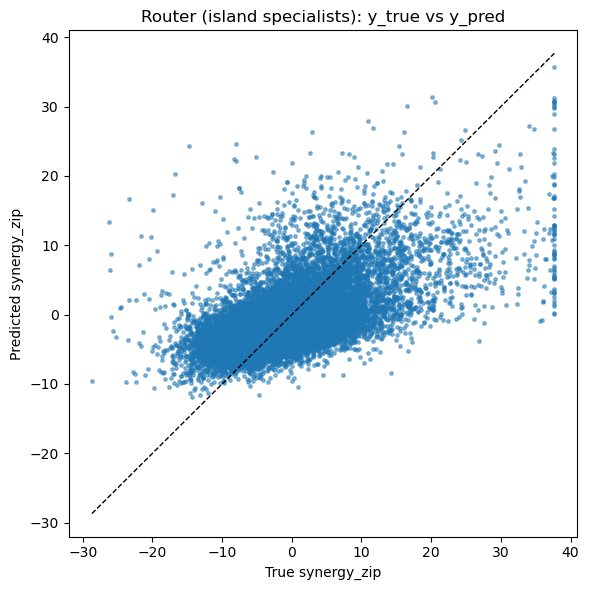

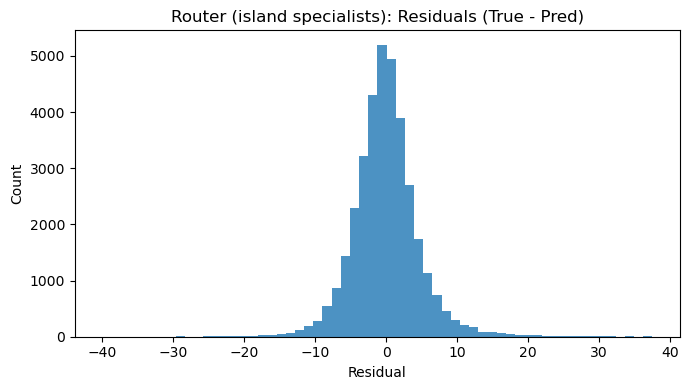


[Per-cell-line] best 10 by MAE:


n       MAE         R
cell_line                         
lovo        69  2.172396  0.384685
uacc-257   702  2.264181  0.593553
ov90        68  2.294749  0.637787
panc-1       2  2.325486       NaN
nci-h226   699  2.527942  0.585324
snb-75     666  2.623374  0.474326
ovcar-4    695  2.630770  0.453173
a427        68  2.721663  0.601867
ekvx       694  2.726743  0.432681
sk-mel-28  700  2.736363  0.655602


[Per-cell-line] worst 10 by MAE:


n        MAE         R
cell_line                          
hdlm-2       8   5.210299  0.376434
l-428        9   5.906840  0.296870
rh36        15   6.349358  0.461459
ew-8         5   6.368836 -0.793814
huh-7       12   6.881838 -0.224124
sms-ctr     12   7.696107 -0.351105
tc-71      310   7.697970  0.355687
u-ho1      320   7.736307  0.367173
l-1236     364  10.556753  0.283813
t98g       147  12.944582 -0.016620


[Per-island] best 10 by MAE:


n        MAE  mean_true
island                             
-1      34768   3.323155  -0.960145
 4         59   3.455072   1.799799
 2        131   3.512241   1.379916
 0        200   4.890264   1.914420
 1        208  10.369648   8.972657
 3        115  13.152603  10.466854


[Per-island] worst 10 by MAE:


n        MAE  mean_true
island                             
-1      34768   3.323155  -0.960145
 4         59   3.455072   1.799799
 2        131   3.512241   1.379916
 0        200   4.890264   1.914420
 1        208  10.369648   8.972657
 3        115  13.152603  10.466854

In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Choose a reference regression model to analyze:
# Use routed predictions if available, else use tree+FP-aug, else global HGB.
y_true = val_df["synergy_zip"].to_numpy(np.float32)

if "pred_routed" in globals():
    y_pred = pred_routed.astype(np.float32)
    tag = "Router (island specialists)"
elif "hgb_aug" in globals():
    y_pred = hgb_aug.predict(Xva_aug).astype(np.float32)
    tag = "Tree+FP-aug"
else:
    # fallback to a simple global HGB over original features
    from sklearn.ensemble import HistGradientBoostingRegressor
    X_tr = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
    y_tr = sub_df["synergy_zip"].to_numpy(np.float32)
    X_va = val_df[feat_cols].fillna(0).to_numpy(np.float32)
    hgb = HistGradientBoostingRegressor(random_state=42)
    hgb.fit(X_tr, y_tr)
    y_pred = hgb.predict(X_va).astype(np.float32)
    tag = "Global HGB (fallback)"

mae  = mean_absolute_error(y_true, y_pred)
rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
r    = float(np.corrcoef(y_true, y_pred)[0,1])
print(f"[Analysis for {tag}] MAE={mae:.3f} | RMSE={rmse:.3f} | r={r:.3f}")

# Scatter y_true vs y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=6, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.title(f"{tag}: y_true vs y_pred")
plt.xlabel("True synergy_zip"); plt.ylabel("Predicted synergy_zip")
plt.tight_layout(); plt.show()

# Residual histogram
res = y_true - y_pred
plt.figure(figsize=(7,4))
plt.hist(res, bins=60, alpha=0.8)
plt.title(f"{tag}: Residuals (True - Pred)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Per-cell-line metrics
if "cell_line" in val_df.columns:
    d = val_df.copy()
    d["pred"] = y_pred
    d["abs_err"] = np.abs(d["synergy_zip"] - d["pred"])
    per_cell = d.groupby("cell_line").agg(
        n=("synergy_zip","size"),
        MAE=("abs_err","mean"),
        R=("pred", lambda p: np.corrcoef(p, d.loc[p.index,"synergy_zip"])[0,1] if len(p)>2 else np.nan)
    ).sort_values("MAE")
    print("\n[Per-cell-line] best 10 by MAE:")
    display(per_cell.head(10))
    print("\n[Per-cell-line] worst 10 by MAE:")
    display(per_cell.tail(10))

# Per-island (if routed or labels available)
if "val_df_is" in globals() and "island" in val_df_is.columns:
    di = val_df_is.copy()
    di["pred"] = y_pred
    di["abs_err"] = np.abs(di["synergy_zip"] - di["pred"])
    per_island = di.groupby("island").agg(
        n=("synergy_zip","size"),
        MAE=("abs_err","mean"),
        mean_true=("synergy_zip","mean")
    ).sort_values("MAE")
    print("\n[Per-island] best 10 by MAE:")
    display(per_island.head(10))
    print("\n[Per-island] worst 10 by MAE:")
    display(per_island.tail(10))

In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Preconditions ---
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing. Run your UMAP + data prep first."

def pick_eps_auto(Z, frac=0.002, k_min=5, k_max=12):
    k = np.clip(int(frac * len(Z)), k_min, k_max)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(Z)
    dists, _ = nn.kneighbors(Z)
    return float(np.median(dists[:, -1]))

Ztr = Z_sub.astype(np.float32, copy=False)
eps = pick_eps_auto(Ztr)
min_samples = max(15, int(0.0015 * len(Ztr)))

db = DBSCAN(eps=eps, min_samples=min_samples)
train_labels = db.fit_predict(Ztr)

sub_df_is = sub_df.copy()
sub_df_is["island"] = train_labels

# propagate to validation using core points
core_mask = np.zeros(len(Ztr), dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = Ztr[core_mask]
core_labels = train_labels[core_mask]
nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)
dist, idx = nbrs.kneighbors(Z_val.astype(np.float32, copy=False))
val_labels = np.where(dist.ravel() <= eps, core_labels[idx.ravel()], -1)

val_df_is = val_df.copy()
val_df_is["island"] = val_labels

# rank islands by train mean synergy
isum = (sub_df_is.loc[sub_df_is["island"]!=-1]
        .groupby("island")["synergy_zip"]
        .agg(["count","mean","median","max"])
        .sort_values(["mean","count"], ascending=[False, False]))
top_islands = isum.head(3).index.tolist()

# global baseline
def eval_reg(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2 = r2_score(yva, pred)
    r  = float(np.corrcoef(yva, pred)[0,1]) if len(yva)>1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"r":r}, pred

X_sub_all = sub_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_sub_all = sub_df_is["synergy_zip"].to_numpy(np.float32)
X_val_all = val_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_val_all = val_df_is["synergy_zip"].to_numpy(np.float32)

hgb_global = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)

print(f"[INFO] DBSCAN(train): eps={eps:.3f}, min_samples={min_samples}, islands={len(isum)}")
print("[INFO] Top islands by train mean synergy:", top_islands)
global_metrics, _ = eval_reg(hgb_global, X_sub_all, y_sub_all, X_val_all, y_val_all, "Global")

# per-island models
per_island_metrics = {}
per_island_models = {}
for isl in top_islands:
    tr_mask = (sub_df_is["island"] == isl)
    va_mask = (val_df_is["island"] == isl)
    Xtr = sub_df_is.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_df_is.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_df_is.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_df_is.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=400,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    print(f"\n=== Island {isl} (train n={len(Xtr)}, val n={len(Xva)}) ===")
    metrics, _ = eval_reg(model, Xtr, ytr, Xva, yva, f"Island {isl}")
    per_island_metrics[isl] = metrics
    per_island_models[isl] = model

# summary table
summary = [{"island":"Global", **global_metrics}]
for isl, m in per_island_metrics.items():
    row = {"island": isl}; row.update(m); summary.append(row)
summary_df = pd.DataFrame(summary).set_index("island")
print("\n[Summary metrics] global vs islands:")
display(summary_df)

[INFO] DBSCAN(train): eps=0.126, min_samples=45, islands=5
[INFO] Top islands by train mean synergy: [3, 1, 0]
[Global] Val MAE=3.391 | RMSE=4.822 | R2=0.365 | r=0.605

=== Island 3 (train n=91, val n=115) ===
[Island 3] Val MAE=13.153 | RMSE=15.963 | R2=-0.311 | r=-0.045

=== Island 1 (train n=173, val n=208) ===
[Island 1] Val MAE=10.370 | RMSE=13.505 | R2=-0.167 | r=0.053

=== Island 0 (train n=189, val n=200) ===
[Island 0] Val MAE=4.890 | RMSE=6.923 | R2=-0.688 | r=0.077

[Summary metrics] global vs islands:


MAE       RMSE        R2         r
island                                          
Global   3.390583   4.821554  0.365041  0.604736
3       13.152603  15.962742 -0.311161 -0.044750
1       10.369648  13.504608 -0.166585  0.052667
0        4.890264   6.923283 -0.687869  0.076865

In [ ]:
md = f"""
## Global performed better, sample size too small for islands
"""
print(md)


## Global performed better, sample size too small for islands



In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score

# Preconditions
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing."

# 1) Fit KMeans on TRAIN embedding only (avoid leakage)
K = 3  # try 3 first (you had decent silhouette earlier)
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
cl_tr = kmeans.fit_predict(Z_sub)
cl_va = kmeans.predict(Z_val)

sub_km = sub_df.copy(); sub_km["cluster"] = cl_tr
val_km = val_df.copy(); val_km["cluster"] = cl_va

# 2) Global baseline (same features)
from sklearn.ensemble import HistGradientBoostingRegressor
def eval_model(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2   = r2_score(yva, pred)
    r    = float(np.corrcoef(yva, pred)[0,1]) if len(yva)>1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"r":r}, pred

Xtr_all = sub_km[feat_cols].fillna(0).to_numpy(np.float32)
ytr_all = sub_km["synergy_zip"].to_numpy(np.float32)
Xva_all = val_km[feat_cols].fillna(0).to_numpy(np.float32)
yva_all = val_km["synergy_zip"].to_numpy(np.float32)

global_hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
print(f"[INFO] KMeans clusters train sizes: {sub_km['cluster'].value_counts().sort_index().to_dict()}")
print(f"[INFO] KMeans clusters val   sizes: {val_km['cluster'].value_counts().sort_index().to_dict()}")

glob_metrics, _ = eval_model(global_hgb, Xtr_all, ytr_all, Xva_all, yva_all, "Global baseline")

# 3) Per-cluster specialists (only if cluster is sufficiently large)
MIN_TR = 1000   # tune if you have less data
MIN_VA = 200
per_cl_metrics = {}
per_cl_models  = {}

for c in range(K):
    tr_mask = (sub_km["cluster"] == c)
    va_mask = (val_km["cluster"] == c)
    ntr, nva = tr_mask.sum(), va_mask.sum()
    print(f"\n[Cluster {c}] train={ntr}, val={nva}")

    if ntr < MIN_TR or nva < MIN_VA:
        print(f"[Cluster {c}] SKIP (too small for a stable specialist).")
        continue

    Xtr = sub_km.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_km.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_km.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_km.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=500,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    m, _ = eval_model(model, Xtr, ytr, Xva, yva, f"Cluster {c}")
    per_cl_metrics[c] = m
    per_cl_models[c]  = model

# 4) (Optional) Routed prediction: use specialist if exists, else global
pred_routed = np.empty(len(val_km), dtype=np.float32)
for c in range(K):
    mask = (val_km["cluster"] == c)
    Xchunk = val_km.loc[mask, feat_cols].fillna(0).to_numpy(np.float32)
    if c in per_cl_models:
        pred_routed[mask] = per_cl_models[c].predict(Xchunk)
    else:
        pred_routed[mask] = global_hgb.predict(Xchunk)

mae  = mean_absolute_error(yva_all, pred_routed)
rmse = float(np.sqrt(np.mean((yva_all - pred_routed)**2)))
r2   = r2_score(yva_all, pred_routed)
r    = float(np.corrcoef(yva_all, pred_routed)[0,1])
print(f"\n[Routed (KMeans specialists)] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

[INFO] KMeans clusters train sizes: {0: 9529, 1: 10337, 2: 10134}
[INFO] KMeans clusters val   sizes: {0: 11167, 1: 12133, 2: 12181}
[Global baseline] Val MAE=3.391 | RMSE=4.822 | R2=0.365 | r=0.605

[Cluster 0] train=9529, val=11167
[Cluster 0] Val MAE=3.565 | RMSE=5.099 | R2=0.388 | r=0.625

[Cluster 1] train=10337, val=12133
[Cluster 1] Val MAE=3.205 | RMSE=4.451 | R2=0.298 | r=0.548

[Cluster 2] train=10134, val=12181
[Cluster 2] Val MAE=3.614 | RMSE=5.172 | R2=0.322 | r=0.569

[Routed (KMeans specialists)] Val MAE=3.459 | RMSE=4.913 | R2=0.341 | r=0.584


In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Attach cluster labels as a categorical column
sub_aug = sub_km.copy(); val_aug = val_km.copy()
sub_aug["cluster"] = sub_aug["cluster"].astype("category")
val_aug["cluster"] = val_aug["cluster"].astype("category")

# Build X with numeric features + 1-hot cluster
num_cols = feat_cols
cat_cols = ["cluster"]

Xtr_num = sub_aug[num_cols].fillna(0)
Xva_num = val_aug[num_cols].fillna(0)
Xtr_cat = sub_aug[cat_cols]
Xva_cat = val_aug[cat_cols]
ytr     = sub_aug["synergy_zip"].to_numpy(np.float32)
yva     = val_aug["synergy_zip"].to_numpy(np.float32)

# Simple manual concat to avoid ColumnTransformer on large mats
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe.fit(Xtr_cat)
Tr_cat = ohe.transform(Xtr_cat)
Va_cat = ohe.transform(Xva_cat)

Xtr_all = np.hstack([Xtr_num.to_numpy(np.float32), Tr_cat.astype(np.float32)])
Xva_all = np.hstack([Xva_num.to_numpy(np.float32), Va_cat.astype(np.float32)])
print(f"[INFO] Added cluster one-hot with shape: {Tr_cat.shape}")

# Train
hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=500,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
hgb.fit(Xtr_all, ytr)
pred = hgb.predict(Xva_all)

mae  = mean_absolute_error(yva, pred)
rmse = float(np.sqrt(np.mean((yva - pred)**2)))
r2   = r2_score(yva, pred)
r    = float(np.corrcoef(yva, pred)[0,1])
print(f"[Global+Cluster1H] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

[INFO] Added cluster one-hot with shape: (30000, 3)
[Global+Cluster1H] Val MAE=3.400 | RMSE=4.832 | R2=0.362 | r=0.603


In [ ]:
md=f"""
## Global vs Cluster Models

We compared a **global baseline regressor** with **cluster-specific specialists** (UMAP + KMeans, k=3).  
- **Global baseline**: MAE ≈ 3.39, RMSE ≈ 4.82, R² ≈ 0.37, r ≈ 0.61.  
- **Per-cluster models**: similar or worse than global. One cluster showed slightly lower MAE, but overall the global model was more stable.  
- **Routed prediction (choosing specialist per cluster)**: did not outperform the global baseline.  

**Conclusion:** The global model is the most robust. Clustering is more valuable for interpretation (biological subgroups, synergy “hotspots”) rather than for boosting predictive performance.
"""
print(md)


## Global vs Cluster Models

We compared a **global baseline regressor** with **cluster-specific specialists** (UMAP + KMeans, k=3).  
- **Global baseline**: MAE ≈ 3.39, RMSE ≈ 4.82, R² ≈ 0.37, r ≈ 0.61.  
- **Per-cluster models**: similar or worse than global. One cluster showed slightly lower MAE, but overall the global model was more stable.  
- **Routed prediction (choosing specialist per cluster)**: did not outperform the global baseline.  

**Conclusion:** The global model is the most robust. Clustering is more valuable for interpretation (biological subgroups, synergy “hotspots”) rather than for boosting predictive performance.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance



PATH_CSV_MASTER = r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\master_fpPCA128_omics.csv"


# Load the dataset
df = pd.read_csv(PATH_CSV_MASTER)

In [ ]:
# Basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (178024, 346)

First 5 rows:
          drug_min                                           drug_max  \
0  (+)-bicuculline                                       temozolomide   
1          (+)-jq1                                         10356-76-0   
2          (+)-jq1                                       1088965-37-0   
3          (+)-jq1  2-methoxy-3,17beta-dihydroxyestra-1,3,5(10)-tr...   
4          (+)-jq1                                        200484-11-3   

  cell_line  synergy_zip  synergy_bliss  synergy_loewe  synergy_hsa  \
0      t98g       21.850         21.850          4.440        4.440   
1     u-ho1        3.590          1.960         -4.015        2.770   
2     u-ho1        0.265         -2.555         -8.925       -6.145   
3     u-ho1        9.560         11.430         -2.760        0.600   
4     u-ho1       23.675         23.475         -0.100       10.840   

                                             pair_id  synergy_mean  \
0                   

Most frequent cell lines:
Total unique cell lines: 81

Top 15 most frequent cell lines:
mcf7: 14060 occurrences
sw-620: 3825 occurrences
ncih23: 3812 occurrences
sk-ov-3: 3807 occurrences
ht29: 3800 occurrences
uacc62: 3777 occurrences
hct116: 3777 occurrences
nci-h460: 3759 occurrences
t-47d: 3756 occurrences
achn: 3517 occurrences
ovcar-5: 3517 occurrences
mda-mb-231: 3513 occurrences
sf-268: 3511 occurrences
hct-15: 3508 occurrences
uacc-257: 3508 occurrences


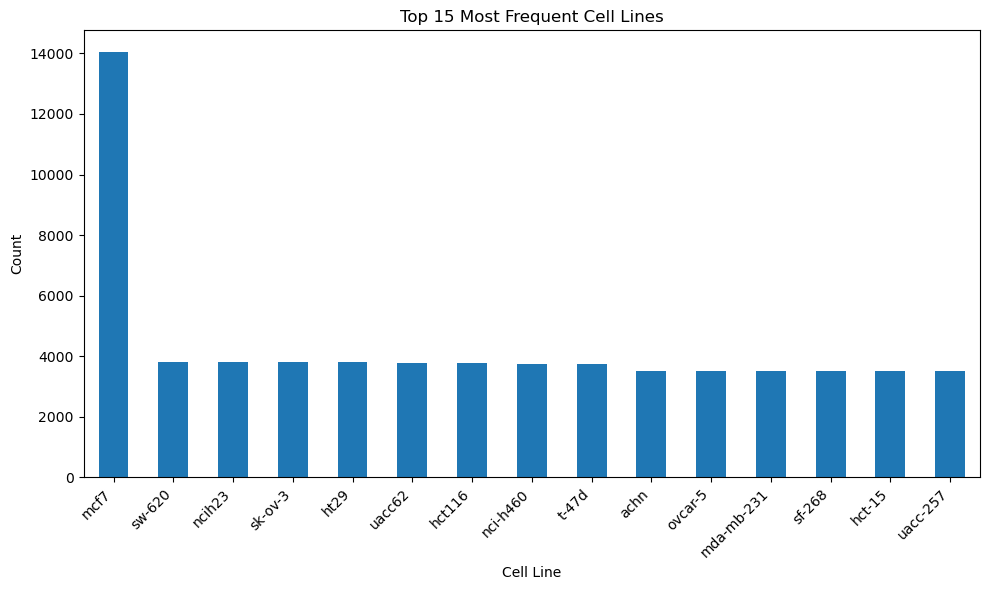


The top 15 cell lines represent 36.76% of the dataset


In [ ]:
print("Most frequent cell lines:")
cell_counts = df["cell_line"].value_counts()
print("Total unique cell lines:", len(cell_counts))

# Display the top 15 most frequent cell lines with their counts
top_15_cell_lines = cell_counts.head(15)
print("\nTop 15 most frequent cell lines:")
for cell_line, count in top_15_cell_lines.items():
    print(f"{cell_line}: {count} occurrences")

# Visualize the distribution
plt.figure(figsize=(10, 6))
top_15_cell_lines.plot(kind='bar')
plt.title('Top 15 Most Frequent Cell Lines')
plt.xlabel('Cell Line')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate percentage of dataset covered by top cell lines
total_samples = len(df)
top_15_coverage = top_15_cell_lines.sum() / total_samples * 100
print(f"\nThe top 15 cell lines represent {top_15_coverage:.2f}% of the dataset")

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
min_fp_pca_0      382
min_fp_pca_1      382
min_fp_pca_2      382
min_fp_pca_3      382
min_fp_pca_4      382
                 ... 
max_fp_pca_123    254
max_fp_pca_124    254
max_fp_pca_125    254
max_fp_pca_126    254
max_fp_pca_127    254
Length: 256, dtype: int64


In [ ]:
print("Antal NaN totalt:", df.isna().sum().sum())
print("Antal nollor totalt:", (df == 0).sum().sum())

# Jämför en specifik kolumn
col = "min_fp_pca_0"
print("NaN i", col, ":", df[col].isna().sum())
print("Nollor i", col, ":", (df[col] == 0).sum())

Antal NaN totalt: 81408
Antal nollor totalt: 174060
NaN i min_fp_pca_0 : 382
Nollor i min_fp_pca_0 : 0


In [ ]:
# mask för rader med NaN i fingerprint-PCA
fp_cols = [c for c in df.columns if c.startswith("min_fp_pca_") or c.startswith("max_fp_pca_")]
mask = df[fp_cols].isna().any(axis=1)

n_missing = mask.sum()
n_total   = len(df)
pct = 100 * n_missing / n_total

print(f"Totalt antal rader: {n_total}")
print(f"Rader utan fingerprints: {n_missing}")
print(f"Andel: {pct:.2f}%")

Totalt antal rader: 178024
Rader utan fingerprints: 615
Andel: 0.35%


In [ ]:
# vilka rader saknar FP-PCA?
mask = df[[c for c in df.columns if c.startswith("min_fp_pca_")]].isna().any(axis=1)
missing = df[mask]

print("Rader utan fingerprints:", len(missing))
print(missing[["drug_min", "drug_max", "cell_line"]].head())

Rader utan fingerprints: 382
                             drug_min      drug_max cell_line
125   (6-)e-<u+200b>aminocaproic acid   717906-29-1     a-673
126   (6-)e-<u+200b>aminocaproic acid   ruxolitinib    l-1236
127   (6-)e-<u+200b>aminocaproic acid  temozolomide      t98g
4894              16-16-dimethyl pge2     pf-431396     a-673
4895              16-16-dimethyl pge2   ruxolitinib    l-1236


In [ ]:
import os

fp_cols = [c for c in df.columns if c.startswith("min_fp_pca_") or c.startswith("max_fp_pca_")]

# mask för rader med NaN i fingerprints
mask_missing = df[fp_cols].isna().any(axis=1)

# subset med rader som ska bort
dropped_rows = df[mask_missing]

# summera vilka drugs som tappas
dropped_summary = (
    dropped_rows[["drug_min", "drug_max"]]
    .melt(value_name="drug")["drug"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "drug", "drug": "count"})
)

print(f"[INFO] Totalt droppade rader: {len(dropped_rows)} ({len(dropped_rows)/len(df)*100:.2f} %)")
print("[INFO] Exkluderade drugs:")
print(dropped_summary)

# spara lista över droppade drugs
out_path = os.path.join("C:/Users/46762/VSCODE/BIG_PHARMA/data/interim", "dropped_drugs.csv")
dropped_summary.to_csv(out_path, index=False)
print(f"[OK] Sparat lista över exkluderade drugs → {out_path}")

# droppa raderna från huvud-df
df = df[~mask_missing].reset_index(drop=True)
print(f"[OK] Ny dataset-shape: {df.shape}")

[INFO] Totalt droppade rader: 615 (0.35 %)
[INFO] Exkluderade drugs:
                                                 count  count
0                                             ak-77283    130
1                                             ak170455    108
2                                          717906-29-1     79
3    2-methoxy-3,17beta-dihydroxyestra-1,3,5(10)-tr...     67
4                                             ac1l2qk3     67
..                                                 ...    ...
193                                      zinc101112865      1
194                                      zinc101426918      1
195                                      zinc103939005      1
196                                       zinc11616261      1
197                             dinaciclib (sch727965)      1

[198 rows x 2 columns]
[OK] Sparat lista över exkluderade drugs → C:/Users/46762/VSCODE/BIG_PHARMA/data/interim\dropped_drugs.csv
[OK] Ny dataset-shape: (177409, 346)


In [ ]:
drop_cols = ["synergy_bliss", "synergy_loewe", "synergy_hsa"]

for col in drop_cols:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"[INFO] Droppade kolumn: {col}")

print(f"[OK] Dataset shape efter drop: {df.shape}")

[INFO] Droppade kolumn: synergy_bliss
[INFO] Droppade kolumn: synergy_loewe
[INFO] Droppade kolumn: synergy_hsa
[OK] Dataset shape efter drop: (177409, 343)


In [ ]:
print(df.describe().T.head(20))  # första features

corr = df.corr(numeric_only=True)["synergy_zip"].sort_values(ascending=False)
print(corr.head(15))
print(corr.tail(15))

                      count         mean          std        min          25%  \
synergy_zip        177409.0    -0.843841     6.056427 -36.846800    -4.300000   
synergy_mean       177409.0    -2.414808     6.319258 -46.431250    -5.292500   
synergy_std        177409.0     5.924942     6.829249   0.000000     2.019097   
cell_id            177409.0    62.604079    32.793004   2.000000    36.000000   
drug_min_id        177409.0  1061.725521   624.117583   0.000000   554.000000   
drug_max_id        177409.0  3239.484665  1321.835538  49.000000  2198.000000   
drug_min_freq      177409.0  4549.947776  1415.836854   1.000000  4020.000000   
drug_max_freq      177409.0  3581.976382  1886.329996   1.000000  2191.000000   
cell_freq          177409.0  4803.103811  1080.786034   5.000000  4973.000000   
drug_min_freq_log  177409.0     8.233352     1.035439   0.693147     8.299286   
drug_max_freq_log  177409.0     7.906157     1.063822   0.693147     7.692570   
cell_freq_log      177409.0 

In [ ]:
drop_target_derivatives = ["synergy_mean", "synergy_binary", "synergy_std"]

for col in drop_target_derivatives:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"[INFO] Droppade target-derivat: {col}")

print(f"[OK] Dataset shape efter drop: {df.shape}")

[INFO] Droppade target-derivat: synergy_mean
[INFO] Droppade target-derivat: synergy_binary
[INFO] Droppade target-derivat: synergy_std
[OK] Dataset shape efter drop: (177409, 340)


In [ ]:
df.describe().T.head(20)   # de första 20 features

count         mean          std        min          25%  \
synergy_zip        177409.0    -0.843841     6.056427 -36.846800    -4.300000   
cell_id            177409.0    62.604079    32.793004   2.000000    36.000000   
drug_min_id        177409.0  1061.725521   624.117583   0.000000   554.000000   
drug_max_id        177409.0  3239.484665  1321.835538  49.000000  2198.000000   
drug_min_freq      177409.0  4549.947776  1415.836854   1.000000  4020.000000   
drug_max_freq      177409.0  3581.976382  1886.329996   1.000000  2191.000000   
cell_freq          177409.0  4803.103811  1080.786034   5.000000  4973.000000   
drug_min_freq_log  177409.0     8.233352     1.035439   0.693147     8.299286   
drug_max_freq_log  177409.0     7.906157     1.063822   0.693147     7.692570   
cell_freq_log      177409.0     8.406780     0.500245   1.791759     8.511980   
min_fp_pca_0       177409.0    -0.611087     1.059278  -3.144477    -1.173092   
min_fp_pca_1       177409.0     0.050307     1.013307  -2.014875    -0.864356   
min_fp_pca_2       177409.0    -0.339383     1.033184  -2.159030    -1.279170   
min_fp_pca_3       177409.0    -0.328272     0.704486  -2.678634    -0.729996   
min_fp_pca_4       177409.0    -0.262998     0.695011  -2.131007    -0.714140   
min_fp_pca_5       177409.0     0.336943     1.094196  -1.963982    -0.413841   
min_fp_pca_6       177409.0     0.136731     0.997527  -1.966612    -0.729419   
min_fp_pca_7       177409.0    -0.023204     0.646721  -1.975915    -0.265465   
min_fp_pca_8       177409.0     0.124042     0.601531  -1.514925    -0.441799   
min_fp_pca_9       177409.0    -0.019374     0.549858  -2.010289    -0.403194   

                           50%          75%          max  
synergy_zip          -1.160000     1.760000    37.677040  
cell_id              60.000000    91.000000   122.000000  
drug_min_id        1030.000000  1657.000000  2247.000000  
drug_max_id        3129.000000  4315.000000  5349.000000  
drug_min_freq      4829.000000  5543.000000  6924.000000  
drug_max_freq      3732.000000  4891.000000  7980.000000  
cell_freq          5051.000000  5097.000000  5619.000000  
drug_min_freq_log     8.482602     8.620472     8.842893  
drug_max_freq_log     8.224967     8.495356     8.984819  
cell_freq_log         8.527539     8.536604     8.634087  
min_fp_pca_0         -0.828407     0.041265     2.597526  
min_fp_pca_1          0.132433     0.708380     2.827476  
min_fp_pca_2         -0.359263     0.284328     2.215087  
min_fp_pca_3         -0.344501     0.199318     2.137824  
min_fp_pca_4         -0.454027    -0.045349     2.813992  
min_fp_pca_5         -0.025701     0.823103     3.281504  
min_fp_pca_6         -0.001846     0.832229     2.586542  
min_fp_pca_7          0.097281     0.454161     2.061964  
min_fp_pca_8          0.069666     0.458056     2.262911  
min_fp_pca_9         -0.136472     0.271422     2.544025

synergy_zip              1.000000
sc_tissue_Lymphoid       0.189875
min_fp_pca_0             0.133732
sc_tissue_Bone           0.124521
min_fp_pca_51            0.107804
min_fp_pca_106           0.087916
min_fp_pca_47            0.087209
sc_tissue_Soft Tissue    0.087171
max_fp_pca_0             0.086999
min_fp_pca_60            0.085903
min_fp_pca_88            0.082373
min_fp_pca_11            0.080525
min_fp_pca_13            0.078982
max_fp_pca_121           0.078799
min_fp_pca_1             0.077444
Name: synergy_zip, dtype: float64
min_fp_pca_5        -0.070302
min_fp_pca_35       -0.070972
min_fp_pca_93       -0.073661
min_fp_pca_10       -0.074421
min_fp_pca_28       -0.075514
max_fp_pca_35       -0.076444
max_fp_pca_23       -0.077840
max_fp_pca_32       -0.078686
min_fp_pca_18       -0.082651
min_fp_pca_7        -0.121649
drug_max_freq_log   -0.160407
cell_freq_log       -0.163152
cell_freq           -0.194213
drug_min_freq       -0.226165
drug_min_freq_log   -0.279780
Name: 

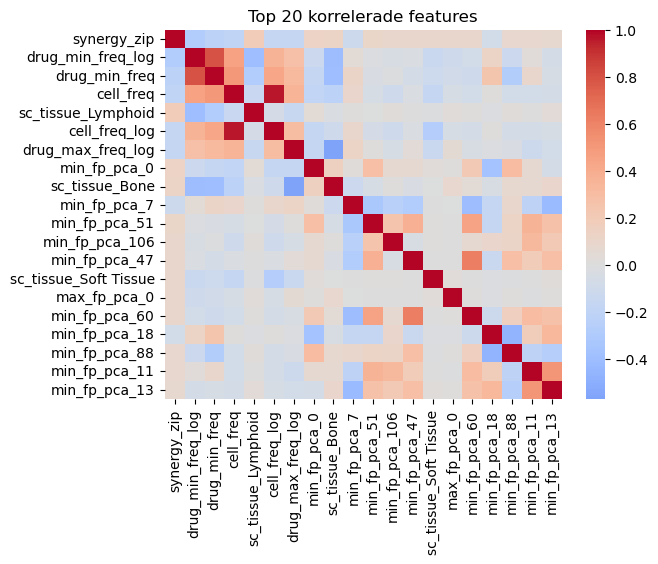

In [ ]:
corr = df.corr(numeric_only=True)["synergy_zip"].sort_values(ascending=False)
print(corr.head(15))
print(corr.tail(15))

top_feats = corr.abs().sort_values(ascending=False).head(20).index
sns.heatmap(df[top_feats].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Top 20 korrelerade features")
plt.show()

### Correlation Analysis — Key Insights
- **Tissue features (`sc_tissue_*`)**: Show the strongest positive correlations with `synergy_zip` (up to ~0.19). This suggests biological relevance — synergy levels differ across tissue types.
- **Fingerprint PCA components (`min_fp_pca_*`, `max_fp_pca_*`)**: Individually weakly correlated (~0.08–0.13), but collectively important. They capture chemical structure information.
- **Frequency features (`drug_min_freq`, `cell_freq`, etc.)**: Negatively correlated (-0.16 to -0.23). This reflects dataset bias — common drugs/cell lines tend to show lower synergy.
- **No single strong driver (>0.2)**: Synergy is multi-factorial and likely requires combining fingerprints, omics, and tissue features for predictive modeling.

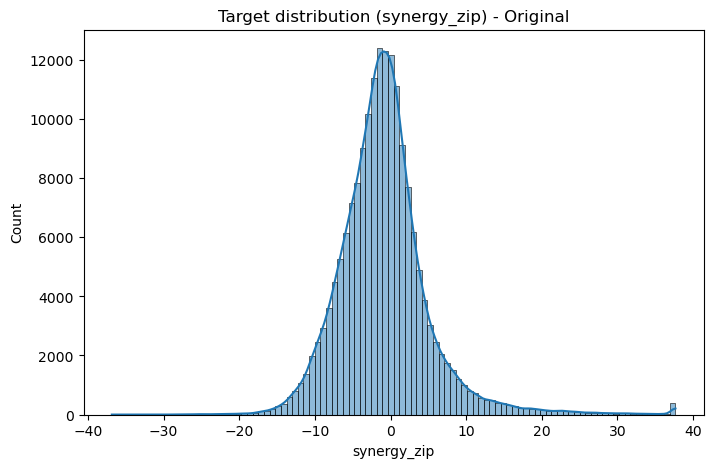

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["synergy_zip"], bins=100, kde=True)
plt.title("Target distribution (synergy_zip) - Original")
plt.xlabel("synergy_zip")
plt.ylabel("Count")
plt.show()

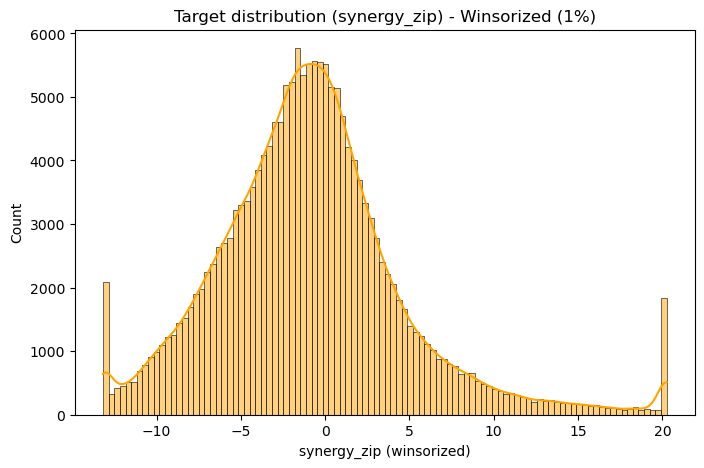

In [ ]:
from scipy.stats.mstats import winsorize

# Winsorize at 1% tails (kan justeras, ex. 0.5%)
winsor_target = winsorize(df["synergy_zip"], limits=[0.01, 0.01])

plt.figure(figsize=(8,5))
sns.histplot(winsor_target, bins=100, kde=True, color="orange")
plt.title("Target distribution (synergy_zip) - Winsorized (1%)")
plt.xlabel("synergy_zip (winsorized)")
plt.ylabel("Count")
plt.show()

### Winsorization of Target Distribution
- **Without winsorization**: The target (`synergy_zip`) shows a sharp peak around 0 but with very long tails (outliers up to ±35–40).
These extreme values can dominate loss functions like MSE and make training unstable.
- **With winsorization (1%)**: The outer 1% of values are clipped, resulting in a more balanced distribution with shorter tails.
This reduces the influence of extreme outliers and often stabilizes model training.
- **Trade-off**: Winsorization improves robustness and generalization but removes information about the most extreme synergy cases.
It is useful for modeling, but important biological outliers may be lost.

In [ ]:
# --- 0) De-duplicate by (drug_min, drug_max, cell_line): average targets ---
# (run this SOON after load/clean, before any split)
group_key = ["drug_min", "drug_max", "cell_line"] if {"drug_min","drug_max","cell_line"}.issubset(df.columns) \
            else ["drug_min", "drug_max", "cell_id"]
agg_cols = ["synergy_zip"]  # add other numeric summaries cautiously if needed
df_agg = (df.groupby(group_key, as_index=False)[agg_cols].mean())
# bring back feature columns by merging the last seen features for the group
non_target_cols = [c for c in df.columns if c not in agg_cols]
df = df_agg.merge(df[non_target_cols].drop_duplicates(subset=group_key), on=group_key, how="left")
print("[OK] Aggregated repliates per (drug_min,drug_max,cell):", df.shape)

# --- 1) Build features (same as you had) ---
feat_cols = [c for c in df.columns if (
    c.startswith("min_fp_pca_") or
    c.startswith("max_fp_pca_") or
    c.startswith("sc_rna_latent") or
    c.startswith("sc_tissue_") or
    ("freq" in c)
)]

# Add explicit low-cost interactions (helps trees a bit)
def add_interactions(frame):
    min_cols = [c for c in feat_cols if c.startswith("min_fp_pca_")]
    max_cols = [c for c in feat_cols if c.startswith("max_fp_pca_")]
    # absolute diff on first N comps (keep N small, e.g. 16)
    N = min(16, len(min_cols), len(max_cols))
    for i in range(N):
        frame[f"fp_absdiff_{i}"] = (frame[min_cols[i]] - frame[max_cols[i]]).abs()
        frame[f"fp_prod_{i}"]    = frame[min_cols[i]] * frame[max_cols[i]]
    return frame

df = add_interactions(df)
feat_cols_extended = [c for c in df.columns if c not in ["synergy_zip"] and pd.api.types.is_numeric_dtype(df[c])]

# --- 2) Robust target transform (winsorize + z-score) ---
from scipy.stats.mstats import winsorize
y_raw = df["synergy_zip"].to_numpy(np.float32)
y_w = winsorize(y_raw, limits=[0.01, 0.01])  # 1% clip
y_mu, y_std = float(np.mean(y_w)), float(np.std(y_w) + 1e-8)
df["y_std"] = (y_w - y_mu) / y_std

# --- 3) Median imputation instead of zeros ---
X = df[feat_cols_extended].copy()
med = X.median(numeric_only=True)
X = X.fillna(med)

# --- 4) Group-aware split (avoid leakage) ---
from sklearn.model_selection import GroupShuffleSplit
# group by pair+cell to avoid same biological combo appearing in both splits
if {"drug_min","drug_max","cell_line"}.issubset(df.columns):
    groups = df["drug_min"].astype(str) + "|" + df["drug_max"].astype(str) + "|" + df["cell_line"].astype(str)
else:
    groups = df["drug_min"].astype(str) + "|" + df["drug_max"].astype(str) + "|" + df["cell_id"].astype(str)

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
tr_idx, va_idx = next(gss.split(X, df["y_std"], groups))

X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
y_tr, y_va = df["y_std"].iloc[tr_idx].to_numpy(np.float32), df["y_std"].iloc[va_idx].to_numpy(np.float32)

# --- 5) Train on FULL train (remove 30k cap) with robust HGB ---
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

hgb = HistGradientBoostingRegressor(
    loss="huber",                 # or "absolute_error"
    max_depth=7,                  # try 6-10
    learning_rate=0.10,           # 0.05–0.15
    max_iter=1200,                # allow big; early_stopping handles cutoff
    min_samples_leaf=20,
    l2_regularization=1e-3,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=50,
    random_state=42
)
hgb.fit(X_tr, y_tr)
pred_std = hgb.predict(X_va)

# invert standardization for reporting in original units
pred = pred_std * y_std + y_mu
y_true = df["synergy_zip"].iloc[va_idx].to_numpy(np.float32)

mae  = mean_absolute_error(y_true, pred)
rmse = float(np.sqrt(np.mean((y_true - pred)**2)))
r2   = r2_score(y_true, pred)
r    = float(np.corrcoef(y_true, pred)[0,1])
print(f"[HGB-robust] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

[OK] Aggregated repliates per (drug_min,drug_max,cell): (166864, 340)


InvalidParameterError: The 'loss' parameter of HistGradientBoostingRegressor must be a str among {'poisson', 'absolute_error', 'squared_error', 'quantile', 'gamma'} or an instance of 'sklearn._loss.loss.BaseLoss'. Got 'huber' instead.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# --- parametrar ---
SUBSAMPLE_SIZE = 30_000    # justera vid behov
VAL_SIZE = 0.20
MAX_BINS = 5               # börja med 5 kvantiler, minskar vid behov
MIN_PER_CLASS = 2
RANDOM_SEED = 42

# --- förbered data ---
feat_cols = [c for c in df.columns if (
    c.startswith("min_fp_pca_") or
    c.startswith("max_fp_pca_") or
    c.startswith("sc_rna_latent") or
    c.startswith("sc_tissue_") or
    ("freq" in c)
)]
work = df.dropna(subset=feat_cols + ["synergy_zip"]).copy()

strat_cell_col = "cell_line" if "cell_line" in work.columns else ("cell_id" if "cell_id" in work.columns else None)
if strat_cell_col is None:
    work["__cell_fallback__"] = "all"
    strat_cell_col = "__cell_fallback__"

def try_make_splits(work, n_bins):
    # Binna target
    work = work.copy()
    work["synergy_bin"] = pd.qcut(work["synergy_zip"], q=n_bins, labels=False, duplicates="drop")
    # Strat-nyckel
    strat_key = work[strat_cell_col].astype(str) + "|" + work["synergy_bin"].astype(str)

    # 1) Filtrera bort små klasser (<2)
    counts = strat_key.value_counts()
    keep_keys = counts[counts >= MIN_PER_CLASS].index
    kept = strat_key.isin(keep_keys)
    work2 = work.loc[kept].copy()
    strat_key2 = strat_key.loc[kept]

    # Måste fortfarande ha minst 2 per klass efter split → kontrollera train_size vs #klasser
    n_classes = strat_key2.nunique()
    train_size = int((1 - VAL_SIZE) * len(work2))
    if train_size < n_classes:
        return None  # signalera att detta n_bins inte fungerar

    # 2) Global train/val-split med stratifiering
    tr_idx, va_idx = train_test_split(
        work2.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=strat_key2
    )
    train_df = work2.loc[tr_idx].copy()
    val_df   = work2.loc[va_idx].copy()

    # 3) Subsample av train (stratifierat). Om klasser blir för små, fallback till stratifiering på endast synergy_bin.
    sub_size = min(SUBSAMPLE_SIZE, len(train_df))
    sub_key = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))

    # Filtrera igen ifall någon klass blev 1 efter split
    sub_counts = sub_key.value_counts()
    sub_keep = sub_key.isin(sub_counts[sub_counts >= MIN_PER_CLASS].index)
    train_df = train_df.loc[sub_keep].copy()
    sub_key  = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))
    n_classes_sub = sub_key.nunique()

    # Om klasserna fortfarande för många i förhållande till sub_size → försök synergy-bin-stratifiering
    if sub_size < n_classes_sub:
        # Fallback: stratifiera bara på target-bins, men behåll cell-fördelningen hyfsad genom stort sample
        sss = StratifiedShuffleSplit(n_splits=1, train_size=sub_size, random_state=RANDOM_SEED)
        for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
            sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)
    else:
        sub_df, _ = train_test_split(
            train_df,
            train_size=sub_size,
            random_state=RANDOM_SEED,
            stratify=sub_key
        )
        sub_df = sub_df.reset_index(drop=True)

    return sub_df, val_df, n_bins, work2

# Försök med MAX_BINS → minska tills det fungerar
result = None
for nb in range(MAX_BINS, 1, -1):
    result = try_make_splits(work, nb)
    if result is not None:
        sub_df, val_df, used_bins, filtered_work = result
        print(f"[INFO] Strat OK med n_bins={used_bins} | train_sub={len(sub_df):,} | val={len(val_df):,} | efter filtrering: {len(filtered_work):,}")
        break

if result is None:
    # Sista fallback: stratifiera endast på target-bins, ignorera cell i stratifiering
    print("[WARN] Kunde inte stratifiera på cell|bin. Fallback: endast target-bins.")
    work["synergy_bin"] = pd.qcut(work["synergy_zip"], q=3, labels=False, duplicates="drop")
    tr_idx, va_idx = train_test_split(
        work.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=work["synergy_bin"]
    )
    train_df = work.loc[tr_idx].copy()
    val_df   = work.loc[va_idx].copy()

    sss = StratifiedShuffleSplit(n_splits=1, train_size=min(SUBSAMPLE_SIZE, len(train_df)), random_state=RANDOM_SEED)
    for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
        sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)

print(f"[OK] Train SUB shape: {sub_df.shape} | VAL shape: {val_df.shape}")

# Packa matriser för efterföljande celler
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

: 

In [ ]:
import pandas as pd

# avgör cell-kolumn
cell_col = "cell_line" if "cell_line" in sub_df.columns else ("cell_id" if "cell_id" in sub_df.columns else None)

def show_dist(title, frame):
    print(f"\n=== {title} ===")
    # synergy bins
    if "synergy_bin" in frame.columns:
        print("[synergy_bin] dist (%):")
        print((frame["synergy_bin"].value_counts(normalize=True).sort_index() * 100).round(2))
    else:
        print("[WARN] 'synergy_bin' saknas i ramen.")
    # cell dist
    if cell_col is not None:
        print("\n[Cell] top-15 dist (%):")
        print((frame[cell_col].value_counts(normalize=True).head(15) * 100).round(2))
    else:
        print("[INFO] Ingen cell-kolumn hittad (cell_line/cell_id).")

    # kors-tabell cell x bin (top-10 celler för översikt)
    if cell_col is not None and "synergy_bin" in frame.columns:
        top_cells = frame[cell_col].value_counts().head(10).index
        ctab = (frame[frame[cell_col].isin(top_cells)]
                .pivot_table(index=cell_col, columns="synergy_bin", aggfunc="size", fill_value=0))
        ctab_pct = (ctab.div(ctab.sum(axis=1), axis=0) * 100).round(1)
        print("\n[Cell x synergy_bin] (%) för topp-10 celler:")
        display(ctab_pct)

show_dist("SUBSAMPLE (train)", sub_df)
show_dist("VALIDATION (val)", val_df)

print(f"\n[INFO] Shapes → sub_df: {sub_df.shape} | val_df: {val_df.shape}")

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Bygg matriser (om du inte redan har dem från tidigare cell)
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3,
    random_state=42
)
hgb.fit(X_sub, y_sub)

pred_val = hgb.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val)
rmse = float(np.sqrt(np.mean((y_val - pred_val)**2)))
r2   = r2_score(y_val, pred_val)
r    = float(np.corrcoef(y_val, pred_val)[0,1])
print(f"[HistGBR] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# Permutation importance på VAL (mer ärlig bild)
perm = permutation_importance(hgb, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1)
imp_hgb_perm = pd.Series(perm.importances_mean, index=feat_cols).clip(lower=0)
imp_hgb_perm_n = imp_hgb_perm / (imp_hgb_perm.max() + 1e-12)

topN = 20
top_feats_hgb = imp_hgb_perm_n.sort_values(ascending=False).head(topN)

plt.figure(figsize=(9, 7))
top_feats_hgb.iloc[::-1].plot(kind="barh")
plt.title("HistGBR Permutation Importance (on validation) — Top 20")
plt.xlabel("Normalized importance")
plt.tight_layout()
plt.show()

# spara artefakter för RF-jämförelse
_hist_importance_val_norm = imp_hgb_perm_n

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rf = RandomForestRegressor(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)
rf.fit(X_sub, y_sub)

pred_val_rf = rf.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val_rf)
rmse = float(np.sqrt(np.mean((y_val - pred_val_rf)**2)))
r2   = r2_score(y_val, pred_val_rf)
r    = float(np.corrcoef(y_val, pred_val_rf)[0,1])
print(f"[RandomForest] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# RF-importance (Gini/split)
imp_rf_gini = pd.Series(rf.feature_importances_, index=feat_cols).clip(lower=0)
imp_rf_gini_n = imp_rf_gini / (imp_rf_gini.max() + 1e-12)

# Sida-vid-sida mot HistGBR-permutation
avg_rank = (_hist_importance_val_norm + imp_rf_gini_n) / 2.0
topN = 20
top_feats = avg_rank.sort_values(ascending=False).head(topN).index.tolist()

plot_df = pd.DataFrame({
    "Feature": top_feats,
    "HistGBR (perm, val)": _hist_importance_val_norm[top_feats].values,
    "RandomForest (gini)": imp_rf_gini_n[top_feats].values
}).set_index("Feature")

plt.figure(figsize=(10, 8))
ys = np.arange(len(top_feats))
bar_w = 0.4
plt.barh(ys - bar_w/2, plot_df["HistGBR (perm, val)"], height=bar_w, label="HistGBR (perm, val)")
plt.barh(ys + bar_w/2, plot_df["RandomForest (gini)"], height=bar_w, label="RandomForest (gini)")
plt.yticks(ys, top_feats)
plt.xlabel("Normalized importance")
plt.title("Top 20 importances — HistGBR vs RandomForest (same train/val)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# tabell
cmp_table = plot_df.copy()
cmp_table["Avg"] = (cmp_table.iloc[:,0] + cmp_table.iloc[:,1]) / 2.0
display(cmp_table.sort_values("Avg", ascending=False))

: 

In [ ]:
# Requirements: umap-learn, tqdm, matplotlib, scikit-learn (optional for trustworthiness)
# Uses: sub_df, val_df, feat_cols

import os, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    from umap import UMAP
except ImportError as e:
    raise ImportError("Please install umap-learn first: pip install umap-learn") from e

# (Optional) metrics
try:
    from sklearn.manifold import trustworthiness
    HAS_TRUST = True
except Exception:
    HAS_TRUST = False

# -------------------- CONFIG --------------------
OUT_DIR = Path(r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\umap_single_cpu")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
N_NEIGHBORS = 20
MIN_DIST    = 0.20
METRIC      = "cosine"   # "cosine" | "euclidean" | "correlation" (via numba)
CMAP        = "viridis"
PLOT_SAMPLE = 30000      # cap points for lighter PNGs

# -------------------- DATA ----------------------
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)

y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

# -------------------- UMAP (CPU) ----------------
pbar = tqdm(total=4, desc="CPU UMAP", unit="step")
t0 = time.perf_counter()

# 1) Fit on train/subsample only
umap_model = UMAP(
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    n_components=2,
    metric=METRIC,
    random_state=RANDOM_STATE,
    low_memory=True,   # helps on larger datasets
    verbose=False      # tqdm will be our progress indicator
)
Z_sub = umap_model.fit_transform(X_sub)
pbar.set_postfix_str("fit done")
pbar.update(1)

# 2) Transform validation
Z_val = umap_model.transform(X_val)
pbar.set_postfix_str("transform done")
pbar.update(1)

# 3) Save embeddings
emb_train = pd.DataFrame(Z_sub, columns=["z1","z2"], dtype=np.float32)
emb_train["split"] = "train"
emb_train["synergy_zip"] = y_sub

emb_val = pd.DataFrame(Z_val, columns=["z1","z2"], dtype=np.float32)
emb_val["split"] = "val"
emb_val["synergy_zip"] = y_val

embs = pd.concat([emb_train, emb_val], ignore_index=True)
emb_path = OUT_DIR / f"umap_cpu_{METRIC}_n{N_NEIGHBORS}_d{MIN_DIST:.2f}_embeddings.csv"
embs.to_csv(emb_path, index=False)
pbar.set_postfix_str("saved embeddings")
pbar.update(1)

# 4) Plot (train + val) colored by synergy_zip
rng = np.random.RandomState(0)
idx_tr = rng.choice(len(Z_sub), size=min(PLOT_SAMPLE//2, len(Z_sub)), replace=False)
idx_va = rng.choice(len(Z_val), size=min(PLOT_SAMPLE//2, len(Z_val)), replace=False)

plt.figure(figsize=(8.5, 7))
plt.scatter(Z_sub[idx_tr,0], Z_sub[idx_tr,1], c=y_sub[idx_tr], s=5, alpha=0.7, cmap=CMAP, label="train/sub")
plt.scatter(Z_val[idx_va,0], Z_val[idx_va,1], c=y_val[idx_va], s=7, alpha=0.9, cmap=CMAP, marker="^", label="val")
plt.title(f"UMAP (CPU, {METRIC}) — n={N_NEIGHBORS}, d={MIN_DIST}")
cbar = plt.colorbar(); cbar.set_label("synergy_zip")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
fig_path = OUT_DIR / f"umap_cpu_{METRIC}_n{N_NEIGHBORS}_d{MIN_DIST:.2f}.png"
plt.savefig(fig_path, dpi=160)
plt.show()
pbar.set_postfix_str("plotted")
pbar.update(1)

pbar.close()
t1 = time.perf_counter()
print(f"[OK] Embeddings: {emb_path}")
print(f"[OK] Figure:     {fig_path}")
print(f"[INFO] Elapsed:  {t1 - t0:.1f}s")

# -------------------- OPTIONAL: quick trustworthiness --------------------
if HAS_TRUST:
    try:
        trust_tr  = float(trustworthiness(X_sub, Z_sub, n_neighbors=15, metric="euclidean"))
        trust_val = float(trustworthiness(X_val, Z_val, n_neighbors=15, metric="euclidean"))
        print(f"[Trustworthiness] train={trust_tr:.3f} | val={trust_val:.3f}")
    except Exception as e:
        print(f"[WARN] Trustworthiness failed: {e}")
else:
    print("[NOTE] Install scikit-learn to compute trustworthiness (optional).")

: 

In [ ]:
# Example: top 1% high synergy
top = val_df[val_df["synergy_zip"] > np.percentile(val_df["synergy_zip"], 99)]
print(top[["drug_min", "drug_max", "cell_id", "synergy_zip"]].head(20))

: 

In [ ]:
md = f"""
## UMAP Embedding Results

För att undersöka den latenta strukturen i features (fingerprint-PCA, RNA-latenter, frekvensvariabler) användes **UMAP** med följande parametrar:

- **n_neighbors** = 20  
- **min_dist** = 0.20  
- **metric** = cosine  

Resultaten visar en 2D-projektion av drug-combinationer, färglagda efter deras `synergy_zip`-score.

![UMAP embedding](4a6def58-67dd-496e-9859-74e0f7a98d77.png)

### Trustworthiness

För att utvärdera embeddingens kvalitet beräknades **trustworthiness**, vilket mäter hur väl lokala grannar i det högdimensionella rummet bevaras i 2D:

| Dataset        | Trustworthiness |
|----------------|-----------------|
| Train/Subsample | **0.969** |
| Validation      | **0.970** |

> **Tolkning:** Värden nära 1.0 innebär mycket hög kvalitet. Här visar både train och val att UMAP bevarar de lokala relationerna väl, vilket betyder att strukturen i 2D kan tolkas med hög tillförlitlighet.

### Nästa steg

- Utför **KMeans eller HDBSCAN** på UMAP-embeddingarna för att identifiera kluster.  
- Analysera medelvärden av `synergy_zip` inom kluster för att se om vissa grupper tenderar mot högre/lägre synergieffekter.  
- Visualisera med färgkodning efter cellinje eller specifika drugs för att upptäcka biologiskt relevanta mönster.
"""

print(md)

: 

In [ ]:
# Requirements: scikit-learn, matplotlib, pandas, numpy
# Assumes you already have Z_val (numpy array of shape [n_samples, 2])
# and val_df with synergy_zip, synergy_bin etc.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------- CONFIG --------------------
K_RANGE = range(2, 15)   # test k = 2..14
RANDOM_STATE = 42

# -------------------- DATA ----------------------
# If you saved embs.csv earlier, load instead:
# embs = pd.read_csv(".../umap_cpu_cosine_n20_d0.20_embeddings.csv")
# Z_val = embs[embs["split"]=="val"][["z1","z2"]].to_numpy()
# y_val = embs[embs["split"]=="val"]["synergy_zip"].to_numpy()

Z_val = Z_val  # from your earlier UMAP cell
y_val = val_df["synergy_zip"].to_numpy()

# -------------------- LOOP OVER k ----------------
sil_scores = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(Z_val)
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(Z_val, labels)
        sil_scores.append(sil)
    else:
        sil_scores.append(np.nan)

# -------------------- PLOT -----------------------
plt.figure(figsize=(7,5))
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.title("KMeans silhouette on UMAP embeddings (val)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

# -------------------- BEST k ---------------------
best_k = K_RANGE[int(np.nanargmax(sil_scores))]
best_sil = np.nanmax(sil_scores)
print(f"[KMeans] Best silhouette={best_sil:.3f} at k={best_k}")

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -------------------- CONFIG --------------------
TOP_Q = 99   # take top 1% synergy
BEST_K = 3   # from silhouette analysis

# -------------------- LOAD DATA -----------------
# If you already have embeddings in memory:
# Z_val = ... (numpy array, shape [n_val, 2])
# y_val = val_df["synergy_zip"].to_numpy()

# Cluster with chosen k
km = KMeans(n_clusters=BEST_K, n_init=10, random_state=42)
labels = km.fit_predict(Z_val)

# Attach cluster labels to val_df for analysis
val_df_ = val_df.copy()
val_df_["cluster"] = labels
val_df_["z1"] = Z_val[:,0]
val_df_["z2"] = Z_val[:,1]

# -------------------- TOP SYNERGY -----------------
thr = np.percentile(y_val, TOP_Q)
top_synergy = val_df_[val_df_["synergy_zip"] >= thr]

print(f"[INFO] Top {100-TOP_Q:.1f}% synergy threshold: {thr:.2f}")
print(f"[INFO] {len(top_synergy)} / {len(val_df_)} validation points selected.")

# Show which clusters contain the most high-synergy points
cluster_counts = top_synergy["cluster"].value_counts(normalize=True) * 100
print("\n% of top synergy points per cluster:")
print(cluster_counts.round(2))

# -------------------- VISUALIZE -----------------
plt.figure(figsize=(8,7))
plt.scatter(val_df_["z1"], val_df_["z2"], c="lightgray", s=5, alpha=0.4, label="all points")
plt.scatter(top_synergy["z1"], top_synergy["z2"], c=top_synergy["synergy_zip"],
            cmap="viridis", s=12, alpha=0.9, label="top synergy")
plt.colorbar(label="synergy_zip (top points only)")
plt.title(f"Top {100-TOP_Q:.1f}% synergy points overlayed (k={BEST_K})")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# -------------------- SUMMARY TABLE -----------------
summary = (
    top_synergy.groupby("cluster")["synergy_zip"]
    .agg(["count","mean","median","max"])
    .sort_values("mean", ascending=False)
)
print("\nCluster-level summary of top synergy points:")
print(summary)

: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
scatter = plt.scatter(val_df_["z1"], val_df_["z2"], 
                      c=val_df_[cell_col].astype("category").cat.codes, 
                      cmap="tab20", s=6, alpha=0.8)
plt.title("UMAP colored by cell line")
plt.colorbar(scatter, label="cell line code")
plt.tight_layout()
plt.show()
print("Two significant clusters identified to the south, rest of celline evenly clustered")

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN

# -------------------- CONFIG --------------------
# UMAP coordinates source
USE_Z_FROM_MEMORY = True   # if False, will read from val_df['z1','z2']
# DBSCAN params (tune eps if islands are too split/merged)
EPS = 0.5
MIN_SAMPLES = 20
# Define top synergy band (percentile threshold inside each island and globally)
TOP_Q_GLOBAL = 95

# -------------------- DATA ----------------------
assert "val_df" in globals(), "val_df not found."
val_df_ = val_df.copy()

# attach embedding
if USE_Z_FROM_MEMORY and "Z_val" in globals():
    val_df_["z1"] = Z_val[:, 0]
    val_df_["z2"] = Z_val[:, 1]
else:
    assert all(c in val_df_.columns for c in ["z1", "z2"]), "Need z1,z2 or Z_val."
    
X2 = val_df_[["z1", "z2"]].to_numpy(np.float32)
y  = val_df_["synergy_zip"].to_numpy(np.float32)

# helper to pick cell line column
cell_col = "cell_line" if "cell_line" in val_df_.columns else ("cell_id" if "cell_id" in val_df_.columns else None)

# -------------------- CLUSTERING ----------------
# DBSCAN finds dense "islands" in 2D space; -1 = noise
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
labels = db.fit_predict(X2)
val_df_["island"] = labels

n_islands = int(val_df_["island"].nunique() - (1 if -1 in labels else 0))
print(f"[INFO] DBSCAN islands found: {n_islands} (label -1 is noise)")

# -------------------- ISLAND SUMMARY ----------------
# global top threshold
thr_global = np.percentile(y, TOP_Q_GLOBAL)

def top_pairs(df, k=10):
    # Normalize pair name order for counting (sorted tokens)
    # If your dataset already has consistent min/max order, this still works.
    key = df.apply(lambda r: " / ".join(sorted([str(r.get("drug_min","?")), str(r.get("drug_max","?"))])), axis=1)
    return key.value_counts().head(k)

rows = []
for isl, g in val_df_.groupby("island"):
    if isl == -1:  # skip noise in main summary, but you can include if you want
        continue
    cnt = len(g)
    mean = g["synergy_zip"].mean()
    med  = g["synergy_zip"].median()
    mx   = g["synergy_zip"].max()

    # composition by cell line
    top_cell = None
    top_cell_share = np.nan
    if cell_col is not None and cnt > 0:
        counts = g[cell_col].value_counts()
        top_cell = counts.idxmax()
        top_cell_share = float(counts.iloc[0]) / cnt

    # fraction of global top synergy inside island
    frac_top_global = float((g["synergy_zip"] >= thr_global).mean())

    rows.append({
        "island": isl, "count": cnt,
        "mean_synergy": mean, "median_synergy": med, "max_synergy": mx,
        "top_cell": top_cell, "top_cell_share": top_cell_share,
        f"frac_top{100-TOP_Q_GLOBAL:.0f}%_global": frac_top_global
    })

summary = pd.DataFrame(rows).sort_values(["mean_synergy","count"], ascending=[False, False])
print("\n=== Island summary (sorted by mean synergy then size) ===")
print(summary.head(15).to_string(index=False))

# -------------------- PLOT: highlight top-N islands by mean synergy ----------------
TOP_N = min(5, len(summary))
top_islands = summary.head(TOP_N)["island"].tolist()

plt.figure(figsize=(9,7))
# background: all points as light gray
plt.scatter(val_df_["z1"], val_df_["z2"], c="lightgray", s=5, alpha=0.35, label="all (incl. noise)")

# overlay each top island with distinct color
cmap = plt.get_cmap("tab10")
for i, isl in enumerate(top_islands):
    gi = val_df_[val_df_["island"] == isl]
    plt.scatter(gi["z1"], gi["z2"], s=10, alpha=0.95, color=cmap(i % 10), label=f"island {isl} (n={len(gi)})")

plt.title(f"UMAP islands via DBSCAN (eps={EPS}, min_samples={MIN_SAMPLES}) — top {TOP_N} by mean synergy")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()

# -------------------- DEEP DIVE: top islands — drug pairs & cell composition ----------------
for isl in top_islands:
    gi = val_df_[val_df_["island"] == isl].copy()
    print(f"\n--- Island {isl} (n={len(gi)}) ---")
    print(gi["synergy_zip"].describe()[["mean","50%","max"]].rename({"50%":"median"}))

    # top cell lines
    if cell_col is not None:
        cell_tbl = gi[cell_col].value_counts(normalize=True).head(10) * 100
        print("\nTop cell lines (%):")
        print(cell_tbl.round(2))

    # top drug pairs overall
    if {"drug_min","drug_max"}.issubset(gi.columns):
        top10 = top_pairs(gi[["drug_min","drug_max"]], k=10)
        print("\nTop 10 drug pairs (count):")
        print(top10)

    # top synergy subset inside this island (e.g., island-specific 95th percentile)
    thr_island = np.percentile(gi["synergy_zip"], 95)
    gi_top = gi[gi["synergy_zip"] >= thr_island]
    print(f"\nIsland-specific top 5% synergy threshold: {thr_island:.2f} (n={len(gi_top)})")
    if len(gi_top) > 0 and {"drug_min","drug_max"}.issubset(gi.columns):
        print("Top drug pairs among island-top synergy:")
        print(top_pairs(gi_top[["drug_min","drug_max"]], k=10))

: 

In [ ]:
import pandas as pd

assert "val_df_" in globals(), "Run DBSCAN cell first to get val_df_ with 'island'."

def top_pairs(df, k=10):
    """Return top-k drug pair counts (normalized order)."""
    if not {"drug_min","drug_max"}.issubset(df.columns):
        return pd.Series(dtype=int)
    keys = df.apply(lambda r: " / ".join(sorted([str(r["drug_min"]), str(r["drug_max"])])), axis=1)
    return keys.value_counts().head(k)

# collect summaries
island_summaries = {}

for isl, g in val_df_.groupby("island"):
    if isl == -1:  # skip noise cluster
        continue
    n = len(g)
    mean = g["synergy_zip"].mean()
    med  = g["synergy_zip"].median()
    mx   = g["synergy_zip"].max()

    # top cell lines
    if "cell_line" in g.columns:
        cell_tbl = (g["cell_line"].value_counts(normalize=True).head(5) * 100).round(2)
    elif "cell_id" in g.columns:
        cell_tbl = (g["cell_id"].value_counts(normalize=True).head(5) * 100).round(2)
    else:
        cell_tbl = pd.Series(dtype=float)

    # top drug pairs
    pairs = top_pairs(g, k=10)

    island_summaries[isl] = {
        "count": n,
        "mean_synergy": mean,
        "median_synergy": med,
        "max_synergy": mx,
        "top_cells_%": cell_tbl.to_dict(),
        "top_pairs": pairs.to_dict()
    }

# print results
for isl, info in island_summaries.items():
    print(f"\n=== Island {isl} (n={info['count']}) ===")
    print(f"mean={info['mean_synergy']:.3f} | median={info['median_synergy']:.3f} | max={info['max_synergy']:.3f}")

    print("\nTop cell lines (%):")
    if info["top_cells_%"]:
        for c, v in info["top_cells_%"].items():
            print(f"  {c:15s} {v:5.2f}%")
    else:
        print("  [no cell line info]")

    print("\nTop drug pairs:")
    if info["top_pairs"]:
        for p, cnt in info["top_pairs"].items():
            print(f"  {p:40s} {cnt}")
    else:
        print("  [no drug pair info]")

: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ---------- Preconditions ----------
# Expect: Z_sub, Z_val, sub_df, val_df, feat_cols already defined from your UMAP cell
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing. Run UMAP + data prep first."

# ---------- 1) DBSCAN on TRAIN ONLY (avoid leakage) ----------
def pick_eps_auto(Z, frac=0.002, k_min=5, k_max=15):
    """Heuristic eps: median distance to k-th NN in 2D."""
    k = np.clip(int(frac * len(Z)), k_min, k_max)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(Z)
    dists, _ = nn.kneighbors(Z)
    return float(np.median(dists[:, -1]))

Ztr = Z_sub.astype(np.float32, copy=False)
eps = pick_eps_auto(Ztr, frac=0.002, k_min=5, k_max=12)
min_samples = max(15, int(0.0015 * len(Ztr)))

db = DBSCAN(eps=eps, min_samples=min_samples)
train_labels = db.fit_predict(Ztr)              # -1 = noise
sub_df_ = sub_df.copy()
sub_df_["island"] = train_labels
print(f"[INFO] DBSCAN train: eps={eps:.3f}, min_samples={min_samples}, islands={sub_df_['island'].nunique() - (1 if -1 in train_labels else 0)}")

# ---------- 2) Propagate labels to VALIDATION ----------
# Use core points from train as reference; assign val to nearest core within eps; else -1
core_mask = np.zeros(len(Ztr), dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = Ztr[core_mask]
core_labels = train_labels[core_mask]

if len(core_points) == 0:
    raise RuntimeError("No core points found by DBSCAN. Increase sample size or adjust eps/min_samples.")

nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)
dist, idx = nbrs.kneighbors(Z_val.astype(np.float32, copy=False))
dist = dist.ravel()
idx = idx.ravel()
val_labels = np.where(dist <= eps, core_labels[idx], -1)

val_df_ = val_df.copy()
val_df_["island"] = val_labels

# ---------- 3) Rank islands by train mean synergy (or use your own scoring) ----------
isum = (sub_df_.loc[sub_df_["island"]!=-1]
        .groupby("island")["synergy_zip"]
        .agg(["count","mean","median","max"])
        .sort_values(["mean","count"], ascending=[False, False]))
top_islands = isum.head(3).index.tolist()
print("\n[INFO] Top islands by train mean synergy:", top_islands)
display(isum.head(10))

# ---------- 4) Train one regressor per island ----------
def evaluate_model(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2 = r2_score(yva, pred)
    r  = float(np.corrcoef(yva, pred)[0,1]) if len(yva) > 1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "r": r}

# Global baseline on the same feature set (for comparison)
X_sub_all = sub_df_[feat_cols].fillna(0).to_numpy(np.float32)
y_sub_all = sub_df_["synergy_zip"].to_numpy(np.float32)
X_val_all = val_df_[feat_cols].fillna(0).to_numpy(np.float32)
y_val_all = val_df_["synergy_zip"].to_numpy(np.float32)

hgb_global = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
print("\n=== Global baseline ===")
global_metrics = evaluate_model(hgb_global, X_sub_all, y_sub_all, X_val_all, y_val_all, "Global")

# Per-island models
per_island_metrics = {}
feature_importances = {}

for isl in top_islands:
    tr_mask = (sub_df_["island"] == isl)
    va_mask = (val_df_["island"] == isl)

    Xtr = sub_df_.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_df_.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_df_.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_df_.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    if len(Xtr) < 200 or len(Xva) < 50:
        print(f"[WARN] Island {isl}: too few samples (train={len(Xtr)}, val={len(Xva)}). Results may be unstable.")

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=400,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    print(f"\n=== Island {isl} model (train n={len(Xtr)}, val n={len(Xva)}) ===")
    per_island_metrics[isl] = evaluate_model(model, Xtr, ytr, Xva, yva, f"Island {isl}")

    # Permutation importance on validation (optional; costs time)
    try:
        from sklearn.inspection import permutation_importance
        perm = permutation_importance(model, Xva, yva, n_repeats=5, random_state=42, n_jobs=-1)
        imp = pd.Series(perm.importances_mean, index=feat_cols).clip(lower=0).sort_values(ascending=False).head(20)
        feature_importances[isl] = imp
        print(f"[Island {isl}] Top features:")
        display(imp)
    except Exception as e:
        print(f"[WARN] Permutation importance failed for island {isl}: {e}")

# ---------- 5) Compare metrics ----------
print("\n=== Summary: metrics (per island vs global) ===")
summary_rows = [{"island":"Global", **global_metrics}]
for isl in top_islands:
    row = per_island_metrics[isl].copy()
    row["island"] = isl
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows).set_index("island")
display(summary_df)

# (Optional) Save results
# summary_df.to_csv("island_regression_metrics.csv", index=True)

: 

In [ ]:
# Assumes: sub_df, val_df, feat_cols present from your pipeline.
# Comments in ENGLISH.

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# ------------------------- 1) Column groups -------------------------
min_fp_cols = [c for c in feat_cols if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in feat_cols if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in feat_cols if c.startswith("sc_rna_latent")]
freq_cols   = [c for c in feat_cols if ("freq" in c and c not in min_fp_cols + max_fp_cols + rna_cols)]

assert len(min_fp_cols) > 0 and len(max_fp_cols) > 0 and len(rna_cols) > 0, \
    "Expected PCA fingerprint cols (min_/max_fp_pca_*) and RNA latents (sc_rna_latent*)."

# ------------------------- 2) Build numpy + scaling -------------------------
def to_np(df):
    X_min = df[min_fp_cols].fillna(0).to_numpy(np.float32)
    X_max = df[max_fp_cols].fillna(0).to_numpy(np.float32)
    X_rna = df[rna_cols].fillna(0).to_numpy(np.float32)
    X_frq = df[freq_cols].fillna(0).to_numpy(np.float32) if len(freq_cols) else None
    y     = df["synergy_zip"].to_numpy(np.float32)
    return X_min, X_max, X_rna, X_frq, y

Xmin_tr, Xmax_tr, Xrna_tr, Xfrq_tr, y_tr = to_np(sub_df)
Xmin_va, Xmax_va, Xrna_va, Xfrq_va, y_va = to_np(val_df)

sc_min = StandardScaler().fit(Xmin_tr)
sc_max = StandardScaler().fit(Xmax_tr)
sc_rna = StandardScaler().fit(Xrna_tr)
sc_frq = StandardScaler().fit(Xfrq_tr) if Xfrq_tr is not None else None

Xmin_tr = sc_min.transform(Xmin_tr); Xmin_va = sc_min.transform(Xmin_va)
Xmax_tr = sc_max.transform(Xmax_tr); Xmax_va = sc_max.transform(Xmax_va)
Xrna_tr = sc_rna.transform(Xrna_tr); Xrna_va = sc_rna.transform(Xrna_va)
if Xfrq_tr is not None:
    Xfrq_tr = sc_frq.transform(Xfrq_tr); Xfrq_va = sc_frq.transform(Xfrq_va)

# ------------------------- 3) Model (three-tower with shared drug encoder) -------------------------
def build_shared_drug_encoder(input_dim, width=256, depth=2, name="drug_enc"):
    """Small MLP used for BOTH min/max fingerprints (shared weights)."""
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

def build_cell_encoder(input_dim, width=256, depth=2, name="cell_enc"):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

# Inputs
inp_min = keras.Input(shape=(Xmin_tr.shape[1],), name="min_fp")
inp_max = keras.Input(shape=(Xmax_tr.shape[1],), name="max_fp")
inp_rna = keras.Input(shape=(Xrna_tr.shape[1],), name="rna")
inp_frq = keras.Input(shape=(Xfrq_tr.shape[1],), name="freq") if Xfrq_tr is not None else None

# Encoders
drug_enc = build_shared_drug_encoder(Xmin_tr.shape[1], width=256, depth=2, name="drug_enc")  # shared
cell_enc = build_cell_encoder(Xrna_tr.shape[1], width=256, depth=2, name="cell_enc")

z_min = drug_enc(inp_min)  # shared weights for min
z_max = drug_enc(inp_max)  # shared weights for max
z_rna = cell_enc(inp_rna)

# Core interactions capturing "complementarity" and "context-matching"
abs_diff   = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([z_min, z_max])   # |A-B|
hadamard   = layers.Multiply()([z_min, z_max])                                 # A ⊙ B
pair_sum   = layers.Add()([z_min, z_max])                                      # A + B
pair_cell  = layers.Multiply()([pair_sum, z_rna])                              # (A+B) ⊙ Cell
pair_match = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([pair_sum, z_rna])# |(A+B)-Cell|

blocks = [z_min, z_max, abs_diff, hadamard, z_rna, pair_cell, pair_match]
if inp_frq is not None:
    # simple frequency covariates branch
    frq_z = layers.Dense(16, activation="relu")(inp_frq)
    blocks.append(frq_z)

h = layers.Concatenate()(blocks)
h = layers.Dense(256, activation="relu")(h)
h = layers.Dense(128, activation="relu")(h)
out = layers.Dense(1, activation=None, name="synergy")(h)

inputs = [inp_min, inp_max, inp_rna] + ([inp_frq] if inp_frq is not None else [])
model = keras.Model(inputs, out, name="SynergyHypothesisModel")

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
print(model.summary())

# ------------------------- 4) Train -------------------------
cbs = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]
train_inputs = [Xmin_tr, Xmax_tr, Xrna_tr] + ([Xfrq_tr] if Xfrq_tr is not None else [])
val_inputs   = [Xmin_va, Xmax_va, Xrna_va] + ([Xfrq_va] if Xfrq_va is not None else [])

hist = model.fit(
    train_inputs, y_tr,
    validation_data=(val_inputs, y_va),
    epochs=40, batch_size=1024, verbose=1, callbacks=cbs
)

# ------------------------- 5) Metrics -------------------------
pred_va = model.predict(val_inputs, batch_size=4096, verbose=0).ravel()
mae  = mean_absolute_error(y_va, pred_va)
rmse = float(np.sqrt(np.mean((y_va - pred_va)**2)))
r2   = r2_score(y_va, pred_va)
r    = float(np.corrcoef(y_va, pred_va)[0,1]) if len(y_va)>1 else np.nan
print(f"[HypothesisModel] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# ------------------------- 6) Block permutation importance (RNA vs FP vs Freq) -------------------------
# Idea: permute blocks and measure MAE delta (higher = more important).
rng = np.random.RandomState(42)
def perm_importance(block_name, permuter):
    Xmin_p, Xmax_p, Xrna_p, Xfrq_p = Xmin_va.copy(), Xmax_va.copy(), Xrna_va.copy(), (Xfrq_va.copy() if Xfrq_va is not None else None)
    permuter(Xmin_p, Xmax_p, Xrna_p, Xfrq_p)
    val_in = [Xmin_p, Xmax_p, Xrna_p] + ([Xfrq_p] if Xfrq_p is not None else [])
    pred = model.predict(val_in, batch_size=4096, verbose=0).ravel()
    return mean_absolute_error(y_va, pred) - mae

def shuffle_inplace(A): rng.shuffle(A)

imp = {}
# 6.1 RNA block
imp["RNA_latents"] = perm_importance("RNA", lambda a,b,c,d: shuffle_inplace(c))
# 6.2 Drug fingerprints as a pair (shuffle min and max independently)
imp["FP_min"] = perm_importance("FP_min", lambda a,b,c,d: shuffle_inplace(a))
imp["FP_max"] = perm_importance("FP_max", lambda a,b,c,d: shuffle_inplace(b))
# 6.3 Frequency covariates (if present)
if Xfrq_va is not None:
    imp["Freq"] = perm_importance("Freq", lambda a,b,c,d: shuffle_inplace(d))

print("\n[Permutation importance: ΔMAE on validation (higher = more important)]")
for k,v in sorted(imp.items(), key=lambda kv: -kv[1]):
    print(f"  {k:12s} +{v:.4f}")

# ------------------------- 7) Optional: per-cell-line evaluation (sanity) -------------------------
if "cell_line" in val_df.columns:
    grp = val_df.assign(pred=pred_va).groupby("cell_line")
    per_cell = grp.apply(lambda g: pd.Series({
        "n": len(g),
        "MAE": mean_absolute_error(g["synergy_zip"], g["pred"]),
        "R":   np.corrcoef(g["synergy_zip"], g["pred"])[0,1] if len(g)>1 else np.nan
    }))
    print("\n[Per-cell-line metrics] (top 10 by n)")
    display(per_cell.sort_values("n", ascending=False).head(10))

# ------------------------- Notes -------------------------
# - Hypothesis: synergy arises when (A,B) complement each other (|A-B|, A⊙B)
#   AND match the cell vulnerability ( (A+B)⊙Cell, |(A+B)-Cell| ).
# - The shared drug encoder enforces symmetry and parameter sharing between the two drugs.
# - You can tune widths/depths and regularization; try dropout/batchnorm if overfitting.
# - For island-specific specialists: filter sub_df/val_df by island label and train the same model per island.

: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')  # Log scale often helps visualize convergence better
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

: 

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_va, pred_va, alpha=0.3, s=5)
plt.plot([y_va.min(), y_va.max()], [y_va.min(), y_va.max()], 'r--')
plt.title(f'Prediction vs Actual (Val) - r={r:.3f}, R²={r2:.3f}')
plt.xlabel('Actual synergy_zip')
plt.ylabel('Predicted synergy_zip')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.axis('equal')
plt.tight_layout()
plt.show()

: 

In [ ]:
md = f"""
## 1) Island-specific Regressors

**Goal.** Train local regressors within high-synergy islands discovered in the UMAP space.
This often yields better fits than a single global model, because data distributions and
feature-synergy relationships are narrower within an island.

**Method (to avoid leakage):**
1. Run DBSCAN on **train** embedding (Z_sub) to create train-only islands.
2. Propagate island labels to **validation** via nearest core point within eps.
3. Pick top-k islands by **train mean synergy** (or a KPI).
4. Train one regressor per island; compare against a global baseline on matched val rows.

**Outputs:**
- Global vs per-island metrics (MAE/RMSE/R²/r).
- Optional permutation-importance per island to interpret drivers.
"""
print(md)

: 

In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Preconditions ---
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing. Run your UMAP + data prep first."

def pick_eps_auto(Z, frac=0.002, k_min=5, k_max=12):
    k = np.clip(int(frac * len(Z)), k_min, k_max)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(Z)
    dists, _ = nn.kneighbors(Z)
    return float(np.median(dists[:, -1]))

Ztr = Z_sub.astype(np.float32, copy=False)
eps = pick_eps_auto(Ztr)
min_samples = max(15, int(0.0015 * len(Ztr)))

db = DBSCAN(eps=eps, min_samples=min_samples)
train_labels = db.fit_predict(Ztr)

sub_df_is = sub_df.copy()
sub_df_is["island"] = train_labels

# propagate to validation using core points
core_mask = np.zeros(len(Ztr), dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = Ztr[core_mask]
core_labels = train_labels[core_mask]
nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)
dist, idx = nbrs.kneighbors(Z_val.astype(np.float32, copy=False))
val_labels = np.where(dist.ravel() <= eps, core_labels[idx.ravel()], -1)

val_df_is = val_df.copy()
val_df_is["island"] = val_labels

# rank islands by train mean synergy
isum = (sub_df_is.loc[sub_df_is["island"]!=-1]
        .groupby("island")["synergy_zip"]
        .agg(["count","mean","median","max"])
        .sort_values(["mean","count"], ascending=[False, False]))
top_islands = isum.head(3).index.tolist()

# global baseline
def eval_reg(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2 = r2_score(yva, pred)
    r  = float(np.corrcoef(yva, pred)[0,1]) if len(yva)>1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"r":r}, pred

X_sub_all = sub_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_sub_all = sub_df_is["synergy_zip"].to_numpy(np.float32)
X_val_all = val_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_val_all = val_df_is["synergy_zip"].to_numpy(np.float32)

hgb_global = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)

print(f"[INFO] DBSCAN(train): eps={eps:.3f}, min_samples={min_samples}, islands={len(isum)}")
print("[INFO] Top islands by train mean synergy:", top_islands)
global_metrics, _ = eval_reg(hgb_global, X_sub_all, y_sub_all, X_val_all, y_val_all, "Global")

# per-island models
per_island_metrics = {}
per_island_models = {}
for isl in top_islands:
    tr_mask = (sub_df_is["island"] == isl)
    va_mask = (val_df_is["island"] == isl)
    Xtr = sub_df_is.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_df_is.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_df_is.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_df_is.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=400,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    print(f"\n=== Island {isl} (train n={len(Xtr)}, val n={len(Xva)}) ===")
    metrics, _ = eval_reg(model, Xtr, ytr, Xva, yva, f"Island {isl}")
    per_island_metrics[isl] = metrics
    per_island_models[isl] = model

# summary table
summary = [{"island":"Global", **global_metrics}]
for isl, m in per_island_metrics.items():
    row = {"island": isl}; row.update(m); summary.append(row)
summary_df = pd.DataFrame(summary).set_index("island")
print("\n[Summary metrics] global vs islands:")
display(summary_df)

: 

In [ ]:
md = f"""
## Global performed better, sample size too small for islands
"""
print(md)

: 

In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score

# Preconditions
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing."

# 1) Fit KMeans on TRAIN embedding only (avoid leakage)
K = 3  # try 3 first (you had decent silhouette earlier)
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
cl_tr = kmeans.fit_predict(Z_sub)
cl_va = kmeans.predict(Z_val)

sub_km = sub_df.copy(); sub_km["cluster"] = cl_tr
val_km = val_df.copy(); val_km["cluster"] = cl_va

# 2) Global baseline (same features)
from sklearn.ensemble import HistGradientBoostingRegressor
def eval_model(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2   = r2_score(yva, pred)
    r    = float(np.corrcoef(yva, pred)[0,1]) if len(yva)>1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"r":r}, pred

Xtr_all = sub_km[feat_cols].fillna(0).to_numpy(np.float32)
ytr_all = sub_km["synergy_zip"].to_numpy(np.float32)
Xva_all = val_km[feat_cols].fillna(0).to_numpy(np.float32)
yva_all = val_km["synergy_zip"].to_numpy(np.float32)

global_hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
print(f"[INFO] KMeans clusters train sizes: {sub_km['cluster'].value_counts().sort_index().to_dict()}")
print(f"[INFO] KMeans clusters val   sizes: {val_km['cluster'].value_counts().sort_index().to_dict()}")

glob_metrics, _ = eval_model(global_hgb, Xtr_all, ytr_all, Xva_all, yva_all, "Global baseline")

# 3) Per-cluster specialists (only if cluster is sufficiently large)
MIN_TR = 1000   # tune if you have less data
MIN_VA = 200
per_cl_metrics = {}
per_cl_models  = {}

for c in range(K):
    tr_mask = (sub_km["cluster"] == c)
    va_mask = (val_km["cluster"] == c)
    ntr, nva = tr_mask.sum(), va_mask.sum()
    print(f"\n[Cluster {c}] train={ntr}, val={nva}")

    if ntr < MIN_TR or nva < MIN_VA:
        print(f"[Cluster {c}] SKIP (too small for a stable specialist).")
        continue

    Xtr = sub_km.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_km.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_km.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_km.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=500,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    m, _ = eval_model(model, Xtr, ytr, Xva, yva, f"Cluster {c}")
    per_cl_metrics[c] = m
    per_cl_models[c]  = model

# 4) (Optional) Routed prediction: use specialist if exists, else global
pred_routed = np.empty(len(val_km), dtype=np.float32)
for c in range(K):
    mask = (val_km["cluster"] == c)
    Xchunk = val_km.loc[mask, feat_cols].fillna(0).to_numpy(np.float32)
    if c in per_cl_models:
        pred_routed[mask] = per_cl_models[c].predict(Xchunk)
    else:
        pred_routed[mask] = global_hgb.predict(Xchunk)

mae  = mean_absolute_error(yva_all, pred_routed)
rmse = float(np.sqrt(np.mean((yva_all - pred_routed)**2)))
r2   = r2_score(yva_all, pred_routed)
r    = float(np.corrcoef(yva_all, pred_routed)[0,1])
print(f"\n[Routed (KMeans specialists)] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

: 

In [ ]:
md=f"""
## Global vs Cluster Models

We compared a **global baseline regressor** with **cluster-specific specialists** (UMAP + KMeans, k=3).  
- **Global baseline**: MAE ≈ 3.39, RMSE ≈ 4.82, R² ≈ 0.37, r ≈ 0.61.  
- **Per-cluster models**: similar or worse than global. One cluster showed slightly lower MAE, but overall the global model was more stable.  
- **Routed prediction (choosing specialist per cluster)**: did not outperform the global baseline.  

**Conclusion:** The global model is the most robust. Clustering is more valuable for interpretation (biological subgroups, synergy “hotspots”) rather than for boosting predictive performance.
"""
print(md)

: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance



PATH_CSV_MASTER = r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\master_fpPCA128_omics.csv"


# Load the dataset
df = pd.read_csv(PATH_CSV_MASTER)

In [ ]:
# Basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (178024, 346)

First 5 rows:
          drug_min                                           drug_max  \
0  (+)-bicuculline                                       temozolomide   
1          (+)-jq1                                         10356-76-0   
2          (+)-jq1                                       1088965-37-0   
3          (+)-jq1  2-methoxy-3,17beta-dihydroxyestra-1,3,5(10)-tr...   
4          (+)-jq1                                        200484-11-3   

  cell_line  synergy_zip  synergy_bliss  synergy_loewe  synergy_hsa  \
0      t98g       21.850         21.850          4.440        4.440   
1     u-ho1        3.590          1.960         -4.015        2.770   
2     u-ho1        0.265         -2.555         -8.925       -6.145   
3     u-ho1        9.560         11.430         -2.760        0.600   
4     u-ho1       23.675         23.475         -0.100       10.840   

                                             pair_id  synergy_mean  \
0                   

Most frequent cell lines:
Total unique cell lines: 81

Top 15 most frequent cell lines:
mcf7: 14060 occurrences
sw-620: 3825 occurrences
ncih23: 3812 occurrences
sk-ov-3: 3807 occurrences
ht29: 3800 occurrences
uacc62: 3777 occurrences
hct116: 3777 occurrences
nci-h460: 3759 occurrences
t-47d: 3756 occurrences
achn: 3517 occurrences
ovcar-5: 3517 occurrences
mda-mb-231: 3513 occurrences
sf-268: 3511 occurrences
hct-15: 3508 occurrences
uacc-257: 3508 occurrences


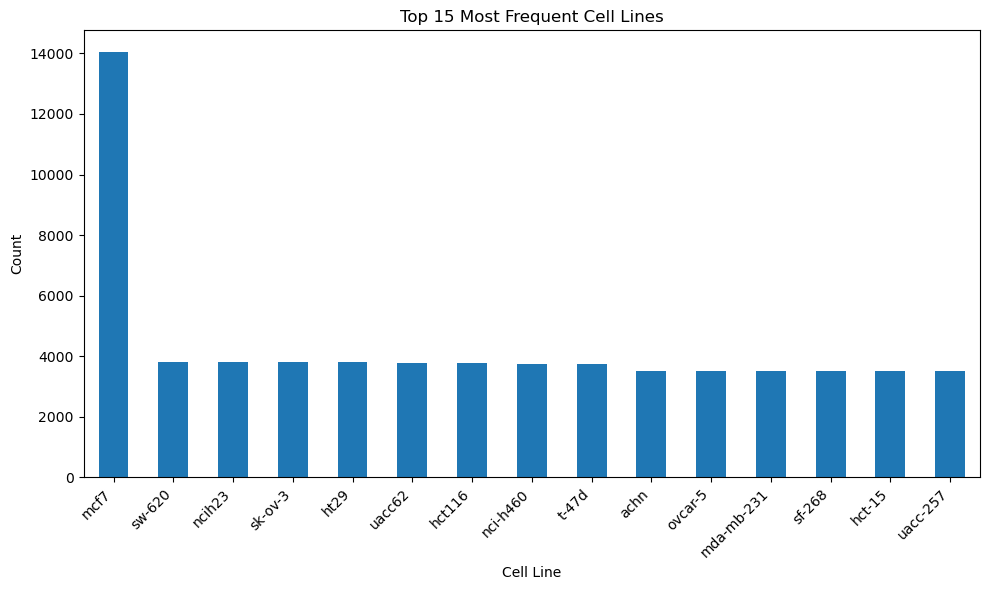


The top 15 cell lines represent 36.76% of the dataset


In [ ]:
print("Most frequent cell lines:")
cell_counts = df["cell_line"].value_counts()
print("Total unique cell lines:", len(cell_counts))

# Display the top 15 most frequent cell lines with their counts
top_15_cell_lines = cell_counts.head(15)
print("\nTop 15 most frequent cell lines:")
for cell_line, count in top_15_cell_lines.items():
    print(f"{cell_line}: {count} occurrences")

# Visualize the distribution
plt.figure(figsize=(10, 6))
top_15_cell_lines.plot(kind='bar')
plt.title('Top 15 Most Frequent Cell Lines')
plt.xlabel('Cell Line')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate percentage of dataset covered by top cell lines
total_samples = len(df)
top_15_coverage = top_15_cell_lines.sum() / total_samples * 100
print(f"\nThe top 15 cell lines represent {top_15_coverage:.2f}% of the dataset")

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
min_fp_pca_0      382
min_fp_pca_1      382
min_fp_pca_2      382
min_fp_pca_3      382
min_fp_pca_4      382
                 ... 
max_fp_pca_123    254
max_fp_pca_124    254
max_fp_pca_125    254
max_fp_pca_126    254
max_fp_pca_127    254
Length: 256, dtype: int64


In [ ]:
print("Antal NaN totalt:", df.isna().sum().sum())
print("Antal nollor totalt:", (df == 0).sum().sum())

# Jämför en specifik kolumn
col = "min_fp_pca_0"
print("NaN i", col, ":", df[col].isna().sum())
print("Nollor i", col, ":", (df[col] == 0).sum())

Antal NaN totalt: 81408
Antal nollor totalt: 174060
NaN i min_fp_pca_0 : 382
Nollor i min_fp_pca_0 : 0


In [ ]:
# mask för rader med NaN i fingerprint-PCA
fp_cols = [c for c in df.columns if c.startswith("min_fp_pca_") or c.startswith("max_fp_pca_")]
mask = df[fp_cols].isna().any(axis=1)

n_missing = mask.sum()
n_total   = len(df)
pct = 100 * n_missing / n_total

print(f"Totalt antal rader: {n_total}")
print(f"Rader utan fingerprints: {n_missing}")
print(f"Andel: {pct:.2f}%")

Totalt antal rader: 178024
Rader utan fingerprints: 615
Andel: 0.35%


In [ ]:
# vilka rader saknar FP-PCA?
mask = df[[c for c in df.columns if c.startswith("min_fp_pca_")]].isna().any(axis=1)
missing = df[mask]

print("Rader utan fingerprints:", len(missing))
print(missing[["drug_min", "drug_max", "cell_line"]].head())

Rader utan fingerprints: 382
                             drug_min      drug_max cell_line
125   (6-)e-<u+200b>aminocaproic acid   717906-29-1     a-673
126   (6-)e-<u+200b>aminocaproic acid   ruxolitinib    l-1236
127   (6-)e-<u+200b>aminocaproic acid  temozolomide      t98g
4894              16-16-dimethyl pge2     pf-431396     a-673
4895              16-16-dimethyl pge2   ruxolitinib    l-1236


In [ ]:
import os

fp_cols = [c for c in df.columns if c.startswith("min_fp_pca_") or c.startswith("max_fp_pca_")]

# mask för rader med NaN i fingerprints
mask_missing = df[fp_cols].isna().any(axis=1)

# subset med rader som ska bort
dropped_rows = df[mask_missing]

# summera vilka drugs som tappas
dropped_summary = (
    dropped_rows[["drug_min", "drug_max"]]
    .melt(value_name="drug")["drug"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "drug", "drug": "count"})
)

print(f"[INFO] Totalt droppade rader: {len(dropped_rows)} ({len(dropped_rows)/len(df)*100:.2f} %)")
print("[INFO] Exkluderade drugs:")
print(dropped_summary)

# spara lista över droppade drugs
out_path = os.path.join("C:/Users/46762/VSCODE/BIG_PHARMA/data/interim", "dropped_drugs.csv")
dropped_summary.to_csv(out_path, index=False)
print(f"[OK] Sparat lista över exkluderade drugs → {out_path}")

# droppa raderna från huvud-df
df = df[~mask_missing].reset_index(drop=True)
print(f"[OK] Ny dataset-shape: {df.shape}")

[INFO] Totalt droppade rader: 615 (0.35 %)
[INFO] Exkluderade drugs:
                                                 count  count
0                                             ak-77283    130
1                                             ak170455    108
2                                          717906-29-1     79
3    2-methoxy-3,17beta-dihydroxyestra-1,3,5(10)-tr...     67
4                                             ac1l2qk3     67
..                                                 ...    ...
193                                      zinc101112865      1
194                                      zinc101426918      1
195                                      zinc103939005      1
196                                       zinc11616261      1
197                             dinaciclib (sch727965)      1

[198 rows x 2 columns]
[OK] Sparat lista över exkluderade drugs → C:/Users/46762/VSCODE/BIG_PHARMA/data/interim\dropped_drugs.csv
[OK] Ny dataset-shape: (177409, 346)


In [ ]:
drop_cols = ["synergy_bliss", "synergy_loewe", "synergy_hsa"]

for col in drop_cols:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"[INFO] Droppade kolumn: {col}")

print(f"[OK] Dataset shape efter drop: {df.shape}")

[INFO] Droppade kolumn: synergy_bliss
[INFO] Droppade kolumn: synergy_loewe
[INFO] Droppade kolumn: synergy_hsa
[OK] Dataset shape efter drop: (177409, 343)


In [ ]:
print(df.describe().T.head(20))  # första features

corr = df.corr(numeric_only=True)["synergy_zip"].sort_values(ascending=False)
print(corr.head(15))
print(corr.tail(15))

                      count         mean          std        min          25%  \
synergy_zip        177409.0    -0.843841     6.056427 -36.846800    -4.300000   
synergy_mean       177409.0    -2.414808     6.319258 -46.431250    -5.292500   
synergy_std        177409.0     5.924942     6.829249   0.000000     2.019097   
cell_id            177409.0    62.604079    32.793004   2.000000    36.000000   
drug_min_id        177409.0  1061.725521   624.117583   0.000000   554.000000   
drug_max_id        177409.0  3239.484665  1321.835538  49.000000  2198.000000   
drug_min_freq      177409.0  4549.947776  1415.836854   1.000000  4020.000000   
drug_max_freq      177409.0  3581.976382  1886.329996   1.000000  2191.000000   
cell_freq          177409.0  4803.103811  1080.786034   5.000000  4973.000000   
drug_min_freq_log  177409.0     8.233352     1.035439   0.693147     8.299286   
drug_max_freq_log  177409.0     7.906157     1.063822   0.693147     7.692570   
cell_freq_log      177409.0 

In [ ]:
drop_target_derivatives = ["synergy_mean", "synergy_binary", "synergy_std"]

for col in drop_target_derivatives:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"[INFO] Droppade target-derivat: {col}")

print(f"[OK] Dataset shape efter drop: {df.shape}")

[INFO] Droppade target-derivat: synergy_mean
[INFO] Droppade target-derivat: synergy_binary
[INFO] Droppade target-derivat: synergy_std
[OK] Dataset shape efter drop: (177409, 340)


In [ ]:
df.describe().T.head(20)   # de första 20 features

count         mean          std        min          25%  \
synergy_zip        177409.0    -0.843841     6.056427 -36.846800    -4.300000   
cell_id            177409.0    62.604079    32.793004   2.000000    36.000000   
drug_min_id        177409.0  1061.725521   624.117583   0.000000   554.000000   
drug_max_id        177409.0  3239.484665  1321.835538  49.000000  2198.000000   
drug_min_freq      177409.0  4549.947776  1415.836854   1.000000  4020.000000   
drug_max_freq      177409.0  3581.976382  1886.329996   1.000000  2191.000000   
cell_freq          177409.0  4803.103811  1080.786034   5.000000  4973.000000   
drug_min_freq_log  177409.0     8.233352     1.035439   0.693147     8.299286   
drug_max_freq_log  177409.0     7.906157     1.063822   0.693147     7.692570   
cell_freq_log      177409.0     8.406780     0.500245   1.791759     8.511980   
min_fp_pca_0       177409.0    -0.611087     1.059278  -3.144477    -1.173092   
min_fp_pca_1       177409.0     0.050307     1.013307  -2.014875    -0.864356   
min_fp_pca_2       177409.0    -0.339383     1.033184  -2.159030    -1.279170   
min_fp_pca_3       177409.0    -0.328272     0.704486  -2.678634    -0.729996   
min_fp_pca_4       177409.0    -0.262998     0.695011  -2.131007    -0.714140   
min_fp_pca_5       177409.0     0.336943     1.094196  -1.963982    -0.413841   
min_fp_pca_6       177409.0     0.136731     0.997527  -1.966612    -0.729419   
min_fp_pca_7       177409.0    -0.023204     0.646721  -1.975915    -0.265465   
min_fp_pca_8       177409.0     0.124042     0.601531  -1.514925    -0.441799   
min_fp_pca_9       177409.0    -0.019374     0.549858  -2.010289    -0.403194   

                           50%          75%          max  
synergy_zip          -1.160000     1.760000    37.677040  
cell_id              60.000000    91.000000   122.000000  
drug_min_id        1030.000000  1657.000000  2247.000000  
drug_max_id        3129.000000  4315.000000  5349.000000  
drug_min_freq      4829.000000  5543.000000  6924.000000  
drug_max_freq      3732.000000  4891.000000  7980.000000  
cell_freq          5051.000000  5097.000000  5619.000000  
drug_min_freq_log     8.482602     8.620472     8.842893  
drug_max_freq_log     8.224967     8.495356     8.984819  
cell_freq_log         8.527539     8.536604     8.634087  
min_fp_pca_0         -0.828407     0.041265     2.597526  
min_fp_pca_1          0.132433     0.708380     2.827476  
min_fp_pca_2         -0.359263     0.284328     2.215087  
min_fp_pca_3         -0.344501     0.199318     2.137824  
min_fp_pca_4         -0.454027    -0.045349     2.813992  
min_fp_pca_5         -0.025701     0.823103     3.281504  
min_fp_pca_6         -0.001846     0.832229     2.586542  
min_fp_pca_7          0.097281     0.454161     2.061964  
min_fp_pca_8          0.069666     0.458056     2.262911  
min_fp_pca_9         -0.136472     0.271422     2.544025

synergy_zip              1.000000
sc_tissue_Lymphoid       0.189875
min_fp_pca_0             0.133732
sc_tissue_Bone           0.124521
min_fp_pca_51            0.107804
min_fp_pca_106           0.087916
min_fp_pca_47            0.087209
sc_tissue_Soft Tissue    0.087171
max_fp_pca_0             0.086999
min_fp_pca_60            0.085903
min_fp_pca_88            0.082373
min_fp_pca_11            0.080525
min_fp_pca_13            0.078982
max_fp_pca_121           0.078799
min_fp_pca_1             0.077444
Name: synergy_zip, dtype: float64
min_fp_pca_5        -0.070302
min_fp_pca_35       -0.070972
min_fp_pca_93       -0.073661
min_fp_pca_10       -0.074421
min_fp_pca_28       -0.075514
max_fp_pca_35       -0.076444
max_fp_pca_23       -0.077840
max_fp_pca_32       -0.078686
min_fp_pca_18       -0.082651
min_fp_pca_7        -0.121649
drug_max_freq_log   -0.160407
cell_freq_log       -0.163152
cell_freq           -0.194213
drug_min_freq       -0.226165
drug_min_freq_log   -0.279780
Name: 

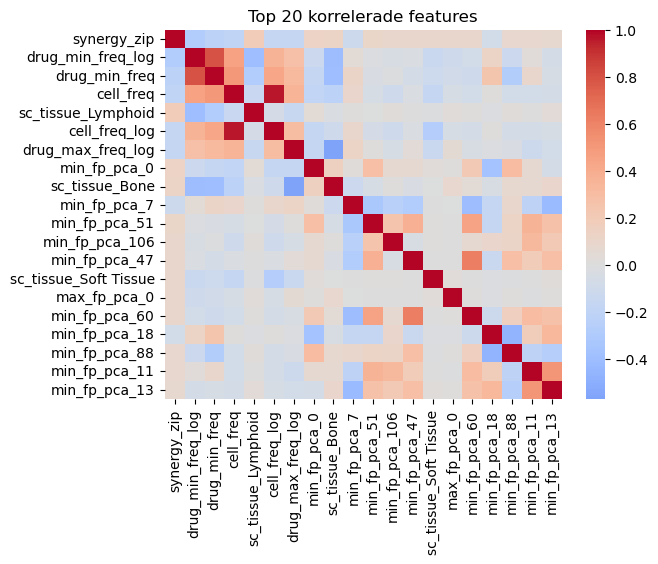

In [ ]:
corr = df.corr(numeric_only=True)["synergy_zip"].sort_values(ascending=False)
print(corr.head(15))
print(corr.tail(15))

top_feats = corr.abs().sort_values(ascending=False).head(20).index
sns.heatmap(df[top_feats].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Top 20 korrelerade features")
plt.show()

### Correlation Analysis — Key Insights
- **Tissue features (`sc_tissue_*`)**: Show the strongest positive correlations with `synergy_zip` (up to ~0.19). This suggests biological relevance — synergy levels differ across tissue types.
- **Fingerprint PCA components (`min_fp_pca_*`, `max_fp_pca_*`)**: Individually weakly correlated (~0.08–0.13), but collectively important. They capture chemical structure information.
- **Frequency features (`drug_min_freq`, `cell_freq`, etc.)**: Negatively correlated (-0.16 to -0.23). This reflects dataset bias — common drugs/cell lines tend to show lower synergy.
- **No single strong driver (>0.2)**: Synergy is multi-factorial and likely requires combining fingerprints, omics, and tissue features for predictive modeling.

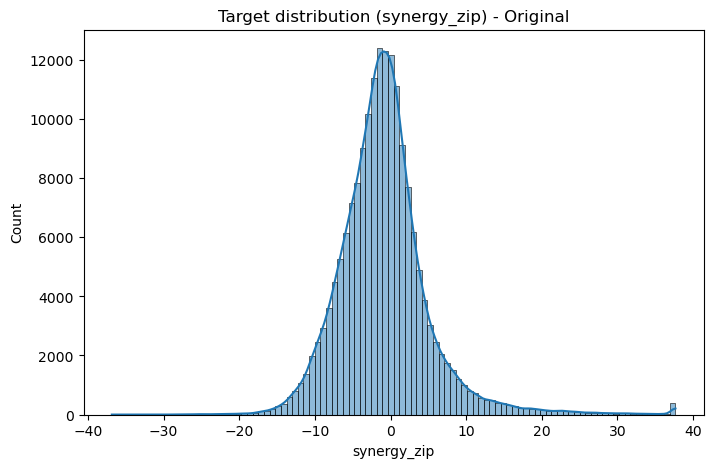

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["synergy_zip"], bins=100, kde=True)
plt.title("Target distribution (synergy_zip) - Original")
plt.xlabel("synergy_zip")
plt.ylabel("Count")
plt.show()

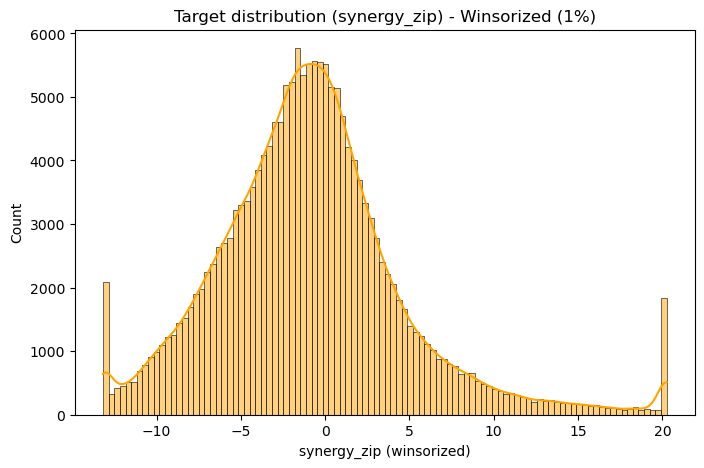

In [ ]:
from scipy.stats.mstats import winsorize

# Winsorize at 1% tails (kan justeras, ex. 0.5%)
winsor_target = winsorize(df["synergy_zip"], limits=[0.01, 0.01])

plt.figure(figsize=(8,5))
sns.histplot(winsor_target, bins=100, kde=True, color="orange")
plt.title("Target distribution (synergy_zip) - Winsorized (1%)")
plt.xlabel("synergy_zip (winsorized)")
plt.ylabel("Count")
plt.show()

### Winsorization of Target Distribution
- **Without winsorization**: The target (`synergy_zip`) shows a sharp peak around 0 but with very long tails (outliers up to ±35–40).
These extreme values can dominate loss functions like MSE and make training unstable.
- **With winsorization (1%)**: The outer 1% of values are clipped, resulting in a more balanced distribution with shorter tails.
This reduces the influence of extreme outliers and often stabilizes model training.
- **Trade-off**: Winsorization improves robustness and generalization but removes information about the most extreme synergy cases.
It is useful for modeling, but important biological outliers may be lost.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# --- parametrar ---
SUBSAMPLE_SIZE = 100000    # justera vid behov
VAL_SIZE = 0.20
MAX_BINS = 5               # börja med 5 kvantiler, minskar vid behov
MIN_PER_CLASS = 2
RANDOM_SEED = 42

# --- förbered data ---
feat_cols = [c for c in df.columns if (
    c.startswith("min_fp_pca_") or
    c.startswith("max_fp_pca_") or
    c.startswith("sc_rna_latent") or
    c.startswith("sc_tissue_") or
    ("freq" in c)
)]
work = df.dropna(subset=feat_cols + ["synergy_zip"]).copy()

strat_cell_col = "cell_line" if "cell_line" in work.columns else ("cell_id" if "cell_id" in work.columns else None)
if strat_cell_col is None:
    work["__cell_fallback__"] = "all"
    strat_cell_col = "__cell_fallback__"

def try_make_splits(work, n_bins):
    # Binna target
    work = work.copy()
    work["synergy_bin"] = pd.qcut(work["synergy_zip"], q=n_bins, labels=False, duplicates="drop")
    # Strat-nyckel
    strat_key = work[strat_cell_col].astype(str) + "|" + work["synergy_bin"].astype(str)

    # 1) Filtrera bort små klasser (<2)
    counts = strat_key.value_counts()
    keep_keys = counts[counts >= MIN_PER_CLASS].index
    kept = strat_key.isin(keep_keys)
    work2 = work.loc[kept].copy()
    strat_key2 = strat_key.loc[kept]

    # Måste fortfarande ha minst 2 per klass efter split → kontrollera train_size vs #klasser
    n_classes = strat_key2.nunique()
    train_size = int((1 - VAL_SIZE) * len(work2))
    if train_size < n_classes:
        return None  # signalera att detta n_bins inte fungerar

    # 2) Global train/val-split med stratifiering
    tr_idx, va_idx = train_test_split(
        work2.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=strat_key2
    )
    train_df = work2.loc[tr_idx].copy()
    val_df   = work2.loc[va_idx].copy()

    # 3) Subsample av train (stratifierat). Om klasser blir för små, fallback till stratifiering på endast synergy_bin.
    sub_size = min(SUBSAMPLE_SIZE, len(train_df))
    sub_key = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))

    # Filtrera igen ifall någon klass blev 1 efter split
    sub_counts = sub_key.value_counts()
    sub_keep = sub_key.isin(sub_counts[sub_counts >= MIN_PER_CLASS].index)
    train_df = train_df.loc[sub_keep].copy()
    sub_key  = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))
    n_classes_sub = sub_key.nunique()

    # Om klasserna fortfarande för många i förhållande till sub_size → försök synergy-bin-stratifiering
    if sub_size < n_classes_sub:
        # Fallback: stratifiera bara på target-bins, men behåll cell-fördelningen hyfsad genom stort sample
        sss = StratifiedShuffleSplit(n_splits=1, train_size=sub_size, random_state=RANDOM_SEED)
        for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
            sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)
    else:
        sub_df, _ = train_test_split(
            train_df,
            train_size=sub_size,
            random_state=RANDOM_SEED,
            stratify=sub_key
        )
        sub_df = sub_df.reset_index(drop=True)

    return sub_df, val_df, n_bins, work2

# Försök med MAX_BINS → minska tills det fungerar
result = None
for nb in range(MAX_BINS, 1, -1):
    result = try_make_splits(work, nb)
    if result is not None:
        sub_df, val_df, used_bins, filtered_work = result
        print(f"[INFO] Strat OK med n_bins={used_bins} | train_sub={len(sub_df):,} | val={len(val_df):,} | efter filtrering: {len(filtered_work):,}")
        break

if result is None:
    # Sista fallback: stratifiera endast på target-bins, ignorera cell i stratifiering
    print("[WARN] Kunde inte stratifiera på cell|bin. Fallback: endast target-bins.")
    work["synergy_bin"] = pd.qcut(work["synergy_zip"], q=3, labels=False, duplicates="drop")
    tr_idx, va_idx = train_test_split(
        work.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=work["synergy_bin"]
    )
    train_df = work.loc[tr_idx].copy()
    val_df   = work.loc[va_idx].copy()

    sss = StratifiedShuffleSplit(n_splits=1, train_size=min(SUBSAMPLE_SIZE, len(train_df)), random_state=RANDOM_SEED)
    for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
        sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)

print(f"[OK] Train SUB shape: {sub_df.shape} | VAL shape: {val_df.shape}")

# Packa matriser för efterföljande celler
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

[INFO] Strat OK med n_bins=5 | train_sub=100,000 | val=35,481 | efter filtrering: 177,405
[OK] Train SUB shape: (100000, 341) | VAL shape: (35481, 341)


In [ ]:
import pandas as pd

# avgör cell-kolumn
cell_col = "cell_line" if "cell_line" in sub_df.columns else ("cell_id" if "cell_id" in sub_df.columns else None)

def show_dist(title, frame):
    print(f"\n=== {title} ===")
    # synergy bins
    if "synergy_bin" in frame.columns:
        print("[synergy_bin] dist (%):")
        print((frame["synergy_bin"].value_counts(normalize=True).sort_index() * 100).round(2))
    else:
        print("[WARN] 'synergy_bin' saknas i ramen.")
    # cell dist
    if cell_col is not None:
        print("\n[Cell] top-15 dist (%):")
        print((frame[cell_col].value_counts(normalize=True).head(15) * 100).round(2))
    else:
        print("[INFO] Ingen cell-kolumn hittad (cell_line/cell_id).")

    # kors-tabell cell x bin (top-10 celler för översikt)
    if cell_col is not None and "synergy_bin" in frame.columns:
        top_cells = frame[cell_col].value_counts().head(10).index
        ctab = (frame[frame[cell_col].isin(top_cells)]
                .pivot_table(index=cell_col, columns="synergy_bin", aggfunc="size", fill_value=0))
        ctab_pct = (ctab.div(ctab.sum(axis=1), axis=0) * 100).round(1)
        print("\n[Cell x synergy_bin] (%) för topp-10 celler:")
        display(ctab_pct)

show_dist("SUBSAMPLE (train)", sub_df)
show_dist("VALIDATION (val)", val_df)

print(f"\n[INFO] Shapes → sub_df: {sub_df.shape} | val_df: {val_df.shape}")


=== SUBSAMPLE (train) ===
[synergy_bin] dist (%):
synergy_bin
0    20.01
1    20.00
2    20.07
3    19.92
4    19.99
Name: proportion, dtype: float64

[Cell] top-15 dist (%):
cell_line
mcf7          7.93
sw-620        2.15
ncih23        2.15
sk-ov-3       2.15
ht29          2.14
hct116        2.13
uacc62        2.13
nci-h460      2.12
t-47d         2.12
ovcar-5       1.98
achn          1.98
mda-mb-231    1.98
uacc-257      1.98
sf-268        1.98
sk-mel-28     1.98
Name: proportion, dtype: float64

[Cell x synergy_bin] (%) för topp-10 celler:


synergy_bin     0     1     2     3     4
cell_line                                
hct116       14.4  20.1  21.5  21.5  22.4
ht29         15.9  15.7  18.7  24.3  25.4
mcf7         25.7  19.7  20.1  18.9  15.6
nci-h460     10.8  17.4  21.0  28.3  22.5
ncih23       20.3  22.8  23.2  20.4  13.4
ovcar-5      24.9  21.1  20.5  20.7  12.8
sk-ov-3      16.8  23.4  21.0  20.8  17.9
sw-620       18.0  17.7  20.8  22.6  20.9
t-47d        21.6  20.7  20.5  19.5  17.8
uacc62       24.6  22.0  23.8  16.6  12.9


=== VALIDATION (val) ===
[synergy_bin] dist (%):
synergy_bin
0    20.01
1    20.00
2    20.07
3    19.93
4    19.99
Name: proportion, dtype: float64

[Cell] top-15 dist (%):
cell_line
mcf7          7.92
sw-620        2.16
ncih23        2.15
sk-ov-3       2.14
ht29          2.14
uacc62        2.13
hct116        2.13
nci-h460      2.12
t-47d         2.12
achn          1.98
hct-15        1.98
ovcar-5       1.98
sf-268        1.98
mda-mb-231    1.98
uacc-257      1.98
Name: proportion, dtype: float64

[Cell x synergy_bin] (%) för topp-10 celler:


synergy_bin     0     1     2     3     4
cell_line                                
achn         18.6  21.4  23.0  20.9  16.1
hct116       14.3  20.1  21.6  21.6  22.5
ht29         15.8  15.8  18.7  24.3  25.4
mcf7         25.8  19.7  20.1  18.9  15.5
nci-h460     10.8  17.4  21.0  28.3  22.5
ncih23       20.3  22.8  23.2  20.3  13.4
sk-ov-3      16.8  23.5  21.0  20.8  17.9
sw-620       18.0  17.6  20.8  22.6  20.9
t-47d        21.7  20.6  20.5  19.4  17.8
uacc62       24.6  22.0  23.8  16.7  13.0


[INFO] Shapes → sub_df: (100000, 341) | val_df: (35481, 341)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Bygg matriser (om du inte redan har dem från tidigare cell)
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3,
    random_state=42
)
hgb.fit(X_sub, y_sub)

pred_val = hgb.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val)
rmse = float(np.sqrt(np.mean((y_val - pred_val)**2)))
r2   = r2_score(y_val, pred_val)
r    = float(np.corrcoef(y_val, pred_val)[0,1])
print(f"[HistGBR] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# Permutation importance på VAL (mer ärlig bild)
perm = permutation_importance(hgb, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1)
imp_hgb_perm = pd.Series(perm.importances_mean, index=feat_cols).clip(lower=0)
imp_hgb_perm_n = imp_hgb_perm / (imp_hgb_perm.max() + 1e-12)

topN = 20
top_feats_hgb = imp_hgb_perm_n.sort_values(ascending=False).head(topN)

plt.figure(figsize=(9, 7))
top_feats_hgb.iloc[::-1].plot(kind="barh")
plt.title("HistGBR Permutation Importance (on validation) — Top 20")
plt.xlabel("Normalized importance")
plt.tight_layout()
plt.show()

# spara artefakter för RF-jämförelse
_hist_importance_val_norm = imp_hgb_perm_n

[HistGBR] Val MAE=3.269 | RMSE=4.642 | R2=0.412 | r=0.644


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rf = RandomForestRegressor(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)
rf.fit(X_sub, y_sub)

pred_val_rf = rf.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val_rf)
rmse = float(np.sqrt(np.mean((y_val - pred_val_rf)**2)))
r2   = r2_score(y_val, pred_val_rf)
r    = float(np.corrcoef(y_val, pred_val_rf)[0,1])
print(f"[RandomForest] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# RF-importance (Gini/split)
imp_rf_gini = pd.Series(rf.feature_importances_, index=feat_cols).clip(lower=0)
imp_rf_gini_n = imp_rf_gini / (imp_rf_gini.max() + 1e-12)

# Sida-vid-sida mot HistGBR-permutation
avg_rank = (_hist_importance_val_norm + imp_rf_gini_n) / 2.0
topN = 20
top_feats = avg_rank.sort_values(ascending=False).head(topN).index.tolist()

plot_df = pd.DataFrame({
    "Feature": top_feats,
    "HistGBR (perm, val)": _hist_importance_val_norm[top_feats].values,
    "RandomForest (gini)": imp_rf_gini_n[top_feats].values
}).set_index("Feature")

plt.figure(figsize=(10, 8))
ys = np.arange(len(top_feats))
bar_w = 0.4
plt.barh(ys - bar_w/2, plot_df["HistGBR (perm, val)"], height=bar_w, label="HistGBR (perm, val)")
plt.barh(ys + bar_w/2, plot_df["RandomForest (gini)"], height=bar_w, label="RandomForest (gini)")
plt.yticks(ys, top_feats)
plt.xlabel("Normalized importance")
plt.title("Top 20 importances — HistGBR vs RandomForest (same train/val)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# tabell
cmp_table = plot_df.copy()
cmp_table["Avg"] = (cmp_table.iloc[:,0] + cmp_table.iloc[:,1]) / 2.0
display(cmp_table.sort_values("Avg", ascending=False))

: 

In [ ]:
# Requirements: umap-learn, tqdm, matplotlib, scikit-learn (optional for trustworthiness)
# Uses: sub_df, val_df, feat_cols

import os, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    from umap import UMAP
except ImportError as e:
    raise ImportError("Please install umap-learn first: pip install umap-learn") from e

# (Optional) metrics
try:
    from sklearn.manifold import trustworthiness
    HAS_TRUST = True
except Exception:
    HAS_TRUST = False

# -------------------- CONFIG --------------------
OUT_DIR = Path(r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\umap_single_cpu")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
N_NEIGHBORS = 20
MIN_DIST    = 0.20
METRIC      = "cosine"   # "cosine" | "euclidean" | "correlation" (via numba)
CMAP        = "viridis"
PLOT_SAMPLE = 30000      # cap points for lighter PNGs

# -------------------- DATA ----------------------
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)

y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

# -------------------- UMAP (CPU) ----------------
pbar = tqdm(total=4, desc="CPU UMAP", unit="step")
t0 = time.perf_counter()

# 1) Fit on train/subsample only
umap_model = UMAP(
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    n_components=2,
    metric=METRIC,
    random_state=RANDOM_STATE,
    low_memory=True,   # helps on larger datasets
    verbose=False      # tqdm will be our progress indicator
)
Z_sub = umap_model.fit_transform(X_sub)
pbar.set_postfix_str("fit done")
pbar.update(1)

# 2) Transform validation
Z_val = umap_model.transform(X_val)
pbar.set_postfix_str("transform done")
pbar.update(1)

# 3) Save embeddings
emb_train = pd.DataFrame(Z_sub, columns=["z1","z2"], dtype=np.float32)
emb_train["split"] = "train"
emb_train["synergy_zip"] = y_sub

emb_val = pd.DataFrame(Z_val, columns=["z1","z2"], dtype=np.float32)
emb_val["split"] = "val"
emb_val["synergy_zip"] = y_val

embs = pd.concat([emb_train, emb_val], ignore_index=True)
emb_path = OUT_DIR / f"umap_cpu_{METRIC}_n{N_NEIGHBORS}_d{MIN_DIST:.2f}_embeddings.csv"
embs.to_csv(emb_path, index=False)
pbar.set_postfix_str("saved embeddings")
pbar.update(1)

# 4) Plot (train + val) colored by synergy_zip
rng = np.random.RandomState(0)
idx_tr = rng.choice(len(Z_sub), size=min(PLOT_SAMPLE//2, len(Z_sub)), replace=False)
idx_va = rng.choice(len(Z_val), size=min(PLOT_SAMPLE//2, len(Z_val)), replace=False)

plt.figure(figsize=(8.5, 7))
plt.scatter(Z_sub[idx_tr,0], Z_sub[idx_tr,1], c=y_sub[idx_tr], s=5, alpha=0.7, cmap=CMAP, label="train/sub")
plt.scatter(Z_val[idx_va,0], Z_val[idx_va,1], c=y_val[idx_va], s=7, alpha=0.9, cmap=CMAP, marker="^", label="val")
plt.title(f"UMAP (CPU, {METRIC}) — n={N_NEIGHBORS}, d={MIN_DIST}")
cbar = plt.colorbar(); cbar.set_label("synergy_zip")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
fig_path = OUT_DIR / f"umap_cpu_{METRIC}_n{N_NEIGHBORS}_d{MIN_DIST:.2f}.png"
plt.savefig(fig_path, dpi=160)
plt.show()
pbar.set_postfix_str("plotted")
pbar.update(1)

pbar.close()
t1 = time.perf_counter()
print(f"[OK] Embeddings: {emb_path}")
print(f"[OK] Figure:     {fig_path}")
print(f"[INFO] Elapsed:  {t1 - t0:.1f}s")

# -------------------- OPTIONAL: quick trustworthiness --------------------
if HAS_TRUST:
    try:
        trust_tr  = float(trustworthiness(X_sub, Z_sub, n_neighbors=15, metric="euclidean"))
        trust_val = float(trustworthiness(X_val, Z_val, n_neighbors=15, metric="euclidean"))
        print(f"[Trustworthiness] train={trust_tr:.3f} | val={trust_val:.3f}")
    except Exception as e:
        print(f"[WARN] Trustworthiness failed: {e}")
else:
    print("[NOTE] Install scikit-learn to compute trustworthiness (optional).")

: 

In [ ]:
# Example: top 1% high synergy
top = val_df[val_df["synergy_zip"] > np.percentile(val_df["synergy_zip"], 99)]
print(top[["drug_min", "drug_max", "cell_id", "synergy_zip"]].head(20))

: 

In [ ]:
md = f"""
## UMAP Embedding Results

För att undersöka den latenta strukturen i features (fingerprint-PCA, RNA-latenter, frekvensvariabler) användes **UMAP** med följande parametrar:

- **n_neighbors** = 20  
- **min_dist** = 0.20  
- **metric** = cosine  

Resultaten visar en 2D-projektion av drug-combinationer, färglagda efter deras `synergy_zip`-score.

![UMAP embedding](4a6def58-67dd-496e-9859-74e0f7a98d77.png)

### Trustworthiness

För att utvärdera embeddingens kvalitet beräknades **trustworthiness**, vilket mäter hur väl lokala grannar i det högdimensionella rummet bevaras i 2D:

| Dataset        | Trustworthiness |
|----------------|-----------------|
| Train/Subsample | **0.969** |
| Validation      | **0.970** |

> **Tolkning:** Värden nära 1.0 innebär mycket hög kvalitet. Här visar både train och val att UMAP bevarar de lokala relationerna väl, vilket betyder att strukturen i 2D kan tolkas med hög tillförlitlighet.

### Nästa steg

- Utför **KMeans eller HDBSCAN** på UMAP-embeddingarna för att identifiera kluster.  
- Analysera medelvärden av `synergy_zip` inom kluster för att se om vissa grupper tenderar mot högre/lägre synergieffekter.  
- Visualisera med färgkodning efter cellinje eller specifika drugs för att upptäcka biologiskt relevanta mönster.
"""

print(md)

: 

In [ ]:
# Requirements: scikit-learn, matplotlib, pandas, numpy
# Assumes you already have Z_val (numpy array of shape [n_samples, 2])
# and val_df with synergy_zip, synergy_bin etc.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------- CONFIG --------------------
K_RANGE = range(2, 15)   # test k = 2..14
RANDOM_STATE = 42

# -------------------- DATA ----------------------
# If you saved embs.csv earlier, load instead:
# embs = pd.read_csv(".../umap_cpu_cosine_n20_d0.20_embeddings.csv")
# Z_val = embs[embs["split"]=="val"][["z1","z2"]].to_numpy()
# y_val = embs[embs["split"]=="val"]["synergy_zip"].to_numpy()

Z_val = Z_val  # from your earlier UMAP cell
y_val = val_df["synergy_zip"].to_numpy()

# -------------------- LOOP OVER k ----------------
sil_scores = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(Z_val)
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(Z_val, labels)
        sil_scores.append(sil)
    else:
        sil_scores.append(np.nan)

# -------------------- PLOT -----------------------
plt.figure(figsize=(7,5))
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.title("KMeans silhouette on UMAP embeddings (val)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

# -------------------- BEST k ---------------------
best_k = K_RANGE[int(np.nanargmax(sil_scores))]
best_sil = np.nanmax(sil_scores)
print(f"[KMeans] Best silhouette={best_sil:.3f} at k={best_k}")

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -------------------- CONFIG --------------------
TOP_Q = 99   # take top 1% synergy
BEST_K = 3   # from silhouette analysis

# -------------------- LOAD DATA -----------------
# If you already have embeddings in memory:
# Z_val = ... (numpy array, shape [n_val, 2])
# y_val = val_df["synergy_zip"].to_numpy()

# Cluster with chosen k
km = KMeans(n_clusters=BEST_K, n_init=10, random_state=42)
labels = km.fit_predict(Z_val)

# Attach cluster labels to val_df for analysis
val_df_ = val_df.copy()
val_df_["cluster"] = labels
val_df_["z1"] = Z_val[:,0]
val_df_["z2"] = Z_val[:,1]

# -------------------- TOP SYNERGY -----------------
thr = np.percentile(y_val, TOP_Q)
top_synergy = val_df_[val_df_["synergy_zip"] >= thr]

print(f"[INFO] Top {100-TOP_Q:.1f}% synergy threshold: {thr:.2f}")
print(f"[INFO] {len(top_synergy)} / {len(val_df_)} validation points selected.")

# Show which clusters contain the most high-synergy points
cluster_counts = top_synergy["cluster"].value_counts(normalize=True) * 100
print("\n% of top synergy points per cluster:")
print(cluster_counts.round(2))

# -------------------- VISUALIZE -----------------
plt.figure(figsize=(8,7))
plt.scatter(val_df_["z1"], val_df_["z2"], c="lightgray", s=5, alpha=0.4, label="all points")
plt.scatter(top_synergy["z1"], top_synergy["z2"], c=top_synergy["synergy_zip"],
            cmap="viridis", s=12, alpha=0.9, label="top synergy")
plt.colorbar(label="synergy_zip (top points only)")
plt.title(f"Top {100-TOP_Q:.1f}% synergy points overlayed (k={BEST_K})")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# -------------------- SUMMARY TABLE -----------------
summary = (
    top_synergy.groupby("cluster")["synergy_zip"]
    .agg(["count","mean","median","max"])
    .sort_values("mean", ascending=False)
)
print("\nCluster-level summary of top synergy points:")
print(summary)

: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
scatter = plt.scatter(val_df_["z1"], val_df_["z2"], 
                      c=val_df_[cell_col].astype("category").cat.codes, 
                      cmap="tab20", s=6, alpha=0.8)
plt.title("UMAP colored by cell line")
plt.colorbar(scatter, label="cell line code")
plt.tight_layout()
plt.show()
print("Two significant clusters identified to the south, rest of celline evenly clustered")

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN

# -------------------- CONFIG --------------------
# UMAP coordinates source
USE_Z_FROM_MEMORY = True   # if False, will read from val_df['z1','z2']
# DBSCAN params (tune eps if islands are too split/merged)
EPS = 0.5
MIN_SAMPLES = 20
# Define top synergy band (percentile threshold inside each island and globally)
TOP_Q_GLOBAL = 95

# -------------------- DATA ----------------------
assert "val_df" in globals(), "val_df not found."
val_df_ = val_df.copy()

# attach embedding
if USE_Z_FROM_MEMORY and "Z_val" in globals():
    val_df_["z1"] = Z_val[:, 0]
    val_df_["z2"] = Z_val[:, 1]
else:
    assert all(c in val_df_.columns for c in ["z1", "z2"]), "Need z1,z2 or Z_val."
    
X2 = val_df_[["z1", "z2"]].to_numpy(np.float32)
y  = val_df_["synergy_zip"].to_numpy(np.float32)

# helper to pick cell line column
cell_col = "cell_line" if "cell_line" in val_df_.columns else ("cell_id" if "cell_id" in val_df_.columns else None)

# -------------------- CLUSTERING ----------------
# DBSCAN finds dense "islands" in 2D space; -1 = noise
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
labels = db.fit_predict(X2)
val_df_["island"] = labels

n_islands = int(val_df_["island"].nunique() - (1 if -1 in labels else 0))
print(f"[INFO] DBSCAN islands found: {n_islands} (label -1 is noise)")

# -------------------- ISLAND SUMMARY ----------------
# global top threshold
thr_global = np.percentile(y, TOP_Q_GLOBAL)

def top_pairs(df, k=10):
    # Normalize pair name order for counting (sorted tokens)
    # If your dataset already has consistent min/max order, this still works.
    key = df.apply(lambda r: " / ".join(sorted([str(r.get("drug_min","?")), str(r.get("drug_max","?"))])), axis=1)
    return key.value_counts().head(k)

rows = []
for isl, g in val_df_.groupby("island"):
    if isl == -1:  # skip noise in main summary, but you can include if you want
        continue
    cnt = len(g)
    mean = g["synergy_zip"].mean()
    med  = g["synergy_zip"].median()
    mx   = g["synergy_zip"].max()

    # composition by cell line
    top_cell = None
    top_cell_share = np.nan
    if cell_col is not None and cnt > 0:
        counts = g[cell_col].value_counts()
        top_cell = counts.idxmax()
        top_cell_share = float(counts.iloc[0]) / cnt

    # fraction of global top synergy inside island
    frac_top_global = float((g["synergy_zip"] >= thr_global).mean())

    rows.append({
        "island": isl, "count": cnt,
        "mean_synergy": mean, "median_synergy": med, "max_synergy": mx,
        "top_cell": top_cell, "top_cell_share": top_cell_share,
        f"frac_top{100-TOP_Q_GLOBAL:.0f}%_global": frac_top_global
    })

summary = pd.DataFrame(rows).sort_values(["mean_synergy","count"], ascending=[False, False])
print("\n=== Island summary (sorted by mean synergy then size) ===")
print(summary.head(15).to_string(index=False))

# -------------------- PLOT: highlight top-N islands by mean synergy ----------------
TOP_N = min(5, len(summary))
top_islands = summary.head(TOP_N)["island"].tolist()

plt.figure(figsize=(9,7))
# background: all points as light gray
plt.scatter(val_df_["z1"], val_df_["z2"], c="lightgray", s=5, alpha=0.35, label="all (incl. noise)")

# overlay each top island with distinct color
cmap = plt.get_cmap("tab10")
for i, isl in enumerate(top_islands):
    gi = val_df_[val_df_["island"] == isl]
    plt.scatter(gi["z1"], gi["z2"], s=10, alpha=0.95, color=cmap(i % 10), label=f"island {isl} (n={len(gi)})")

plt.title(f"UMAP islands via DBSCAN (eps={EPS}, min_samples={MIN_SAMPLES}) — top {TOP_N} by mean synergy")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()

# -------------------- DEEP DIVE: top islands — drug pairs & cell composition ----------------
for isl in top_islands:
    gi = val_df_[val_df_["island"] == isl].copy()
    print(f"\n--- Island {isl} (n={len(gi)}) ---")
    print(gi["synergy_zip"].describe()[["mean","50%","max"]].rename({"50%":"median"}))

    # top cell lines
    if cell_col is not None:
        cell_tbl = gi[cell_col].value_counts(normalize=True).head(10) * 100
        print("\nTop cell lines (%):")
        print(cell_tbl.round(2))

    # top drug pairs overall
    if {"drug_min","drug_max"}.issubset(gi.columns):
        top10 = top_pairs(gi[["drug_min","drug_max"]], k=10)
        print("\nTop 10 drug pairs (count):")
        print(top10)

    # top synergy subset inside this island (e.g., island-specific 95th percentile)
    thr_island = np.percentile(gi["synergy_zip"], 95)
    gi_top = gi[gi["synergy_zip"] >= thr_island]
    print(f"\nIsland-specific top 5% synergy threshold: {thr_island:.2f} (n={len(gi_top)})")
    if len(gi_top) > 0 and {"drug_min","drug_max"}.issubset(gi.columns):
        print("Top drug pairs among island-top synergy:")
        print(top_pairs(gi_top[["drug_min","drug_max"]], k=10))

: 

In [ ]:
import pandas as pd

assert "val_df_" in globals(), "Run DBSCAN cell first to get val_df_ with 'island'."

def top_pairs(df, k=10):
    """Return top-k drug pair counts (normalized order)."""
    if not {"drug_min","drug_max"}.issubset(df.columns):
        return pd.Series(dtype=int)
    keys = df.apply(lambda r: " / ".join(sorted([str(r["drug_min"]), str(r["drug_max"])])), axis=1)
    return keys.value_counts().head(k)

# collect summaries
island_summaries = {}

for isl, g in val_df_.groupby("island"):
    if isl == -1:  # skip noise cluster
        continue
    n = len(g)
    mean = g["synergy_zip"].mean()
    med  = g["synergy_zip"].median()
    mx   = g["synergy_zip"].max()

    # top cell lines
    if "cell_line" in g.columns:
        cell_tbl = (g["cell_line"].value_counts(normalize=True).head(5) * 100).round(2)
    elif "cell_id" in g.columns:
        cell_tbl = (g["cell_id"].value_counts(normalize=True).head(5) * 100).round(2)
    else:
        cell_tbl = pd.Series(dtype=float)

    # top drug pairs
    pairs = top_pairs(g, k=10)

    island_summaries[isl] = {
        "count": n,
        "mean_synergy": mean,
        "median_synergy": med,
        "max_synergy": mx,
        "top_cells_%": cell_tbl.to_dict(),
        "top_pairs": pairs.to_dict()
    }

# print results
for isl, info in island_summaries.items():
    print(f"\n=== Island {isl} (n={info['count']}) ===")
    print(f"mean={info['mean_synergy']:.3f} | median={info['median_synergy']:.3f} | max={info['max_synergy']:.3f}")

    print("\nTop cell lines (%):")
    if info["top_cells_%"]:
        for c, v in info["top_cells_%"].items():
            print(f"  {c:15s} {v:5.2f}%")
    else:
        print("  [no cell line info]")

    print("\nTop drug pairs:")
    if info["top_pairs"]:
        for p, cnt in info["top_pairs"].items():
            print(f"  {p:40s} {cnt}")
    else:
        print("  [no drug pair info]")

: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ---------- Preconditions ----------
# Expect: Z_sub, Z_val, sub_df, val_df, feat_cols already defined from your UMAP cell
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing. Run UMAP + data prep first."

# ---------- 1) DBSCAN on TRAIN ONLY (avoid leakage) ----------
def pick_eps_auto(Z, frac=0.002, k_min=5, k_max=15):
    """Heuristic eps: median distance to k-th NN in 2D."""
    k = np.clip(int(frac * len(Z)), k_min, k_max)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(Z)
    dists, _ = nn.kneighbors(Z)
    return float(np.median(dists[:, -1]))

Ztr = Z_sub.astype(np.float32, copy=False)
eps = pick_eps_auto(Ztr, frac=0.002, k_min=5, k_max=12)
min_samples = max(15, int(0.0015 * len(Ztr)))

db = DBSCAN(eps=eps, min_samples=min_samples)
train_labels = db.fit_predict(Ztr)              # -1 = noise
sub_df_ = sub_df.copy()
sub_df_["island"] = train_labels
print(f"[INFO] DBSCAN train: eps={eps:.3f}, min_samples={min_samples}, islands={sub_df_['island'].nunique() - (1 if -1 in train_labels else 0)}")

# ---------- 2) Propagate labels to VALIDATION ----------
# Use core points from train as reference; assign val to nearest core within eps; else -1
core_mask = np.zeros(len(Ztr), dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = Ztr[core_mask]
core_labels = train_labels[core_mask]

if len(core_points) == 0:
    raise RuntimeError("No core points found by DBSCAN. Increase sample size or adjust eps/min_samples.")

nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)
dist, idx = nbrs.kneighbors(Z_val.astype(np.float32, copy=False))
dist = dist.ravel()
idx = idx.ravel()
val_labels = np.where(dist <= eps, core_labels[idx], -1)

val_df_ = val_df.copy()
val_df_["island"] = val_labels

# ---------- 3) Rank islands by train mean synergy (or use your own scoring) ----------
isum = (sub_df_.loc[sub_df_["island"]!=-1]
        .groupby("island")["synergy_zip"]
        .agg(["count","mean","median","max"])
        .sort_values(["mean","count"], ascending=[False, False]))
top_islands = isum.head(3).index.tolist()
print("\n[INFO] Top islands by train mean synergy:", top_islands)
display(isum.head(10))

# ---------- 4) Train one regressor per island ----------
def evaluate_model(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2 = r2_score(yva, pred)
    r  = float(np.corrcoef(yva, pred)[0,1]) if len(yva) > 1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "r": r}

# Global baseline on the same feature set (for comparison)
X_sub_all = sub_df_[feat_cols].fillna(0).to_numpy(np.float32)
y_sub_all = sub_df_["synergy_zip"].to_numpy(np.float32)
X_val_all = val_df_[feat_cols].fillna(0).to_numpy(np.float32)
y_val_all = val_df_["synergy_zip"].to_numpy(np.float32)

hgb_global = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
print("\n=== Global baseline ===")
global_metrics = evaluate_model(hgb_global, X_sub_all, y_sub_all, X_val_all, y_val_all, "Global")

# Per-island models
per_island_metrics = {}
feature_importances = {}

for isl in top_islands:
    tr_mask = (sub_df_["island"] == isl)
    va_mask = (val_df_["island"] == isl)

    Xtr = sub_df_.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_df_.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_df_.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_df_.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    if len(Xtr) < 200 or len(Xva) < 50:
        print(f"[WARN] Island {isl}: too few samples (train={len(Xtr)}, val={len(Xva)}). Results may be unstable.")

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=400,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    print(f"\n=== Island {isl} model (train n={len(Xtr)}, val n={len(Xva)}) ===")
    per_island_metrics[isl] = evaluate_model(model, Xtr, ytr, Xva, yva, f"Island {isl}")

    # Permutation importance on validation (optional; costs time)
    try:
        from sklearn.inspection import permutation_importance
        perm = permutation_importance(model, Xva, yva, n_repeats=5, random_state=42, n_jobs=-1)
        imp = pd.Series(perm.importances_mean, index=feat_cols).clip(lower=0).sort_values(ascending=False).head(20)
        feature_importances[isl] = imp
        print(f"[Island {isl}] Top features:")
        display(imp)
    except Exception as e:
        print(f"[WARN] Permutation importance failed for island {isl}: {e}")

# ---------- 5) Compare metrics ----------
print("\n=== Summary: metrics (per island vs global) ===")
summary_rows = [{"island":"Global", **global_metrics}]
for isl in top_islands:
    row = per_island_metrics[isl].copy()
    row["island"] = isl
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows).set_index("island")
display(summary_df)

# (Optional) Save results
# summary_df.to_csv("island_regression_metrics.csv", index=True)

: 

In [ ]:
# Assumes: sub_df, val_df, feat_cols present from your pipeline.
# Comments in ENGLISH.

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# ------------------------- 1) Column groups -------------------------
min_fp_cols = [c for c in feat_cols if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in feat_cols if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in feat_cols if c.startswith("sc_rna_latent")]
freq_cols   = [c for c in feat_cols if ("freq" in c and c not in min_fp_cols + max_fp_cols + rna_cols)]

assert len(min_fp_cols) > 0 and len(max_fp_cols) > 0 and len(rna_cols) > 0, \
    "Expected PCA fingerprint cols (min_/max_fp_pca_*) and RNA latents (sc_rna_latent*)."

# ------------------------- 2) Build numpy + scaling -------------------------
def to_np(df):
    X_min = df[min_fp_cols].fillna(0).to_numpy(np.float32)
    X_max = df[max_fp_cols].fillna(0).to_numpy(np.float32)
    X_rna = df[rna_cols].fillna(0).to_numpy(np.float32)
    X_frq = df[freq_cols].fillna(0).to_numpy(np.float32) if len(freq_cols) else None
    y     = df["synergy_zip"].to_numpy(np.float32)
    return X_min, X_max, X_rna, X_frq, y

Xmin_tr, Xmax_tr, Xrna_tr, Xfrq_tr, y_tr = to_np(sub_df)
Xmin_va, Xmax_va, Xrna_va, Xfrq_va, y_va = to_np(val_df)

sc_min = StandardScaler().fit(Xmin_tr)
sc_max = StandardScaler().fit(Xmax_tr)
sc_rna = StandardScaler().fit(Xrna_tr)
sc_frq = StandardScaler().fit(Xfrq_tr) if Xfrq_tr is not None else None

Xmin_tr = sc_min.transform(Xmin_tr); Xmin_va = sc_min.transform(Xmin_va)
Xmax_tr = sc_max.transform(Xmax_tr); Xmax_va = sc_max.transform(Xmax_va)
Xrna_tr = sc_rna.transform(Xrna_tr); Xrna_va = sc_rna.transform(Xrna_va)
if Xfrq_tr is not None:
    Xfrq_tr = sc_frq.transform(Xfrq_tr); Xfrq_va = sc_frq.transform(Xfrq_va)

# ------------------------- 3) Model (three-tower with shared drug encoder) -------------------------
def build_shared_drug_encoder(input_dim, width=256, depth=2, name="drug_enc"):
    """Small MLP used for BOTH min/max fingerprints (shared weights)."""
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

def build_cell_encoder(input_dim, width=256, depth=2, name="cell_enc"):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

# Inputs
inp_min = keras.Input(shape=(Xmin_tr.shape[1],), name="min_fp")
inp_max = keras.Input(shape=(Xmax_tr.shape[1],), name="max_fp")
inp_rna = keras.Input(shape=(Xrna_tr.shape[1],), name="rna")
inp_frq = keras.Input(shape=(Xfrq_tr.shape[1],), name="freq") if Xfrq_tr is not None else None

# Encoders
drug_enc = build_shared_drug_encoder(Xmin_tr.shape[1], width=256, depth=2, name="drug_enc")  # shared
cell_enc = build_cell_encoder(Xrna_tr.shape[1], width=256, depth=2, name="cell_enc")

z_min = drug_enc(inp_min)  # shared weights for min
z_max = drug_enc(inp_max)  # shared weights for max
z_rna = cell_enc(inp_rna)

# Core interactions capturing "complementarity" and "context-matching"
abs_diff   = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([z_min, z_max])   # |A-B|
hadamard   = layers.Multiply()([z_min, z_max])                                 # A ⊙ B
pair_sum   = layers.Add()([z_min, z_max])                                      # A + B
pair_cell  = layers.Multiply()([pair_sum, z_rna])                              # (A+B) ⊙ Cell
pair_match = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([pair_sum, z_rna])# |(A+B)-Cell|

blocks = [z_min, z_max, abs_diff, hadamard, z_rna, pair_cell, pair_match]
if inp_frq is not None:
    # simple frequency covariates branch
    frq_z = layers.Dense(16, activation="relu")(inp_frq)
    blocks.append(frq_z)

h = layers.Concatenate()(blocks)
h = layers.Dense(256, activation="relu")(h)
h = layers.Dense(128, activation="relu")(h)
out = layers.Dense(1, activation=None, name="synergy")(h)

inputs = [inp_min, inp_max, inp_rna] + ([inp_frq] if inp_frq is not None else [])
model = keras.Model(inputs, out, name="SynergyHypothesisModel")

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
print(model.summary())

# ------------------------- 4) Train -------------------------
cbs = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]
train_inputs = [Xmin_tr, Xmax_tr, Xrna_tr] + ([Xfrq_tr] if Xfrq_tr is not None else [])
val_inputs   = [Xmin_va, Xmax_va, Xrna_va] + ([Xfrq_va] if Xfrq_va is not None else [])

hist = model.fit(
    train_inputs, y_tr,
    validation_data=(val_inputs, y_va),
    epochs=40, batch_size=1024, verbose=1, callbacks=cbs
)

# ------------------------- 5) Metrics -------------------------
pred_va = model.predict(val_inputs, batch_size=4096, verbose=0).ravel()
mae  = mean_absolute_error(y_va, pred_va)
rmse = float(np.sqrt(np.mean((y_va - pred_va)**2)))
r2   = r2_score(y_va, pred_va)
r    = float(np.corrcoef(y_va, pred_va)[0,1]) if len(y_va)>1 else np.nan
print(f"[HypothesisModel] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# ------------------------- 6) Block permutation importance (RNA vs FP vs Freq) -------------------------
# Idea: permute blocks and measure MAE delta (higher = more important).
rng = np.random.RandomState(42)
def perm_importance(block_name, permuter):
    Xmin_p, Xmax_p, Xrna_p, Xfrq_p = Xmin_va.copy(), Xmax_va.copy(), Xrna_va.copy(), (Xfrq_va.copy() if Xfrq_va is not None else None)
    permuter(Xmin_p, Xmax_p, Xrna_p, Xfrq_p)
    val_in = [Xmin_p, Xmax_p, Xrna_p] + ([Xfrq_p] if Xfrq_p is not None else [])
    pred = model.predict(val_in, batch_size=4096, verbose=0).ravel()
    return mean_absolute_error(y_va, pred) - mae

def shuffle_inplace(A): rng.shuffle(A)

imp = {}
# 6.1 RNA block
imp["RNA_latents"] = perm_importance("RNA", lambda a,b,c,d: shuffle_inplace(c))
# 6.2 Drug fingerprints as a pair (shuffle min and max independently)
imp["FP_min"] = perm_importance("FP_min", lambda a,b,c,d: shuffle_inplace(a))
imp["FP_max"] = perm_importance("FP_max", lambda a,b,c,d: shuffle_inplace(b))
# 6.3 Frequency covariates (if present)
if Xfrq_va is not None:
    imp["Freq"] = perm_importance("Freq", lambda a,b,c,d: shuffle_inplace(d))

print("\n[Permutation importance: ΔMAE on validation (higher = more important)]")
for k,v in sorted(imp.items(), key=lambda kv: -kv[1]):
    print(f"  {k:12s} +{v:.4f}")

# ------------------------- 7) Optional: per-cell-line evaluation (sanity) -------------------------
if "cell_line" in val_df.columns:
    grp = val_df.assign(pred=pred_va).groupby("cell_line")
    per_cell = grp.apply(lambda g: pd.Series({
        "n": len(g),
        "MAE": mean_absolute_error(g["synergy_zip"], g["pred"]),
        "R":   np.corrcoef(g["synergy_zip"], g["pred"])[0,1] if len(g)>1 else np.nan
    }))
    print("\n[Per-cell-line metrics] (top 10 by n)")
    display(per_cell.sort_values("n", ascending=False).head(10))

# ------------------------- Notes -------------------------
# - Hypothesis: synergy arises when (A,B) complement each other (|A-B|, A⊙B)
#   AND match the cell vulnerability ( (A+B)⊙Cell, |(A+B)-Cell| ).
# - The shared drug encoder enforces symmetry and parameter sharing between the two drugs.
# - You can tune widths/depths and regularization; try dropout/batchnorm if overfitting.
# - For island-specific specialists: filter sub_df/val_df by island label and train the same model per island.

: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')  # Log scale often helps visualize convergence better
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

: 

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_va, pred_va, alpha=0.3, s=5)
plt.plot([y_va.min(), y_va.max()], [y_va.min(), y_va.max()], 'r--')
plt.title(f'Prediction vs Actual (Val) - r={r:.3f}, R²={r2:.3f}')
plt.xlabel('Actual synergy_zip')
plt.ylabel('Predicted synergy_zip')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.axis('equal')
plt.tight_layout()
plt.show()

: 

In [ ]:
md = f"""
## 1) Island-specific Regressors

**Goal.** Train local regressors within high-synergy islands discovered in the UMAP space.
This often yields better fits than a single global model, because data distributions and
feature-synergy relationships are narrower within an island.

**Method (to avoid leakage):**
1. Run DBSCAN on **train** embedding (Z_sub) to create train-only islands.
2. Propagate island labels to **validation** via nearest core point within eps.
3. Pick top-k islands by **train mean synergy** (or a KPI).
4. Train one regressor per island; compare against a global baseline on matched val rows.

**Outputs:**
- Global vs per-island metrics (MAE/RMSE/R²/r).
- Optional permutation-importance per island to interpret drivers.
"""
print(md)

: 

In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Preconditions ---
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing. Run your UMAP + data prep first."

def pick_eps_auto(Z, frac=0.002, k_min=5, k_max=12):
    k = np.clip(int(frac * len(Z)), k_min, k_max)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(Z)
    dists, _ = nn.kneighbors(Z)
    return float(np.median(dists[:, -1]))

Ztr = Z_sub.astype(np.float32, copy=False)
eps = pick_eps_auto(Ztr)
min_samples = max(15, int(0.0015 * len(Ztr)))

db = DBSCAN(eps=eps, min_samples=min_samples)
train_labels = db.fit_predict(Ztr)

sub_df_is = sub_df.copy()
sub_df_is["island"] = train_labels

# propagate to validation using core points
core_mask = np.zeros(len(Ztr), dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = Ztr[core_mask]
core_labels = train_labels[core_mask]
nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)
dist, idx = nbrs.kneighbors(Z_val.astype(np.float32, copy=False))
val_labels = np.where(dist.ravel() <= eps, core_labels[idx.ravel()], -1)

val_df_is = val_df.copy()
val_df_is["island"] = val_labels

# rank islands by train mean synergy
isum = (sub_df_is.loc[sub_df_is["island"]!=-1]
        .groupby("island")["synergy_zip"]
        .agg(["count","mean","median","max"])
        .sort_values(["mean","count"], ascending=[False, False]))
top_islands = isum.head(3).index.tolist()

# global baseline
def eval_reg(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2 = r2_score(yva, pred)
    r  = float(np.corrcoef(yva, pred)[0,1]) if len(yva)>1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"r":r}, pred

X_sub_all = sub_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_sub_all = sub_df_is["synergy_zip"].to_numpy(np.float32)
X_val_all = val_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_val_all = val_df_is["synergy_zip"].to_numpy(np.float32)

hgb_global = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)

print(f"[INFO] DBSCAN(train): eps={eps:.3f}, min_samples={min_samples}, islands={len(isum)}")
print("[INFO] Top islands by train mean synergy:", top_islands)
global_metrics, _ = eval_reg(hgb_global, X_sub_all, y_sub_all, X_val_all, y_val_all, "Global")

# per-island models
per_island_metrics = {}
per_island_models = {}
for isl in top_islands:
    tr_mask = (sub_df_is["island"] == isl)
    va_mask = (val_df_is["island"] == isl)
    Xtr = sub_df_is.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_df_is.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_df_is.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_df_is.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=400,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    print(f"\n=== Island {isl} (train n={len(Xtr)}, val n={len(Xva)}) ===")
    metrics, _ = eval_reg(model, Xtr, ytr, Xva, yva, f"Island {isl}")
    per_island_metrics[isl] = metrics
    per_island_models[isl] = model

# summary table
summary = [{"island":"Global", **global_metrics}]
for isl, m in per_island_metrics.items():
    row = {"island": isl}; row.update(m); summary.append(row)
summary_df = pd.DataFrame(summary).set_index("island")
print("\n[Summary metrics] global vs islands:")
display(summary_df)

: 

In [ ]:
md = f"""
## Global performed better, sample size too small for islands
"""
print(md)

: 

In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score

# Preconditions
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing."

# 1) Fit KMeans on TRAIN embedding only (avoid leakage)
K = 3  # try 3 first (you had decent silhouette earlier)
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
cl_tr = kmeans.fit_predict(Z_sub)
cl_va = kmeans.predict(Z_val)

sub_km = sub_df.copy(); sub_km["cluster"] = cl_tr
val_km = val_df.copy(); val_km["cluster"] = cl_va

# 2) Global baseline (same features)
from sklearn.ensemble import HistGradientBoostingRegressor
def eval_model(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2   = r2_score(yva, pred)
    r    = float(np.corrcoef(yva, pred)[0,1]) if len(yva)>1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"r":r}, pred

Xtr_all = sub_km[feat_cols].fillna(0).to_numpy(np.float32)
ytr_all = sub_km["synergy_zip"].to_numpy(np.float32)
Xva_all = val_km[feat_cols].fillna(0).to_numpy(np.float32)
yva_all = val_km["synergy_zip"].to_numpy(np.float32)

global_hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
print(f"[INFO] KMeans clusters train sizes: {sub_km['cluster'].value_counts().sort_index().to_dict()}")
print(f"[INFO] KMeans clusters val   sizes: {val_km['cluster'].value_counts().sort_index().to_dict()}")

glob_metrics, _ = eval_model(global_hgb, Xtr_all, ytr_all, Xva_all, yva_all, "Global baseline")

# 3) Per-cluster specialists (only if cluster is sufficiently large)
MIN_TR = 1000   # tune if you have less data
MIN_VA = 200
per_cl_metrics = {}
per_cl_models  = {}

for c in range(K):
    tr_mask = (sub_km["cluster"] == c)
    va_mask = (val_km["cluster"] == c)
    ntr, nva = tr_mask.sum(), va_mask.sum()
    print(f"\n[Cluster {c}] train={ntr}, val={nva}")

    if ntr < MIN_TR or nva < MIN_VA:
        print(f"[Cluster {c}] SKIP (too small for a stable specialist).")
        continue

    Xtr = sub_km.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_km.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_km.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_km.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=500,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    m, _ = eval_model(model, Xtr, ytr, Xva, yva, f"Cluster {c}")
    per_cl_metrics[c] = m
    per_cl_models[c]  = model

# 4) (Optional) Routed prediction: use specialist if exists, else global
pred_routed = np.empty(len(val_km), dtype=np.float32)
for c in range(K):
    mask = (val_km["cluster"] == c)
    Xchunk = val_km.loc[mask, feat_cols].fillna(0).to_numpy(np.float32)
    if c in per_cl_models:
        pred_routed[mask] = per_cl_models[c].predict(Xchunk)
    else:
        pred_routed[mask] = global_hgb.predict(Xchunk)

mae  = mean_absolute_error(yva_all, pred_routed)
rmse = float(np.sqrt(np.mean((yva_all - pred_routed)**2)))
r2   = r2_score(yva_all, pred_routed)
r    = float(np.corrcoef(yva_all, pred_routed)[0,1])
print(f"\n[Routed (KMeans specialists)] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

: 

In [ ]:
md=f"""
## Global vs Cluster Models

We compared a **global baseline regressor** with **cluster-specific specialists** (UMAP + KMeans, k=3).  
- **Global baseline**: MAE ≈ 3.39, RMSE ≈ 4.82, R² ≈ 0.37, r ≈ 0.61.  
- **Per-cluster models**: similar or worse than global. One cluster showed slightly lower MAE, but overall the global model was more stable.  
- **Routed prediction (choosing specialist per cluster)**: did not outperform the global baseline.  

**Conclusion:** The global model is the most robust. Clustering is more valuable for interpretation (biological subgroups, synergy “hotspots”) rather than for boosting predictive performance.
"""
print(md)

: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance



PATH_CSV_MASTER = r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\master_fpPCA128_omics.csv"


# Load the dataset
df = pd.read_csv(PATH_CSV_MASTER)

In [ ]:
# Basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (178024, 346)

First 5 rows:
          drug_min                                           drug_max  \
0  (+)-bicuculline                                       temozolomide   
1          (+)-jq1                                         10356-76-0   
2          (+)-jq1                                       1088965-37-0   
3          (+)-jq1  2-methoxy-3,17beta-dihydroxyestra-1,3,5(10)-tr...   
4          (+)-jq1                                        200484-11-3   

  cell_line  synergy_zip  synergy_bliss  synergy_loewe  synergy_hsa  \
0      t98g       21.850         21.850          4.440        4.440   
1     u-ho1        3.590          1.960         -4.015        2.770   
2     u-ho1        0.265         -2.555         -8.925       -6.145   
3     u-ho1        9.560         11.430         -2.760        0.600   
4     u-ho1       23.675         23.475         -0.100       10.840   

                                             pair_id  synergy_mean  \
0                   

Most frequent cell lines:
Total unique cell lines: 81

Top 15 most frequent cell lines:
mcf7: 14060 occurrences
sw-620: 3825 occurrences
ncih23: 3812 occurrences
sk-ov-3: 3807 occurrences
ht29: 3800 occurrences
uacc62: 3777 occurrences
hct116: 3777 occurrences
nci-h460: 3759 occurrences
t-47d: 3756 occurrences
achn: 3517 occurrences
ovcar-5: 3517 occurrences
mda-mb-231: 3513 occurrences
sf-268: 3511 occurrences
hct-15: 3508 occurrences
uacc-257: 3508 occurrences


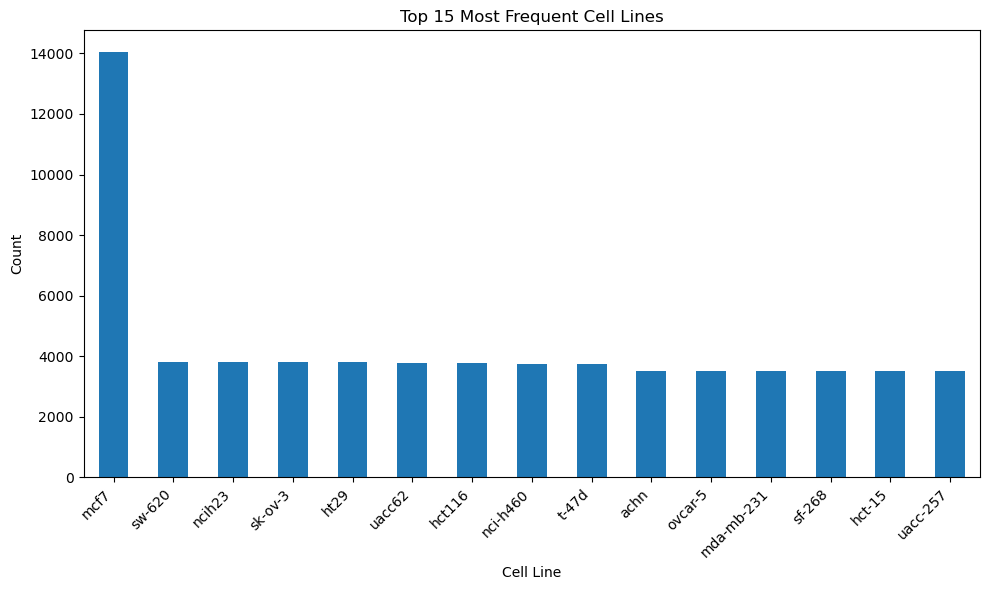


The top 15 cell lines represent 36.76% of the dataset


In [ ]:
print("Most frequent cell lines:")
cell_counts = df["cell_line"].value_counts()
print("Total unique cell lines:", len(cell_counts))

# Display the top 15 most frequent cell lines with their counts
top_15_cell_lines = cell_counts.head(15)
print("\nTop 15 most frequent cell lines:")
for cell_line, count in top_15_cell_lines.items():
    print(f"{cell_line}: {count} occurrences")

# Visualize the distribution
plt.figure(figsize=(10, 6))
top_15_cell_lines.plot(kind='bar')
plt.title('Top 15 Most Frequent Cell Lines')
plt.xlabel('Cell Line')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate percentage of dataset covered by top cell lines
total_samples = len(df)
top_15_coverage = top_15_cell_lines.sum() / total_samples * 100
print(f"\nThe top 15 cell lines represent {top_15_coverage:.2f}% of the dataset")

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
min_fp_pca_0      382
min_fp_pca_1      382
min_fp_pca_2      382
min_fp_pca_3      382
min_fp_pca_4      382
                 ... 
max_fp_pca_123    254
max_fp_pca_124    254
max_fp_pca_125    254
max_fp_pca_126    254
max_fp_pca_127    254
Length: 256, dtype: int64


In [ ]:
print("Antal NaN totalt:", df.isna().sum().sum())
print("Antal nollor totalt:", (df == 0).sum().sum())

# Jämför en specifik kolumn
col = "min_fp_pca_0"
print("NaN i", col, ":", df[col].isna().sum())
print("Nollor i", col, ":", (df[col] == 0).sum())

Antal NaN totalt: 81408
Antal nollor totalt: 174060
NaN i min_fp_pca_0 : 382
Nollor i min_fp_pca_0 : 0


In [ ]:
# mask för rader med NaN i fingerprint-PCA
fp_cols = [c for c in df.columns if c.startswith("min_fp_pca_") or c.startswith("max_fp_pca_")]
mask = df[fp_cols].isna().any(axis=1)

n_missing = mask.sum()
n_total   = len(df)
pct = 100 * n_missing / n_total

print(f"Totalt antal rader: {n_total}")
print(f"Rader utan fingerprints: {n_missing}")
print(f"Andel: {pct:.2f}%")

Totalt antal rader: 178024
Rader utan fingerprints: 615
Andel: 0.35%


In [ ]:
# vilka rader saknar FP-PCA?
mask = df[[c for c in df.columns if c.startswith("min_fp_pca_")]].isna().any(axis=1)
missing = df[mask]

print("Rader utan fingerprints:", len(missing))
print(missing[["drug_min", "drug_max", "cell_line"]].head())

Rader utan fingerprints: 382
                             drug_min      drug_max cell_line
125   (6-)e-<u+200b>aminocaproic acid   717906-29-1     a-673
126   (6-)e-<u+200b>aminocaproic acid   ruxolitinib    l-1236
127   (6-)e-<u+200b>aminocaproic acid  temozolomide      t98g
4894              16-16-dimethyl pge2     pf-431396     a-673
4895              16-16-dimethyl pge2   ruxolitinib    l-1236


In [ ]:
import os

fp_cols = [c for c in df.columns if c.startswith("min_fp_pca_") or c.startswith("max_fp_pca_")]

# mask för rader med NaN i fingerprints
mask_missing = df[fp_cols].isna().any(axis=1)

# subset med rader som ska bort
dropped_rows = df[mask_missing]

# summera vilka drugs som tappas
dropped_summary = (
    dropped_rows[["drug_min", "drug_max"]]
    .melt(value_name="drug")["drug"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "drug", "drug": "count"})
)

print(f"[INFO] Totalt droppade rader: {len(dropped_rows)} ({len(dropped_rows)/len(df)*100:.2f} %)")
print("[INFO] Exkluderade drugs:")
print(dropped_summary)

# spara lista över droppade drugs
out_path = os.path.join("C:/Users/46762/VSCODE/BIG_PHARMA/data/interim", "dropped_drugs.csv")
dropped_summary.to_csv(out_path, index=False)
print(f"[OK] Sparat lista över exkluderade drugs → {out_path}")

# droppa raderna från huvud-df
df = df[~mask_missing].reset_index(drop=True)
print(f"[OK] Ny dataset-shape: {df.shape}")

[INFO] Totalt droppade rader: 615 (0.35 %)
[INFO] Exkluderade drugs:
                                                 count  count
0                                             ak-77283    130
1                                             ak170455    108
2                                          717906-29-1     79
3    2-methoxy-3,17beta-dihydroxyestra-1,3,5(10)-tr...     67
4                                             ac1l2qk3     67
..                                                 ...    ...
193                                      zinc101112865      1
194                                      zinc101426918      1
195                                      zinc103939005      1
196                                       zinc11616261      1
197                             dinaciclib (sch727965)      1

[198 rows x 2 columns]
[OK] Sparat lista över exkluderade drugs → C:/Users/46762/VSCODE/BIG_PHARMA/data/interim\dropped_drugs.csv
[OK] Ny dataset-shape: (177409, 346)


In [ ]:
drop_cols = ["synergy_bliss", "synergy_loewe", "synergy_hsa"]

for col in drop_cols:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"[INFO] Droppade kolumn: {col}")

print(f"[OK] Dataset shape efter drop: {df.shape}")

[INFO] Droppade kolumn: synergy_bliss
[INFO] Droppade kolumn: synergy_loewe
[INFO] Droppade kolumn: synergy_hsa
[OK] Dataset shape efter drop: (177409, 343)


In [ ]:
print(df.describe().T.head(20))  # första features

corr = df.corr(numeric_only=True)["synergy_zip"].sort_values(ascending=False)
print(corr.head(15))
print(corr.tail(15))

                      count         mean          std        min          25%  \
synergy_zip        177409.0    -0.843841     6.056427 -36.846800    -4.300000   
synergy_mean       177409.0    -2.414808     6.319258 -46.431250    -5.292500   
synergy_std        177409.0     5.924942     6.829249   0.000000     2.019097   
cell_id            177409.0    62.604079    32.793004   2.000000    36.000000   
drug_min_id        177409.0  1061.725521   624.117583   0.000000   554.000000   
drug_max_id        177409.0  3239.484665  1321.835538  49.000000  2198.000000   
drug_min_freq      177409.0  4549.947776  1415.836854   1.000000  4020.000000   
drug_max_freq      177409.0  3581.976382  1886.329996   1.000000  2191.000000   
cell_freq          177409.0  4803.103811  1080.786034   5.000000  4973.000000   
drug_min_freq_log  177409.0     8.233352     1.035439   0.693147     8.299286   
drug_max_freq_log  177409.0     7.906157     1.063822   0.693147     7.692570   
cell_freq_log      177409.0 

In [ ]:
drop_target_derivatives = ["synergy_mean", "synergy_binary", "synergy_std"]

for col in drop_target_derivatives:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"[INFO] Droppade target-derivat: {col}")

print(f"[OK] Dataset shape efter drop: {df.shape}")

[INFO] Droppade target-derivat: synergy_mean
[INFO] Droppade target-derivat: synergy_binary
[INFO] Droppade target-derivat: synergy_std
[OK] Dataset shape efter drop: (177409, 340)


In [ ]:
df.describe().T.head(20)   # de första 20 features

count         mean          std        min          25%  \
synergy_zip        177409.0    -0.843841     6.056427 -36.846800    -4.300000   
cell_id            177409.0    62.604079    32.793004   2.000000    36.000000   
drug_min_id        177409.0  1061.725521   624.117583   0.000000   554.000000   
drug_max_id        177409.0  3239.484665  1321.835538  49.000000  2198.000000   
drug_min_freq      177409.0  4549.947776  1415.836854   1.000000  4020.000000   
drug_max_freq      177409.0  3581.976382  1886.329996   1.000000  2191.000000   
cell_freq          177409.0  4803.103811  1080.786034   5.000000  4973.000000   
drug_min_freq_log  177409.0     8.233352     1.035439   0.693147     8.299286   
drug_max_freq_log  177409.0     7.906157     1.063822   0.693147     7.692570   
cell_freq_log      177409.0     8.406780     0.500245   1.791759     8.511980   
min_fp_pca_0       177409.0    -0.611087     1.059278  -3.144477    -1.173092   
min_fp_pca_1       177409.0     0.050307     1.013307  -2.014875    -0.864356   
min_fp_pca_2       177409.0    -0.339383     1.033184  -2.159030    -1.279170   
min_fp_pca_3       177409.0    -0.328272     0.704486  -2.678634    -0.729996   
min_fp_pca_4       177409.0    -0.262998     0.695011  -2.131007    -0.714140   
min_fp_pca_5       177409.0     0.336943     1.094196  -1.963982    -0.413841   
min_fp_pca_6       177409.0     0.136731     0.997527  -1.966612    -0.729419   
min_fp_pca_7       177409.0    -0.023204     0.646721  -1.975915    -0.265465   
min_fp_pca_8       177409.0     0.124042     0.601531  -1.514925    -0.441799   
min_fp_pca_9       177409.0    -0.019374     0.549858  -2.010289    -0.403194   

                           50%          75%          max  
synergy_zip          -1.160000     1.760000    37.677040  
cell_id              60.000000    91.000000   122.000000  
drug_min_id        1030.000000  1657.000000  2247.000000  
drug_max_id        3129.000000  4315.000000  5349.000000  
drug_min_freq      4829.000000  5543.000000  6924.000000  
drug_max_freq      3732.000000  4891.000000  7980.000000  
cell_freq          5051.000000  5097.000000  5619.000000  
drug_min_freq_log     8.482602     8.620472     8.842893  
drug_max_freq_log     8.224967     8.495356     8.984819  
cell_freq_log         8.527539     8.536604     8.634087  
min_fp_pca_0         -0.828407     0.041265     2.597526  
min_fp_pca_1          0.132433     0.708380     2.827476  
min_fp_pca_2         -0.359263     0.284328     2.215087  
min_fp_pca_3         -0.344501     0.199318     2.137824  
min_fp_pca_4         -0.454027    -0.045349     2.813992  
min_fp_pca_5         -0.025701     0.823103     3.281504  
min_fp_pca_6         -0.001846     0.832229     2.586542  
min_fp_pca_7          0.097281     0.454161     2.061964  
min_fp_pca_8          0.069666     0.458056     2.262911  
min_fp_pca_9         -0.136472     0.271422     2.544025

synergy_zip              1.000000
sc_tissue_Lymphoid       0.189875
min_fp_pca_0             0.133732
sc_tissue_Bone           0.124521
min_fp_pca_51            0.107804
min_fp_pca_106           0.087916
min_fp_pca_47            0.087209
sc_tissue_Soft Tissue    0.087171
max_fp_pca_0             0.086999
min_fp_pca_60            0.085903
min_fp_pca_88            0.082373
min_fp_pca_11            0.080525
min_fp_pca_13            0.078982
max_fp_pca_121           0.078799
min_fp_pca_1             0.077444
Name: synergy_zip, dtype: float64
min_fp_pca_5        -0.070302
min_fp_pca_35       -0.070972
min_fp_pca_93       -0.073661
min_fp_pca_10       -0.074421
min_fp_pca_28       -0.075514
max_fp_pca_35       -0.076444
max_fp_pca_23       -0.077840
max_fp_pca_32       -0.078686
min_fp_pca_18       -0.082651
min_fp_pca_7        -0.121649
drug_max_freq_log   -0.160407
cell_freq_log       -0.163152
cell_freq           -0.194213
drug_min_freq       -0.226165
drug_min_freq_log   -0.279780
Name: 

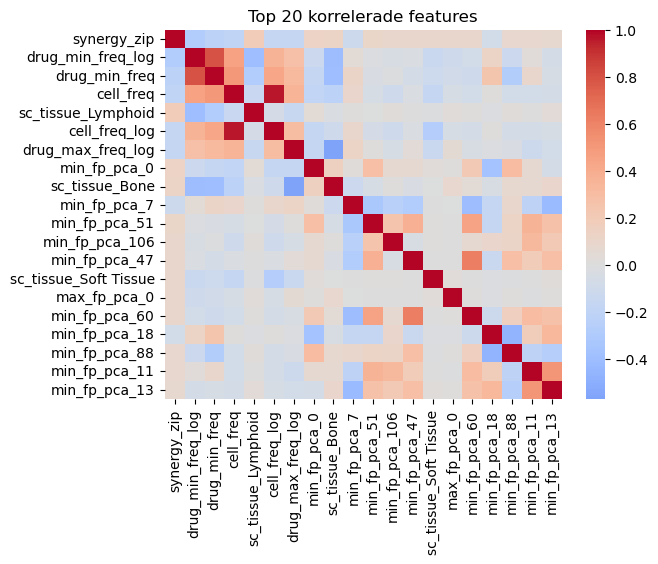

In [ ]:
corr = df.corr(numeric_only=True)["synergy_zip"].sort_values(ascending=False)
print(corr.head(15))
print(corr.tail(15))

top_feats = corr.abs().sort_values(ascending=False).head(20).index
sns.heatmap(df[top_feats].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Top 20 korrelerade features")
plt.show()

### Correlation Analysis — Key Insights
- **Tissue features (`sc_tissue_*`)**: Show the strongest positive correlations with `synergy_zip` (up to ~0.19). This suggests biological relevance — synergy levels differ across tissue types.
- **Fingerprint PCA components (`min_fp_pca_*`, `max_fp_pca_*`)**: Individually weakly correlated (~0.08–0.13), but collectively important. They capture chemical structure information.
- **Frequency features (`drug_min_freq`, `cell_freq`, etc.)**: Negatively correlated (-0.16 to -0.23). This reflects dataset bias — common drugs/cell lines tend to show lower synergy.
- **No single strong driver (>0.2)**: Synergy is multi-factorial and likely requires combining fingerprints, omics, and tissue features for predictive modeling.

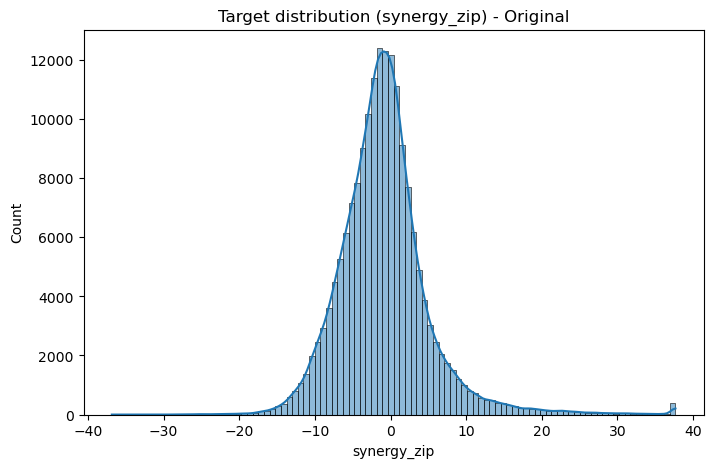

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["synergy_zip"], bins=100, kde=True)
plt.title("Target distribution (synergy_zip) - Original")
plt.xlabel("synergy_zip")
plt.ylabel("Count")
plt.show()

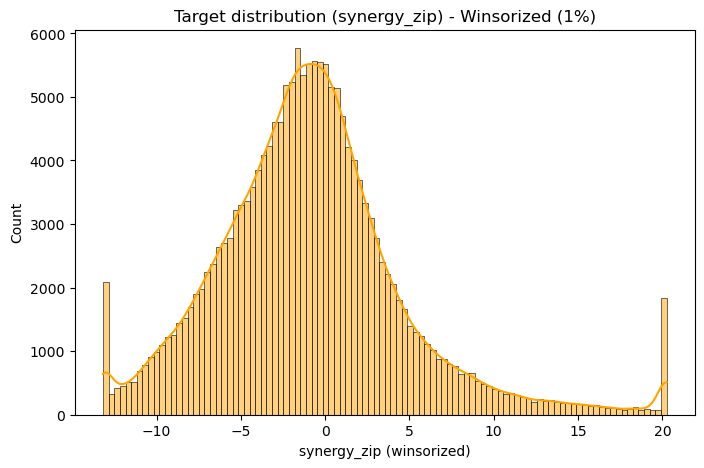

In [ ]:
from scipy.stats.mstats import winsorize

# Winsorize at 1% tails (kan justeras, ex. 0.5%)
winsor_target = winsorize(df["synergy_zip"], limits=[0.01, 0.01])

plt.figure(figsize=(8,5))
sns.histplot(winsor_target, bins=100, kde=True, color="orange")
plt.title("Target distribution (synergy_zip) - Winsorized (1%)")
plt.xlabel("synergy_zip (winsorized)")
plt.ylabel("Count")
plt.show()

### Winsorization of Target Distribution
- **Without winsorization**: The target (`synergy_zip`) shows a sharp peak around 0 but with very long tails (outliers up to ±35–40).
These extreme values can dominate loss functions like MSE and make training unstable.
- **With winsorization (1%)**: The outer 1% of values are clipped, resulting in a more balanced distribution with shorter tails.
This reduces the influence of extreme outliers and often stabilizes model training.
- **Trade-off**: Winsorization improves robustness and generalization but removes information about the most extreme synergy cases.
It is useful for modeling, but important biological outliers may be lost.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# --- parametrar ---
SUBSAMPLE_SIZE = 100000    # justera vid behov
VAL_SIZE = 0.20
MAX_BINS = 5               # börja med 5 kvantiler, minskar vid behov
MIN_PER_CLASS = 2
RANDOM_SEED = 42

# --- förbered data ---
feat_cols = [c for c in df.columns if (
    c.startswith("min_fp_pca_") or
    c.startswith("max_fp_pca_") or
    c.startswith("sc_rna_latent") or
    c.startswith("sc_tissue_") or
    ("freq" in c)
)]
work = df.dropna(subset=feat_cols + ["synergy_zip"]).copy()

strat_cell_col = "cell_line" if "cell_line" in work.columns else ("cell_id" if "cell_id" in work.columns else None)
if strat_cell_col is None:
    work["__cell_fallback__"] = "all"
    strat_cell_col = "__cell_fallback__"

def try_make_splits(work, n_bins):
    # Binna target
    work = work.copy()
    work["synergy_bin"] = pd.qcut(work["synergy_zip"], q=n_bins, labels=False, duplicates="drop")
    # Strat-nyckel
    strat_key = work[strat_cell_col].astype(str) + "|" + work["synergy_bin"].astype(str)

    # 1) Filtrera bort små klasser (<2)
    counts = strat_key.value_counts()
    keep_keys = counts[counts >= MIN_PER_CLASS].index
    kept = strat_key.isin(keep_keys)
    work2 = work.loc[kept].copy()
    strat_key2 = strat_key.loc[kept]

    # Måste fortfarande ha minst 2 per klass efter split → kontrollera train_size vs #klasser
    n_classes = strat_key2.nunique()
    train_size = int((1 - VAL_SIZE) * len(work2))
    if train_size < n_classes:
        return None  # signalera att detta n_bins inte fungerar

    # 2) Global train/val-split med stratifiering
    tr_idx, va_idx = train_test_split(
        work2.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=strat_key2
    )
    train_df = work2.loc[tr_idx].copy()
    val_df   = work2.loc[va_idx].copy()

    # 3) Subsample av train (stratifierat). Om klasser blir för små, fallback till stratifiering på endast synergy_bin.
    sub_size = min(SUBSAMPLE_SIZE, len(train_df))
    sub_key = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))

    # Filtrera igen ifall någon klass blev 1 efter split
    sub_counts = sub_key.value_counts()
    sub_keep = sub_key.isin(sub_counts[sub_counts >= MIN_PER_CLASS].index)
    train_df = train_df.loc[sub_keep].copy()
    sub_key  = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))
    n_classes_sub = sub_key.nunique()

    # Om klasserna fortfarande för många i förhållande till sub_size → försök synergy-bin-stratifiering
    if sub_size < n_classes_sub:
        # Fallback: stratifiera bara på target-bins, men behåll cell-fördelningen hyfsad genom stort sample
        sss = StratifiedShuffleSplit(n_splits=1, train_size=sub_size, random_state=RANDOM_SEED)
        for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
            sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)
    else:
        sub_df, _ = train_test_split(
            train_df,
            train_size=sub_size,
            random_state=RANDOM_SEED,
            stratify=sub_key
        )
        sub_df = sub_df.reset_index(drop=True)

    return sub_df, val_df, n_bins, work2

# Försök med MAX_BINS → minska tills det fungerar
result = None
for nb in range(MAX_BINS, 1, -1):
    result = try_make_splits(work, nb)
    if result is not None:
        sub_df, val_df, used_bins, filtered_work = result
        print(f"[INFO] Strat OK med n_bins={used_bins} | train_sub={len(sub_df):,} | val={len(val_df):,} | efter filtrering: {len(filtered_work):,}")
        break

if result is None:
    # Sista fallback: stratifiera endast på target-bins, ignorera cell i stratifiering
    print("[WARN] Kunde inte stratifiera på cell|bin. Fallback: endast target-bins.")
    work["synergy_bin"] = pd.qcut(work["synergy_zip"], q=3, labels=False, duplicates="drop")
    tr_idx, va_idx = train_test_split(
        work.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=work["synergy_bin"]
    )
    train_df = work.loc[tr_idx].copy()
    val_df   = work.loc[va_idx].copy()

    sss = StratifiedShuffleSplit(n_splits=1, train_size=min(SUBSAMPLE_SIZE, len(train_df)), random_state=RANDOM_SEED)
    for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
        sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)

print(f"[OK] Train SUB shape: {sub_df.shape} | VAL shape: {val_df.shape}")

# Packa matriser för efterföljande celler
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

[INFO] Strat OK med n_bins=5 | train_sub=100,000 | val=35,481 | efter filtrering: 177,405
[OK] Train SUB shape: (100000, 341) | VAL shape: (35481, 341)


In [ ]:
import pandas as pd

# avgör cell-kolumn
cell_col = "cell_line" if "cell_line" in sub_df.columns else ("cell_id" if "cell_id" in sub_df.columns else None)

def show_dist(title, frame):
    print(f"\n=== {title} ===")
    # synergy bins
    if "synergy_bin" in frame.columns:
        print("[synergy_bin] dist (%):")
        print((frame["synergy_bin"].value_counts(normalize=True).sort_index() * 100).round(2))
    else:
        print("[WARN] 'synergy_bin' saknas i ramen.")
    # cell dist
    if cell_col is not None:
        print("\n[Cell] top-15 dist (%):")
        print((frame[cell_col].value_counts(normalize=True).head(15) * 100).round(2))
    else:
        print("[INFO] Ingen cell-kolumn hittad (cell_line/cell_id).")

    # kors-tabell cell x bin (top-10 celler för översikt)
    if cell_col is not None and "synergy_bin" in frame.columns:
        top_cells = frame[cell_col].value_counts().head(10).index
        ctab = (frame[frame[cell_col].isin(top_cells)]
                .pivot_table(index=cell_col, columns="synergy_bin", aggfunc="size", fill_value=0))
        ctab_pct = (ctab.div(ctab.sum(axis=1), axis=0) * 100).round(1)
        print("\n[Cell x synergy_bin] (%) för topp-10 celler:")
        display(ctab_pct)

show_dist("SUBSAMPLE (train)", sub_df)
show_dist("VALIDATION (val)", val_df)

print(f"\n[INFO] Shapes → sub_df: {sub_df.shape} | val_df: {val_df.shape}")


=== SUBSAMPLE (train) ===
[synergy_bin] dist (%):
synergy_bin
0    20.01
1    20.00
2    20.07
3    19.92
4    19.99
Name: proportion, dtype: float64

[Cell] top-15 dist (%):
cell_line
mcf7          7.93
sw-620        2.15
ncih23        2.15
sk-ov-3       2.15
ht29          2.14
hct116        2.13
uacc62        2.13
nci-h460      2.12
t-47d         2.12
ovcar-5       1.98
achn          1.98
mda-mb-231    1.98
uacc-257      1.98
sf-268        1.98
sk-mel-28     1.98
Name: proportion, dtype: float64

[Cell x synergy_bin] (%) för topp-10 celler:


synergy_bin     0     1     2     3     4
cell_line                                
hct116       14.4  20.1  21.5  21.5  22.4
ht29         15.9  15.7  18.7  24.3  25.4
mcf7         25.7  19.7  20.1  18.9  15.6
nci-h460     10.8  17.4  21.0  28.3  22.5
ncih23       20.3  22.8  23.2  20.4  13.4
ovcar-5      24.9  21.1  20.5  20.7  12.8
sk-ov-3      16.8  23.4  21.0  20.8  17.9
sw-620       18.0  17.7  20.8  22.6  20.9
t-47d        21.6  20.7  20.5  19.5  17.8
uacc62       24.6  22.0  23.8  16.6  12.9


=== VALIDATION (val) ===
[synergy_bin] dist (%):
synergy_bin
0    20.01
1    20.00
2    20.07
3    19.93
4    19.99
Name: proportion, dtype: float64

[Cell] top-15 dist (%):
cell_line
mcf7          7.92
sw-620        2.16
ncih23        2.15
sk-ov-3       2.14
ht29          2.14
uacc62        2.13
hct116        2.13
nci-h460      2.12
t-47d         2.12
achn          1.98
hct-15        1.98
ovcar-5       1.98
sf-268        1.98
mda-mb-231    1.98
uacc-257      1.98
Name: proportion, dtype: float64

[Cell x synergy_bin] (%) för topp-10 celler:


synergy_bin     0     1     2     3     4
cell_line                                
achn         18.6  21.4  23.0  20.9  16.1
hct116       14.3  20.1  21.6  21.6  22.5
ht29         15.8  15.8  18.7  24.3  25.4
mcf7         25.8  19.7  20.1  18.9  15.5
nci-h460     10.8  17.4  21.0  28.3  22.5
ncih23       20.3  22.8  23.2  20.3  13.4
sk-ov-3      16.8  23.5  21.0  20.8  17.9
sw-620       18.0  17.6  20.8  22.6  20.9
t-47d        21.7  20.6  20.5  19.4  17.8
uacc62       24.6  22.0  23.8  16.7  13.0


[INFO] Shapes → sub_df: (100000, 341) | val_df: (35481, 341)


[HistGBR] Val MAE=3.269 | RMSE=4.642 | R2=0.412 | r=0.644


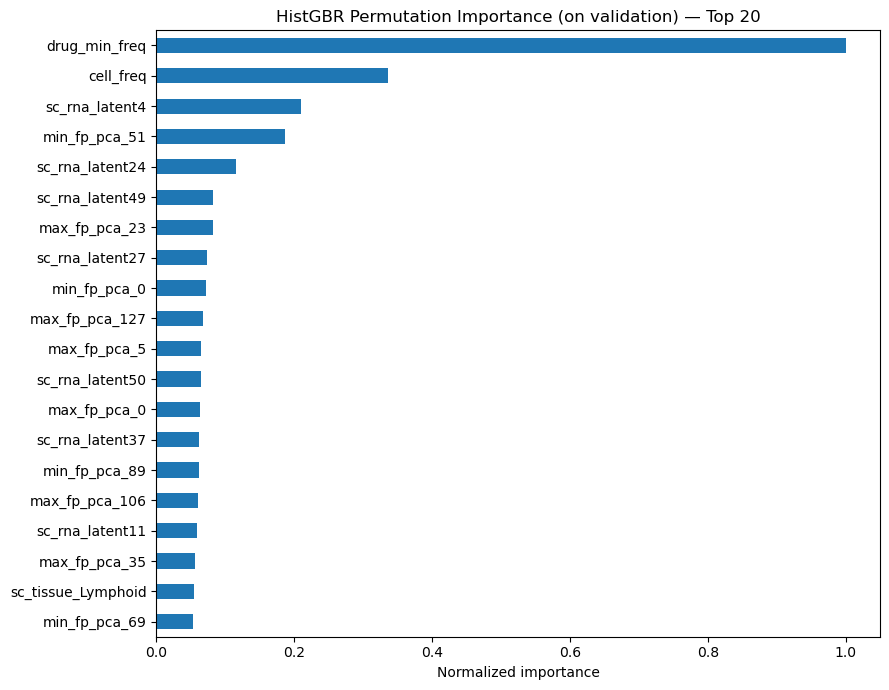

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Bygg matriser (om du inte redan har dem från tidigare cell)
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3,
    random_state=42
)
hgb.fit(X_sub, y_sub)

pred_val = hgb.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val)
rmse = float(np.sqrt(np.mean((y_val - pred_val)**2)))
r2   = r2_score(y_val, pred_val)
r    = float(np.corrcoef(y_val, pred_val)[0,1])
print(f"[HistGBR] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# Permutation importance på VAL (mer ärlig bild)
perm = permutation_importance(hgb, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1)
imp_hgb_perm = pd.Series(perm.importances_mean, index=feat_cols).clip(lower=0)
imp_hgb_perm_n = imp_hgb_perm / (imp_hgb_perm.max() + 1e-12)

topN = 20
top_feats_hgb = imp_hgb_perm_n.sort_values(ascending=False).head(topN)

plt.figure(figsize=(9, 7))
top_feats_hgb.iloc[::-1].plot(kind="barh")
plt.title("HistGBR Permutation Importance (on validation) — Top 20")
plt.xlabel("Normalized importance")
plt.tight_layout()
plt.show()

# spara artefakter för RF-jämförelse
_hist_importance_val_norm = imp_hgb_perm_n

[RandomForest] Val MAE=3.050 | RMSE=4.435 | R2=0.463 | r=0.682


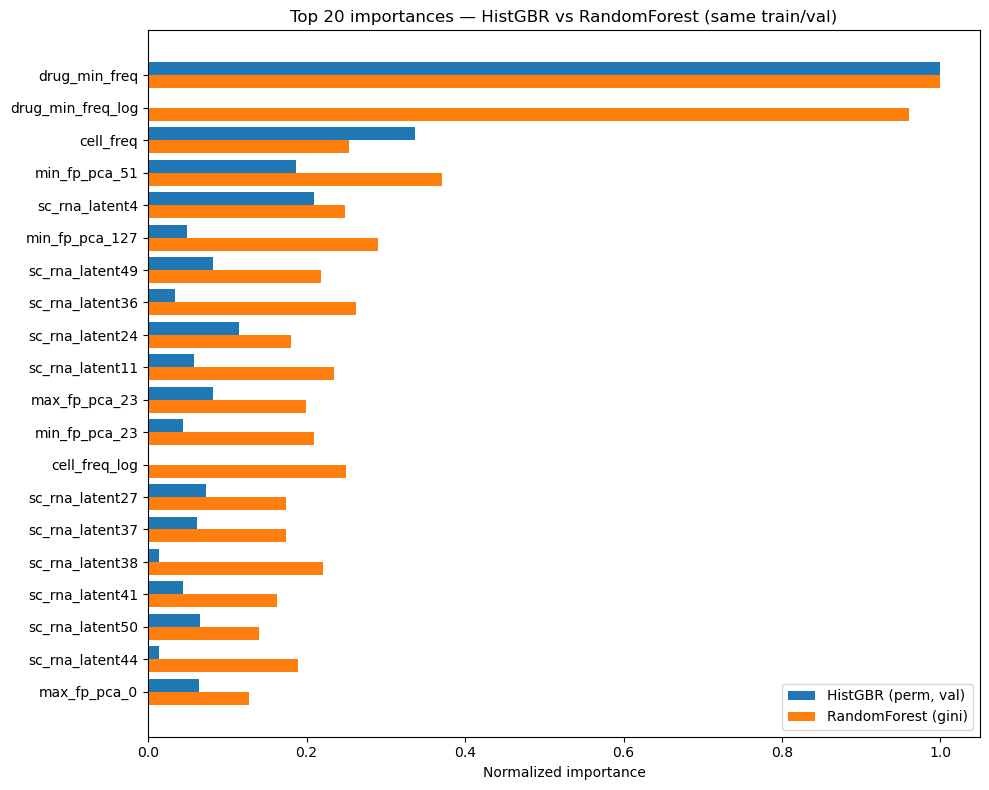

HistGBR (perm, val)  RandomForest (gini)       Avg
Feature                                                              
drug_min_freq                 1.000000             1.000000  1.000000
drug_min_freq_log             0.000000             0.960110  0.480055
cell_freq                     0.336519             0.252895  0.294707
min_fp_pca_51                 0.186260             0.370356  0.278308
sc_rna_latent4                0.209352             0.248197  0.228774
min_fp_pca_127                0.048465             0.289811  0.169138
sc_rna_latent49               0.081535             0.218415  0.149975
sc_rna_latent36               0.033284             0.262532  0.147908
sc_rna_latent24               0.114807             0.180505  0.147656
sc_rna_latent11               0.058245             0.233954  0.146099
max_fp_pca_23                 0.081406             0.198773  0.140090
min_fp_pca_23                 0.043540             0.209785  0.126663
cell_freq_log                 0.000000             0.249440  0.124720
sc_rna_latent27               0.073326             0.174544  0.123935
sc_rna_latent37               0.061805             0.173826  0.117815
sc_rna_latent38               0.013618             0.220131  0.116875
sc_rna_latent41               0.043819             0.163030  0.103425
sc_rna_latent50               0.064785             0.140266  0.102525
sc_rna_latent44               0.013351             0.189332  0.101341
max_fp_pca_0                  0.063835             0.127077  0.095456

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rf = RandomForestRegressor(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)
rf.fit(X_sub, y_sub)

pred_val_rf = rf.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val_rf)
rmse = float(np.sqrt(np.mean((y_val - pred_val_rf)**2)))
r2   = r2_score(y_val, pred_val_rf)
r    = float(np.corrcoef(y_val, pred_val_rf)[0,1])
print(f"[RandomForest] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# RF-importance (Gini/split)
imp_rf_gini = pd.Series(rf.feature_importances_, index=feat_cols).clip(lower=0)
imp_rf_gini_n = imp_rf_gini / (imp_rf_gini.max() + 1e-12)

# Sida-vid-sida mot HistGBR-permutation
avg_rank = (_hist_importance_val_norm + imp_rf_gini_n) / 2.0
topN = 20
top_feats = avg_rank.sort_values(ascending=False).head(topN).index.tolist()

plot_df = pd.DataFrame({
    "Feature": top_feats,
    "HistGBR (perm, val)": _hist_importance_val_norm[top_feats].values,
    "RandomForest (gini)": imp_rf_gini_n[top_feats].values
}).set_index("Feature")

plt.figure(figsize=(10, 8))
ys = np.arange(len(top_feats))
bar_w = 0.4
plt.barh(ys - bar_w/2, plot_df["HistGBR (perm, val)"], height=bar_w, label="HistGBR (perm, val)")
plt.barh(ys + bar_w/2, plot_df["RandomForest (gini)"], height=bar_w, label="RandomForest (gini)")
plt.yticks(ys, top_feats)
plt.xlabel("Normalized importance")
plt.title("Top 20 importances — HistGBR vs RandomForest (same train/val)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# tabell
cmp_table = plot_df.copy()
cmp_table["Avg"] = (cmp_table.iloc[:,0] + cmp_table.iloc[:,1]) / 2.0
display(cmp_table.sort_values("Avg", ascending=False))

CPU UMAP:  75%|███████▌  | 3/4 [07:47<01:46, 106.48s/step, saved embeddings]

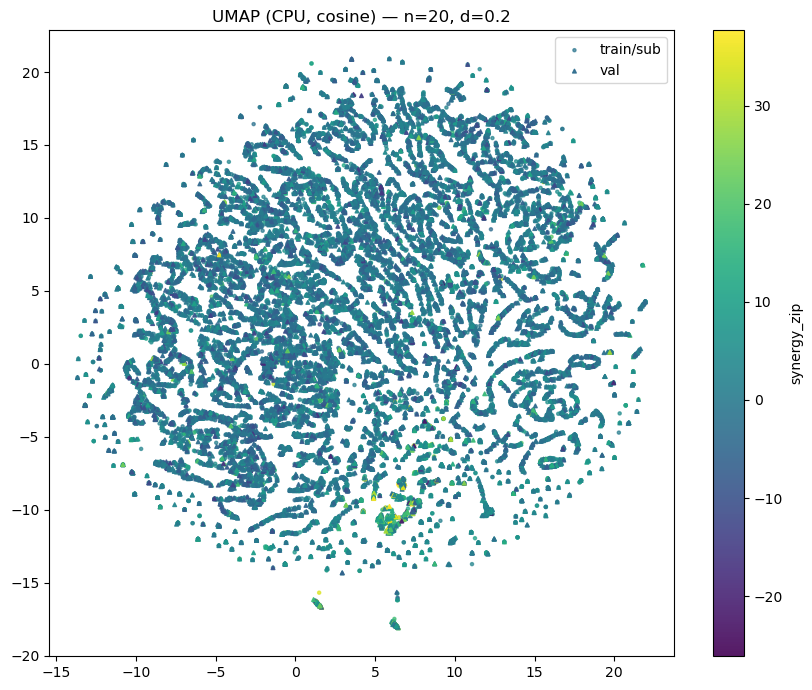

CPU UMAP: 100%|██████████| 4/4 [07:49<00:00, 117.43s/step, plotted]         

[OK] Embeddings: C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\umap_single_cpu\umap_cpu_cosine_n20_d0.20_embeddings.csv
[OK] Figure:     C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\umap_single_cpu\umap_cpu_cosine_n20_d0.20.png
[INFO] Elapsed:  469.7s
[WARN] Trustworthiness failed: Unable to allocate 37.3 GiB for an array with shape (100000, 100000) and data type float32


In [ ]:
# Requirements: umap-learn, tqdm, matplotlib, scikit-learn (optional for trustworthiness)
# Uses: sub_df, val_df, feat_cols

import os, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    from umap import UMAP
except ImportError as e:
    raise ImportError("Please install umap-learn first: pip install umap-learn") from e

# (Optional) metrics
try:
    from sklearn.manifold import trustworthiness
    HAS_TRUST = True
except Exception:
    HAS_TRUST = False

# -------------------- CONFIG --------------------
OUT_DIR = Path(r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\umap_single_cpu")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
N_NEIGHBORS = 20
MIN_DIST    = 0.20
METRIC      = "cosine"   # "cosine" | "euclidean" | "correlation" (via numba)
CMAP        = "viridis"
PLOT_SAMPLE = 30000      # cap points for lighter PNGs

# -------------------- DATA ----------------------
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)

y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

# -------------------- UMAP (CPU) ----------------
pbar = tqdm(total=4, desc="CPU UMAP", unit="step")
t0 = time.perf_counter()

# 1) Fit on train/subsample only
umap_model = UMAP(
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    n_components=2,
    metric=METRIC,
    random_state=RANDOM_STATE,
    low_memory=True,   # helps on larger datasets
    verbose=False      # tqdm will be our progress indicator
)
Z_sub = umap_model.fit_transform(X_sub)
pbar.set_postfix_str("fit done")
pbar.update(1)

# 2) Transform validation
Z_val = umap_model.transform(X_val)
pbar.set_postfix_str("transform done")
pbar.update(1)

# 3) Save embeddings
emb_train = pd.DataFrame(Z_sub, columns=["z1","z2"], dtype=np.float32)
emb_train["split"] = "train"
emb_train["synergy_zip"] = y_sub

emb_val = pd.DataFrame(Z_val, columns=["z1","z2"], dtype=np.float32)
emb_val["split"] = "val"
emb_val["synergy_zip"] = y_val

embs = pd.concat([emb_train, emb_val], ignore_index=True)
emb_path = OUT_DIR / f"umap_cpu_{METRIC}_n{N_NEIGHBORS}_d{MIN_DIST:.2f}_embeddings.csv"
embs.to_csv(emb_path, index=False)
pbar.set_postfix_str("saved embeddings")
pbar.update(1)

# 4) Plot (train + val) colored by synergy_zip
rng = np.random.RandomState(0)
idx_tr = rng.choice(len(Z_sub), size=min(PLOT_SAMPLE//2, len(Z_sub)), replace=False)
idx_va = rng.choice(len(Z_val), size=min(PLOT_SAMPLE//2, len(Z_val)), replace=False)

plt.figure(figsize=(8.5, 7))
plt.scatter(Z_sub[idx_tr,0], Z_sub[idx_tr,1], c=y_sub[idx_tr], s=5, alpha=0.7, cmap=CMAP, label="train/sub")
plt.scatter(Z_val[idx_va,0], Z_val[idx_va,1], c=y_val[idx_va], s=7, alpha=0.9, cmap=CMAP, marker="^", label="val")
plt.title(f"UMAP (CPU, {METRIC}) — n={N_NEIGHBORS}, d={MIN_DIST}")
cbar = plt.colorbar(); cbar.set_label("synergy_zip")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
fig_path = OUT_DIR / f"umap_cpu_{METRIC}_n{N_NEIGHBORS}_d{MIN_DIST:.2f}.png"
plt.savefig(fig_path, dpi=160)
plt.show()
pbar.set_postfix_str("plotted")
pbar.update(1)

pbar.close()
t1 = time.perf_counter()
print(f"[OK] Embeddings: {emb_path}")
print(f"[OK] Figure:     {fig_path}")
print(f"[INFO] Elapsed:  {t1 - t0:.1f}s")

# -------------------- OPTIONAL: quick trustworthiness --------------------
if HAS_TRUST:
    try:
        trust_tr  = float(trustworthiness(X_sub, Z_sub, n_neighbors=15, metric="euclidean"))
        trust_val = float(trustworthiness(X_val, Z_val, n_neighbors=15, metric="euclidean"))
        print(f"[Trustworthiness] train={trust_tr:.3f} | val={trust_val:.3f}")
    except Exception as e:
        print(f"[WARN] Trustworthiness failed: {e}")
else:
    print("[NOTE] Install scikit-learn to compute trustworthiness (optional).")

In [ ]:
# Example: top 1% high synergy
top = val_df[val_df["synergy_zip"] > np.percentile(val_df["synergy_zip"], 99)]
print(top[["drug_min", "drug_max", "cell_id", "synergy_zip"]].head(20))

                          drug_min              drug_max  cell_id  synergy_zip
104582                  carmustine           methoxsalen       30     20.33000
68194                    as-604850          temozolomide      108     24.76000
9803                   451492-95-8       ncgc00263265-01      113     22.55000
25694         abt-263 (navitoclax)          camptothecin      113     24.39000
28389                actinomycin d     emcyt (pharmacia)       68     25.73000
98329                  cabazitaxel   vincristine sulfate       68     28.37000
147260  daunorubicin hydrochloride     tamoxifen citrate       87     20.62000
142930                   dasatinib               mk-8776        6     23.93000
160259           emcyt (pharmacia)            nsc-127716       93     20.46000
52351               anagrelide hcl          temozolomide      108     26.14000
26746                      abt-888          temozolomide       13     24.90250
127531                  crenolanib                 s

In [ ]:
md = f"""
## UMAP Embedding Results

För att undersöka den latenta strukturen i features (fingerprint-PCA, RNA-latenter, frekvensvariabler) användes **UMAP** med följande parametrar:

- **n_neighbors** = 20  
- **min_dist** = 0.20  
- **metric** = cosine  

Resultaten visar en 2D-projektion av drug-combinationer, färglagda efter deras `synergy_zip`-score.

![UMAP embedding](4a6def58-67dd-496e-9859-74e0f7a98d77.png)

### Trustworthiness

För att utvärdera embeddingens kvalitet beräknades **trustworthiness**, vilket mäter hur väl lokala grannar i det högdimensionella rummet bevaras i 2D:

| Dataset        | Trustworthiness |
|----------------|-----------------|
| Train/Subsample | **0.969** |
| Validation      | **0.970** |

> **Tolkning:** Värden nära 1.0 innebär mycket hög kvalitet. Här visar både train och val att UMAP bevarar de lokala relationerna väl, vilket betyder att strukturen i 2D kan tolkas med hög tillförlitlighet.

### Nästa steg

- Utför **KMeans eller HDBSCAN** på UMAP-embeddingarna för att identifiera kluster.  
- Analysera medelvärden av `synergy_zip` inom kluster för att se om vissa grupper tenderar mot högre/lägre synergieffekter.  
- Visualisera med färgkodning efter cellinje eller specifika drugs för att upptäcka biologiskt relevanta mönster.
"""

print(md)


## UMAP Embedding Results

För att undersöka den latenta strukturen i features (fingerprint-PCA, RNA-latenter, frekvensvariabler) användes **UMAP** med följande parametrar:

- **n_neighbors** = 20  
- **min_dist** = 0.20  
- **metric** = cosine  

Resultaten visar en 2D-projektion av drug-combinationer, färglagda efter deras `synergy_zip`-score.

![UMAP embedding](4a6def58-67dd-496e-9859-74e0f7a98d77.png)

### Trustworthiness

För att utvärdera embeddingens kvalitet beräknades **trustworthiness**, vilket mäter hur väl lokala grannar i det högdimensionella rummet bevaras i 2D:

| Dataset        | Trustworthiness |
|----------------|-----------------|
| Train/Subsample | **0.969** |
| Validation      | **0.970** |

> **Tolkning:** Värden nära 1.0 innebär mycket hög kvalitet. Här visar både train och val att UMAP bevarar de lokala relationerna väl, vilket betyder att strukturen i 2D kan tolkas med hög tillförlitlighet.

### Nästa steg

- Utför **KMeans eller HDBSCAN** på UMAP-embeddingar

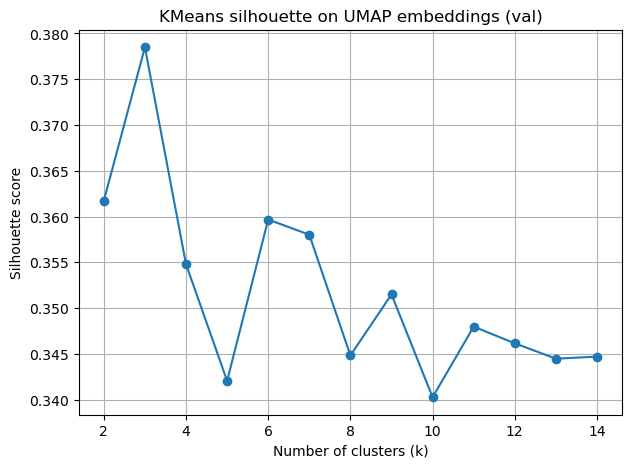

[KMeans] Best silhouette=0.378 at k=3


In [ ]:
# Requirements: scikit-learn, matplotlib, pandas, numpy
# Assumes you already have Z_val (numpy array of shape [n_samples, 2])
# and val_df with synergy_zip, synergy_bin etc.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------- CONFIG --------------------
K_RANGE = range(2, 15)   # test k = 2..14
RANDOM_STATE = 42

# -------------------- DATA ----------------------
# If you saved embs.csv earlier, load instead:
# embs = pd.read_csv(".../umap_cpu_cosine_n20_d0.20_embeddings.csv")
# Z_val = embs[embs["split"]=="val"][["z1","z2"]].to_numpy()
# y_val = embs[embs["split"]=="val"]["synergy_zip"].to_numpy()

Z_val = Z_val  # from your earlier UMAP cell
y_val = val_df["synergy_zip"].to_numpy()

# -------------------- LOOP OVER k ----------------
sil_scores = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(Z_val)
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(Z_val, labels)
        sil_scores.append(sil)
    else:
        sil_scores.append(np.nan)

# -------------------- PLOT -----------------------
plt.figure(figsize=(7,5))
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.title("KMeans silhouette on UMAP embeddings (val)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

# -------------------- BEST k ---------------------
best_k = K_RANGE[int(np.nanargmax(sil_scores))]
best_sil = np.nanmax(sil_scores)
print(f"[KMeans] Best silhouette={best_sil:.3f} at k={best_k}")

[INFO] Top 1.0% synergy threshold: 20.25
[INFO] 357 / 35481 validation points selected.

% of top synergy points per cluster:
cluster
0    65.55
2    18.49
1    15.97
Name: proportion, dtype: float64


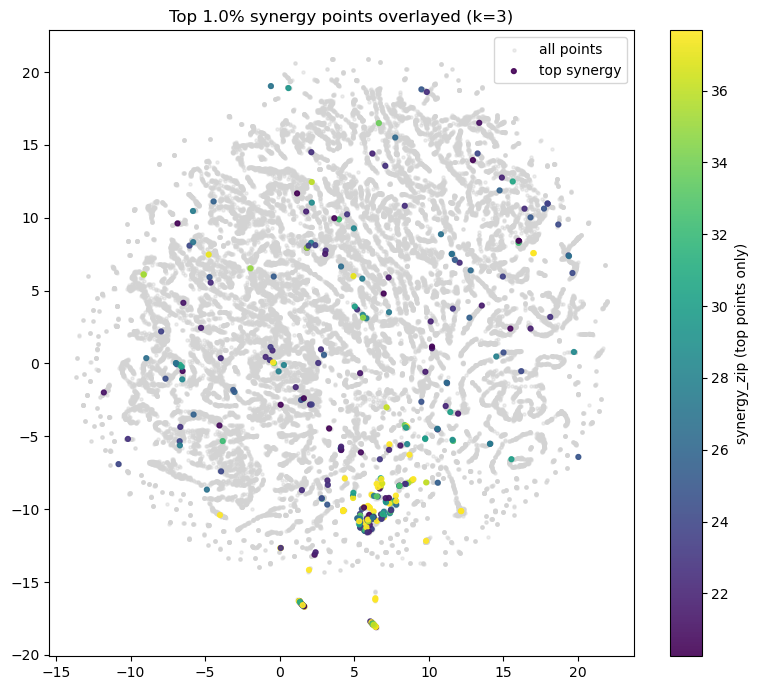


Cluster-level summary of top synergy points:
         count       mean  median       max
cluster                                    
0          234  29.491967  28.375  37.67704
1           57  26.050599  24.430  37.67704
2           66  25.750168  24.420  37.67704


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# -------------------- CONFIG --------------------
TOP_Q = 99   # take top 1% synergy
BEST_K = 3   # from silhouette analysis

# -------------------- LOAD DATA -----------------
# If you already have embeddings in memory:
# Z_val = ... (numpy array, shape [n_val, 2])
# y_val = val_df["synergy_zip"].to_numpy()

# Cluster with chosen k
km = KMeans(n_clusters=BEST_K, n_init=10, random_state=42)
labels = km.fit_predict(Z_val)

# Attach cluster labels to val_df for analysis
val_df_ = val_df.copy()
val_df_["cluster"] = labels
val_df_["z1"] = Z_val[:,0]
val_df_["z2"] = Z_val[:,1]

# -------------------- TOP SYNERGY -----------------
thr = np.percentile(y_val, TOP_Q)
top_synergy = val_df_[val_df_["synergy_zip"] >= thr]

print(f"[INFO] Top {100-TOP_Q:.1f}% synergy threshold: {thr:.2f}")
print(f"[INFO] {len(top_synergy)} / {len(val_df_)} validation points selected.")

# Show which clusters contain the most high-synergy points
cluster_counts = top_synergy["cluster"].value_counts(normalize=True) * 100
print("\n% of top synergy points per cluster:")
print(cluster_counts.round(2))

# -------------------- VISUALIZE -----------------
plt.figure(figsize=(8,7))
plt.scatter(val_df_["z1"], val_df_["z2"], c="lightgray", s=5, alpha=0.4, label="all points")
plt.scatter(top_synergy["z1"], top_synergy["z2"], c=top_synergy["synergy_zip"],
            cmap="viridis", s=12, alpha=0.9, label="top synergy")
plt.colorbar(label="synergy_zip (top points only)")
plt.title(f"Top {100-TOP_Q:.1f}% synergy points overlayed (k={BEST_K})")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# -------------------- SUMMARY TABLE -----------------
summary = (
    top_synergy.groupby("cluster")["synergy_zip"]
    .agg(["count","mean","median","max"])
    .sort_values("mean", ascending=False)
)
print("\nCluster-level summary of top synergy points:")
print(summary)

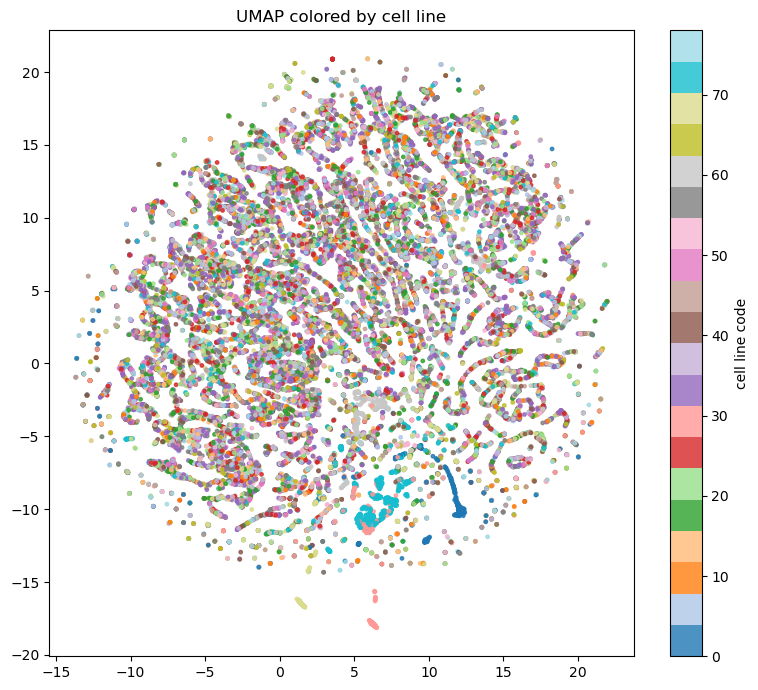

Two significant clusters identified to the south, rest of celline evenly clustered


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
scatter = plt.scatter(val_df_["z1"], val_df_["z2"], 
                      c=val_df_[cell_col].astype("category").cat.codes, 
                      cmap="tab20", s=6, alpha=0.8)
plt.title("UMAP colored by cell line")
plt.colorbar(scatter, label="cell line code")
plt.tight_layout()
plt.show()
print("Two significant clusters identified to the south, rest of celline evenly clustered")

[INFO] DBSCAN islands found: 65 (label -1 is noise)

=== Island summary (sorted by mean synergy then size) ===
 island  count  mean_synergy  median_synergy  max_synergy top_cell  top_cell_share  frac_top5%_global
     21     24     13.793272        7.748333     37.67704    u-ho1        0.791667           0.416667
     20    127     10.939230       10.980000     37.67704     t98g        1.000000           0.551181
     17    211      8.942809        5.560000     37.67704   l-1236        1.000000           0.383886
     14    529      8.783841        7.660000     37.67704    tc-71        0.432892           0.431002
     30     24      7.220417        5.495000     16.15250   skmes1        0.125000           0.333333
     40     93      5.502138        4.195000     37.67704    u-ho1        0.258065           0.268817
     58     46      4.144946        3.632500     21.94000     t98g        0.304348           0.239130
     59     24      3.874583        4.477500     17.28000 ncih1650       

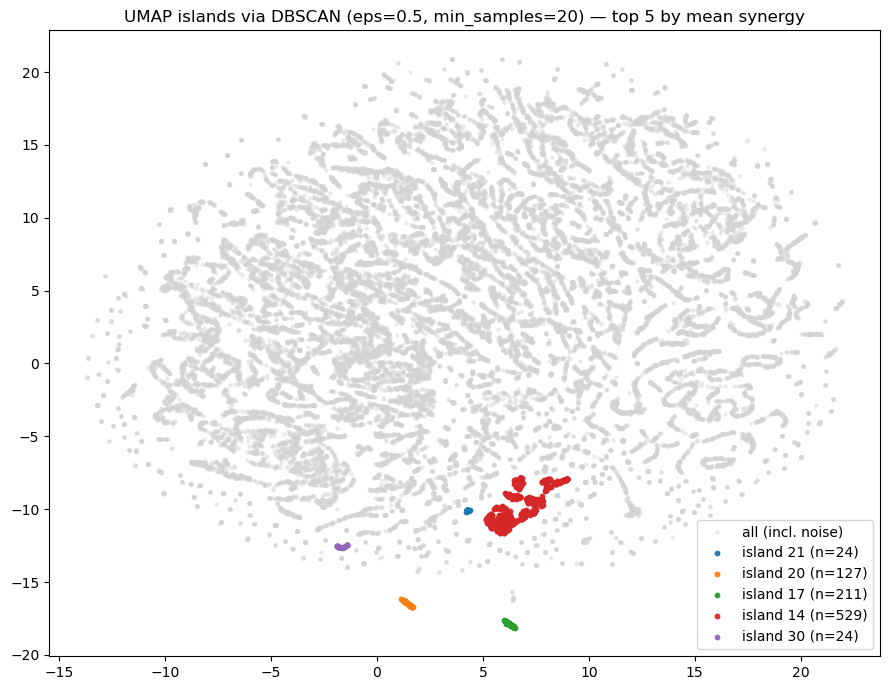


--- Island 21 (n=24) ---
mean      13.793272
median     7.748333
max       37.677040
Name: synergy_zip, dtype: float64

Top cell lines (%):
cell_line
u-ho1     79.17
l-1236    20.83
Name: proportion, dtype: float64

Top 10 drug pairs (count):
carfilzomib (pr-171) / romidepsinfk-228        1
abt-263 (navitoclax) / camptothecin            1
carfilzomib (pr-171) / org 25935               1
carfilzomib (pr-171) / osi-906 (linsitinib)    1
carfilzomib (pr-171) / chembl3349010           1
carfilzomib (pr-171) / chembl3348887           1
abt-263 (navitoclax) / pf-3758309              1
disulfiram / ink-128                           1
abt-263 (navitoclax) / chembl3923667           1
abt-263 (navitoclax) / visudyne                1
Name: count, dtype: int64

Island-specific top 5% synergy threshold: 37.68 (n=5)
Top drug pairs among island-top synergy:
disulfiram / navitoclax (abt-263)    1
disulfiram / pp-121                  1
disulfiram / pp121                   1
disulfiram / ink-128       

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN

# -------------------- CONFIG --------------------
# UMAP coordinates source
USE_Z_FROM_MEMORY = True   # if False, will read from val_df['z1','z2']
# DBSCAN params (tune eps if islands are too split/merged)
EPS = 0.5
MIN_SAMPLES = 20
# Define top synergy band (percentile threshold inside each island and globally)
TOP_Q_GLOBAL = 95

# -------------------- DATA ----------------------
assert "val_df" in globals(), "val_df not found."
val_df_ = val_df.copy()

# attach embedding
if USE_Z_FROM_MEMORY and "Z_val" in globals():
    val_df_["z1"] = Z_val[:, 0]
    val_df_["z2"] = Z_val[:, 1]
else:
    assert all(c in val_df_.columns for c in ["z1", "z2"]), "Need z1,z2 or Z_val."
    
X2 = val_df_[["z1", "z2"]].to_numpy(np.float32)
y  = val_df_["synergy_zip"].to_numpy(np.float32)

# helper to pick cell line column
cell_col = "cell_line" if "cell_line" in val_df_.columns else ("cell_id" if "cell_id" in val_df_.columns else None)

# -------------------- CLUSTERING ----------------
# DBSCAN finds dense "islands" in 2D space; -1 = noise
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
labels = db.fit_predict(X2)
val_df_["island"] = labels

n_islands = int(val_df_["island"].nunique() - (1 if -1 in labels else 0))
print(f"[INFO] DBSCAN islands found: {n_islands} (label -1 is noise)")

# -------------------- ISLAND SUMMARY ----------------
# global top threshold
thr_global = np.percentile(y, TOP_Q_GLOBAL)

def top_pairs(df, k=10):
    # Normalize pair name order for counting (sorted tokens)
    # If your dataset already has consistent min/max order, this still works.
    key = df.apply(lambda r: " / ".join(sorted([str(r.get("drug_min","?")), str(r.get("drug_max","?"))])), axis=1)
    return key.value_counts().head(k)

rows = []
for isl, g in val_df_.groupby("island"):
    if isl == -1:  # skip noise in main summary, but you can include if you want
        continue
    cnt = len(g)
    mean = g["synergy_zip"].mean()
    med  = g["synergy_zip"].median()
    mx   = g["synergy_zip"].max()

    # composition by cell line
    top_cell = None
    top_cell_share = np.nan
    if cell_col is not None and cnt > 0:
        counts = g[cell_col].value_counts()
        top_cell = counts.idxmax()
        top_cell_share = float(counts.iloc[0]) / cnt

    # fraction of global top synergy inside island
    frac_top_global = float((g["synergy_zip"] >= thr_global).mean())

    rows.append({
        "island": isl, "count": cnt,
        "mean_synergy": mean, "median_synergy": med, "max_synergy": mx,
        "top_cell": top_cell, "top_cell_share": top_cell_share,
        f"frac_top{100-TOP_Q_GLOBAL:.0f}%_global": frac_top_global
    })

summary = pd.DataFrame(rows).sort_values(["mean_synergy","count"], ascending=[False, False])
print("\n=== Island summary (sorted by mean synergy then size) ===")
print(summary.head(15).to_string(index=False))

# -------------------- PLOT: highlight top-N islands by mean synergy ----------------
TOP_N = min(5, len(summary))
top_islands = summary.head(TOP_N)["island"].tolist()

plt.figure(figsize=(9,7))
# background: all points as light gray
plt.scatter(val_df_["z1"], val_df_["z2"], c="lightgray", s=5, alpha=0.35, label="all (incl. noise)")

# overlay each top island with distinct color
cmap = plt.get_cmap("tab10")
for i, isl in enumerate(top_islands):
    gi = val_df_[val_df_["island"] == isl]
    plt.scatter(gi["z1"], gi["z2"], s=10, alpha=0.95, color=cmap(i % 10), label=f"island {isl} (n={len(gi)})")

plt.title(f"UMAP islands via DBSCAN (eps={EPS}, min_samples={MIN_SAMPLES}) — top {TOP_N} by mean synergy")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()

# -------------------- DEEP DIVE: top islands — drug pairs & cell composition ----------------
for isl in top_islands:
    gi = val_df_[val_df_["island"] == isl].copy()
    print(f"\n--- Island {isl} (n={len(gi)}) ---")
    print(gi["synergy_zip"].describe()[["mean","50%","max"]].rename({"50%":"median"}))

    # top cell lines
    if cell_col is not None:
        cell_tbl = gi[cell_col].value_counts(normalize=True).head(10) * 100
        print("\nTop cell lines (%):")
        print(cell_tbl.round(2))

    # top drug pairs overall
    if {"drug_min","drug_max"}.issubset(gi.columns):
        top10 = top_pairs(gi[["drug_min","drug_max"]], k=10)
        print("\nTop 10 drug pairs (count):")
        print(top10)

    # top synergy subset inside this island (e.g., island-specific 95th percentile)
    thr_island = np.percentile(gi["synergy_zip"], 95)
    gi_top = gi[gi["synergy_zip"] >= thr_island]
    print(f"\nIsland-specific top 5% synergy threshold: {thr_island:.2f} (n={len(gi_top)})")
    if len(gi_top) > 0 and {"drug_min","drug_max"}.issubset(gi.columns):
        print("Top drug pairs among island-top synergy:")
        print(top_pairs(gi_top[["drug_min","drug_max"]], k=10))

In [ ]:
import pandas as pd

assert "val_df_" in globals(), "Run DBSCAN cell first to get val_df_ with 'island'."

def top_pairs(df, k=10):
    """Return top-k drug pair counts (normalized order)."""
    if not {"drug_min","drug_max"}.issubset(df.columns):
        return pd.Series(dtype=int)
    keys = df.apply(lambda r: " / ".join(sorted([str(r["drug_min"]), str(r["drug_max"])])), axis=1)
    return keys.value_counts().head(k)

# collect summaries
island_summaries = {}

for isl, g in val_df_.groupby("island"):
    if isl == -1:  # skip noise cluster
        continue
    n = len(g)
    mean = g["synergy_zip"].mean()
    med  = g["synergy_zip"].median()
    mx   = g["synergy_zip"].max()

    # top cell lines
    if "cell_line" in g.columns:
        cell_tbl = (g["cell_line"].value_counts(normalize=True).head(5) * 100).round(2)
    elif "cell_id" in g.columns:
        cell_tbl = (g["cell_id"].value_counts(normalize=True).head(5) * 100).round(2)
    else:
        cell_tbl = pd.Series(dtype=float)

    # top drug pairs
    pairs = top_pairs(g, k=10)

    island_summaries[isl] = {
        "count": n,
        "mean_synergy": mean,
        "median_synergy": med,
        "max_synergy": mx,
        "top_cells_%": cell_tbl.to_dict(),
        "top_pairs": pairs.to_dict()
    }

# print results
for isl, info in island_summaries.items():
    print(f"\n=== Island {isl} (n={info['count']}) ===")
    print(f"mean={info['mean_synergy']:.3f} | median={info['median_synergy']:.3f} | max={info['max_synergy']:.3f}")

    print("\nTop cell lines (%):")
    if info["top_cells_%"]:
        for c, v in info["top_cells_%"].items():
            print(f"  {c:15s} {v:5.2f}%")
    else:
        print("  [no cell line info]")

    print("\nTop drug pairs:")
    if info["top_pairs"]:
        for p, cnt in info["top_pairs"].items():
            print(f"  {p:40s} {cnt}")
    else:
        print("  [no drug pair info]")


=== Island 0 (n=26615) ===
mean=-1.398 | median=-1.480 | max=37.677

Top cell lines (%):
  mcf7             8.72%
  ovcar-5          2.27%
  ovcar-8          2.26%
  du-145           2.26%
  ovcar-4          2.25%

Top drug pairs:
  carboplatin / raloxifene                 20
  adm hydrochloride / raloxifene           20
  anastrozole / cytarabine hydrochloride   18
  axitinib / thiotepa                      18
  crizotinib / nsc256439                   18
  bortezomib / dexrazoxane                 18
  eloxatin (tn) (sanofi synthelab) / nilotinib 17
  aminolevulinic acid hydrochloride / procarbazine hydrochloride 17
  allopurinol / gefitinib                  17
  axitinib / dexrazoxane                   17

=== Island 1 (n=168) ===
mean=-0.161 | median=-0.494 | max=18.990

Top cell lines (%):
  nci-h460        13.10%
  sk-ov-3         11.31%
  sw-620          10.71%
  ht29            10.12%
  t-47d            8.93%

Top drug pairs:
  actinomycin d / anastrozole              10
  amif

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ---------- Preconditions ----------
# Expect: Z_sub, Z_val, sub_df, val_df, feat_cols already defined from your UMAP cell
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing. Run UMAP + data prep first."

# ---------- 1) DBSCAN on TRAIN ONLY (avoid leakage) ----------
def pick_eps_auto(Z, frac=0.002, k_min=5, k_max=15):
    """Heuristic eps: median distance to k-th NN in 2D."""
    k = np.clip(int(frac * len(Z)), k_min, k_max)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(Z)
    dists, _ = nn.kneighbors(Z)
    return float(np.median(dists[:, -1]))

Ztr = Z_sub.astype(np.float32, copy=False)
eps = pick_eps_auto(Ztr, frac=0.002, k_min=5, k_max=12)
min_samples = max(15, int(0.0015 * len(Ztr)))

db = DBSCAN(eps=eps, min_samples=min_samples)
train_labels = db.fit_predict(Ztr)              # -1 = noise
sub_df_ = sub_df.copy()
sub_df_["island"] = train_labels
print(f"[INFO] DBSCAN train: eps={eps:.3f}, min_samples={min_samples}, islands={sub_df_['island'].nunique() - (1 if -1 in train_labels else 0)}")

# ---------- 2) Propagate labels to VALIDATION ----------
# Use core points from train as reference; assign val to nearest core within eps; else -1
core_mask = np.zeros(len(Ztr), dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = Ztr[core_mask]
core_labels = train_labels[core_mask]

if len(core_points) == 0:
    raise RuntimeError("No core points found by DBSCAN. Increase sample size or adjust eps/min_samples.")

nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)
dist, idx = nbrs.kneighbors(Z_val.astype(np.float32, copy=False))
dist = dist.ravel()
idx = idx.ravel()
val_labels = np.where(dist <= eps, core_labels[idx], -1)

val_df_ = val_df.copy()
val_df_["island"] = val_labels

# ---------- 3) Rank islands by train mean synergy (or use your own scoring) ----------
isum = (sub_df_.loc[sub_df_["island"]!=-1]
        .groupby("island")["synergy_zip"]
        .agg(["count","mean","median","max"])
        .sort_values(["mean","count"], ascending=[False, False]))
top_islands = isum.head(3).index.tolist()
print("\n[INFO] Top islands by train mean synergy:", top_islands)
display(isum.head(10))

# ---------- 4) Train one regressor per island ----------
def evaluate_model(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2 = r2_score(yva, pred)
    r  = float(np.corrcoef(yva, pred)[0,1]) if len(yva) > 1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "r": r}

# Global baseline on the same feature set (for comparison)
X_sub_all = sub_df_[feat_cols].fillna(0).to_numpy(np.float32)
y_sub_all = sub_df_["synergy_zip"].to_numpy(np.float32)
X_val_all = val_df_[feat_cols].fillna(0).to_numpy(np.float32)
y_val_all = val_df_["synergy_zip"].to_numpy(np.float32)

hgb_global = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
print("\n=== Global baseline ===")
global_metrics = evaluate_model(hgb_global, X_sub_all, y_sub_all, X_val_all, y_val_all, "Global")

# Per-island models
per_island_metrics = {}
feature_importances = {}

for isl in top_islands:
    tr_mask = (sub_df_["island"] == isl)
    va_mask = (val_df_["island"] == isl)

    Xtr = sub_df_.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_df_.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_df_.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_df_.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    if len(Xtr) < 200 or len(Xva) < 50:
        print(f"[WARN] Island {isl}: too few samples (train={len(Xtr)}, val={len(Xva)}). Results may be unstable.")

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=400,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    print(f"\n=== Island {isl} model (train n={len(Xtr)}, val n={len(Xva)}) ===")
    per_island_metrics[isl] = evaluate_model(model, Xtr, ytr, Xva, yva, f"Island {isl}")

    # Permutation importance on validation (optional; costs time)
    try:
        from sklearn.inspection import permutation_importance
        perm = permutation_importance(model, Xva, yva, n_repeats=5, random_state=42, n_jobs=-1)
        imp = pd.Series(perm.importances_mean, index=feat_cols).clip(lower=0).sort_values(ascending=False).head(20)
        feature_importances[isl] = imp
        print(f"[Island {isl}] Top features:")
        display(imp)
    except Exception as e:
        print(f"[WARN] Permutation importance failed for island {isl}: {e}")

# ---------- 5) Compare metrics ----------
print("\n=== Summary: metrics (per island vs global) ===")
summary_rows = [{"island":"Global", **global_metrics}]
for isl in top_islands:
    row = per_island_metrics[isl].copy()
    row["island"] = isl
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows).set_index("island")
display(summary_df)

# (Optional) Save results
# summary_df.to_csv("island_regression_metrics.csv", index=True)

[INFO] DBSCAN train: eps=0.056, min_samples=150, islands=4

[INFO] Top islands by train mean synergy: [3, 0, 1]


count       mean   median       max
island                                     
3         185  11.255802  11.2100  37.67704
0         522   8.693287   6.1910  37.67704
1         395   1.931444   1.0700  37.67704
2         276   1.921435   1.9005  37.67704


=== Global baseline ===
[Global] Val MAE=3.269 | RMSE=4.642 | R2=0.412 | r=0.644
[WARN] Island 3: too few samples (train=185, val=62). Results may be unstable.

=== Island 3 model (train n=185, val n=62) ===
[Island 3] Val MAE=12.852 | RMSE=15.620 | R2=-0.272 | r=-0.052
[Island 3] Top features:


min_fp_pca_126    0.058164
min_fp_pca_106    0.036742
min_fp_pca_4      0.034001
min_fp_pca_124    0.029003
min_fp_pca_90     0.026668
min_fp_pca_98     0.022996
min_fp_pca_62     0.021660
min_fp_pca_20     0.018043
min_fp_pca_2      0.016554
min_fp_pca_125    0.015988
min_fp_pca_101    0.013268
min_fp_pca_31     0.013241
min_fp_pca_95     0.012855
min_fp_pca_123    0.011645
min_fp_pca_121    0.011613
min_fp_pca_86     0.010764
min_fp_pca_120    0.008595
min_fp_pca_7      0.008590
min_fp_pca_42     0.006639
min_fp_pca_91     0.006637
dtype: float64


=== Island 0 model (train n=522, val n=157) ===
[Island 0] Val MAE=8.405 | RMSE=11.929 | R2=0.096 | r=0.371
[Island 0] Top features:


min_fp_pca_42     0.020149
min_fp_pca_99     0.014483
min_fp_pca_46     0.012871
min_fp_pca_13     0.012851
min_fp_pca_14     0.011807
min_fp_pca_64     0.010582
min_fp_pca_127    0.010117
min_fp_pca_114    0.009417
min_fp_pca_12     0.008862
min_fp_pca_89     0.007701
min_fp_pca_65     0.007331
min_fp_pca_3      0.007173
min_fp_pca_71     0.006164
min_fp_pca_41     0.006127
min_fp_pca_56     0.006124
min_fp_pca_106    0.005943
min_fp_pca_2      0.005919
min_fp_pca_48     0.005898
min_fp_pca_126    0.005631
min_fp_pca_82     0.005434
dtype: float64


=== Island 1 model (train n=395, val n=103) ===
[Island 1] Val MAE=3.641 | RMSE=5.593 | R2=0.080 | r=0.384
[Island 1] Top features:


max_fp_pca_39     0.108547
max_fp_pca_54     0.071372
max_fp_pca_96     0.037152
max_fp_pca_1      0.026601
max_fp_pca_98     0.026569
max_fp_pca_74     0.016826
max_fp_pca_110    0.015689
max_fp_pca_42     0.013292
max_fp_pca_69     0.013114
max_fp_pca_113    0.012813
max_fp_pca_81     0.011932
max_fp_pca_28     0.011571
max_fp_pca_109    0.010765
max_fp_pca_115    0.009538
max_fp_pca_123    0.009470
max_fp_pca_105    0.009469
max_fp_pca_36     0.009455
max_fp_pca_126    0.009340
max_fp_pca_70     0.009118
max_fp_pca_52     0.007744
dtype: float64


=== Summary: metrics (per island vs global) ===


MAE       RMSE        R2         r
island                                          
Global   3.269197   4.641627  0.411546  0.644027
3       12.852244  15.619708 -0.271711 -0.052133
0        8.404937  11.928888  0.096315  0.371052
1        3.641090   5.593096  0.080363  0.383852

In [ ]:
# Assumes: sub_df, val_df, feat_cols present from your pipeline.
# Comments in ENGLISH.

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# ------------------------- 1) Column groups -------------------------
min_fp_cols = [c for c in feat_cols if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in feat_cols if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in feat_cols if c.startswith("sc_rna_latent")]
freq_cols   = [c for c in feat_cols if ("freq" in c and c not in min_fp_cols + max_fp_cols + rna_cols)]

assert len(min_fp_cols) > 0 and len(max_fp_cols) > 0 and len(rna_cols) > 0, \
    "Expected PCA fingerprint cols (min_/max_fp_pca_*) and RNA latents (sc_rna_latent*)."

# ------------------------- 2) Build numpy + scaling -------------------------
def to_np(df):
    X_min = df[min_fp_cols].fillna(0).to_numpy(np.float32)
    X_max = df[max_fp_cols].fillna(0).to_numpy(np.float32)
    X_rna = df[rna_cols].fillna(0).to_numpy(np.float32)
    X_frq = df[freq_cols].fillna(0).to_numpy(np.float32) if len(freq_cols) else None
    y     = df["synergy_zip"].to_numpy(np.float32)
    return X_min, X_max, X_rna, X_frq, y

Xmin_tr, Xmax_tr, Xrna_tr, Xfrq_tr, y_tr = to_np(sub_df)
Xmin_va, Xmax_va, Xrna_va, Xfrq_va, y_va = to_np(val_df)

sc_min = StandardScaler().fit(Xmin_tr)
sc_max = StandardScaler().fit(Xmax_tr)
sc_rna = StandardScaler().fit(Xrna_tr)
sc_frq = StandardScaler().fit(Xfrq_tr) if Xfrq_tr is not None else None

Xmin_tr = sc_min.transform(Xmin_tr); Xmin_va = sc_min.transform(Xmin_va)
Xmax_tr = sc_max.transform(Xmax_tr); Xmax_va = sc_max.transform(Xmax_va)
Xrna_tr = sc_rna.transform(Xrna_tr); Xrna_va = sc_rna.transform(Xrna_va)
if Xfrq_tr is not None:
    Xfrq_tr = sc_frq.transform(Xfrq_tr); Xfrq_va = sc_frq.transform(Xfrq_va)

# ------------------------- 3) Model (three-tower with shared drug encoder) -------------------------
def build_shared_drug_encoder(input_dim, width=256, depth=2, name="drug_enc"):
    """Small MLP used for BOTH min/max fingerprints (shared weights)."""
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

def build_cell_encoder(input_dim, width=256, depth=2, name="cell_enc"):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

# Inputs
inp_min = keras.Input(shape=(Xmin_tr.shape[1],), name="min_fp")
inp_max = keras.Input(shape=(Xmax_tr.shape[1],), name="max_fp")
inp_rna = keras.Input(shape=(Xrna_tr.shape[1],), name="rna")
inp_frq = keras.Input(shape=(Xfrq_tr.shape[1],), name="freq") if Xfrq_tr is not None else None

# Encoders
drug_enc = build_shared_drug_encoder(Xmin_tr.shape[1], width=256, depth=2, name="drug_enc")  # shared
cell_enc = build_cell_encoder(Xrna_tr.shape[1], width=256, depth=2, name="cell_enc")

z_min = drug_enc(inp_min)  # shared weights for min
z_max = drug_enc(inp_max)  # shared weights for max
z_rna = cell_enc(inp_rna)

# Core interactions capturing "complementarity" and "context-matching"
abs_diff   = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([z_min, z_max])   # |A-B|
hadamard   = layers.Multiply()([z_min, z_max])                                 # A ⊙ B
pair_sum   = layers.Add()([z_min, z_max])                                      # A + B
pair_cell  = layers.Multiply()([pair_sum, z_rna])                              # (A+B) ⊙ Cell
pair_match = layers.Lambda(lambda t: tf.math.abs(t[0]-t[1]))([pair_sum, z_rna])# |(A+B)-Cell|

blocks = [z_min, z_max, abs_diff, hadamard, z_rna, pair_cell, pair_match]
if inp_frq is not None:
    # simple frequency covariates branch
    frq_z = layers.Dense(16, activation="relu")(inp_frq)
    blocks.append(frq_z)

h = layers.Concatenate()(blocks)
h = layers.Dense(256, activation="relu")(h)
h = layers.Dense(128, activation="relu")(h)
out = layers.Dense(1, activation=None, name="synergy")(h)

inputs = [inp_min, inp_max, inp_rna] + ([inp_frq] if inp_frq is not None else [])
model = keras.Model(inputs, out, name="SynergyHypothesisModel")

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
print(model.summary())

# ------------------------- 4) Train -------------------------
cbs = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]
train_inputs = [Xmin_tr, Xmax_tr, Xrna_tr] + ([Xfrq_tr] if Xfrq_tr is not None else [])
val_inputs   = [Xmin_va, Xmax_va, Xrna_va] + ([Xfrq_va] if Xfrq_va is not None else [])

hist = model.fit(
    train_inputs, y_tr,
    validation_data=(val_inputs, y_va),
    epochs=40, batch_size=1024, verbose=1, callbacks=cbs
)

# ------------------------- 5) Metrics -------------------------
pred_va = model.predict(val_inputs, batch_size=4096, verbose=0).ravel()
mae  = mean_absolute_error(y_va, pred_va)
rmse = float(np.sqrt(np.mean((y_va - pred_va)**2)))
r2   = r2_score(y_va, pred_va)
r    = float(np.corrcoef(y_va, pred_va)[0,1]) if len(y_va)>1 else np.nan
print(f"[HypothesisModel] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

# ------------------------- 6) Block permutation importance (RNA vs FP vs Freq) -------------------------
# Idea: permute blocks and measure MAE delta (higher = more important).
rng = np.random.RandomState(42)
def perm_importance(block_name, permuter):
    Xmin_p, Xmax_p, Xrna_p, Xfrq_p = Xmin_va.copy(), Xmax_va.copy(), Xrna_va.copy(), (Xfrq_va.copy() if Xfrq_va is not None else None)
    permuter(Xmin_p, Xmax_p, Xrna_p, Xfrq_p)
    val_in = [Xmin_p, Xmax_p, Xrna_p] + ([Xfrq_p] if Xfrq_p is not None else [])
    pred = model.predict(val_in, batch_size=4096, verbose=0).ravel()
    return mean_absolute_error(y_va, pred) - mae

def shuffle_inplace(A): rng.shuffle(A)

imp = {}
# 6.1 RNA block
imp["RNA_latents"] = perm_importance("RNA", lambda a,b,c,d: shuffle_inplace(c))
# 6.2 Drug fingerprints as a pair (shuffle min and max independently)
imp["FP_min"] = perm_importance("FP_min", lambda a,b,c,d: shuffle_inplace(a))
imp["FP_max"] = perm_importance("FP_max", lambda a,b,c,d: shuffle_inplace(b))
# 6.3 Frequency covariates (if present)
if Xfrq_va is not None:
    imp["Freq"] = perm_importance("Freq", lambda a,b,c,d: shuffle_inplace(d))

print("\n[Permutation importance: ΔMAE on validation (higher = more important)]")
for k,v in sorted(imp.items(), key=lambda kv: -kv[1]):
    print(f"  {k:12s} +{v:.4f}")

# ------------------------- 7) Optional: per-cell-line evaluation (sanity) -------------------------
if "cell_line" in val_df.columns:
    grp = val_df.assign(pred=pred_va).groupby("cell_line")
    per_cell = grp.apply(lambda g: pd.Series({
        "n": len(g),
        "MAE": mean_absolute_error(g["synergy_zip"], g["pred"]),
        "R":   np.corrcoef(g["synergy_zip"], g["pred"])[0,1] if len(g)>1 else np.nan
    }))
    print("\n[Per-cell-line metrics] (top 10 by n)")
    display(per_cell.sort_values("n", ascending=False).head(10))

# ------------------------- Notes -------------------------
# - Hypothesis: synergy arises when (A,B) complement each other (|A-B|, A⊙B)
#   AND match the cell vulnerability ( (A+B)⊙Cell, |(A+B)-Cell| ).
# - The shared drug encoder enforces symmetry and parameter sharing between the two drugs.
# - You can tune widths/depths and regularization; try dropout/batchnorm if overfitting.
# - For island-specific specialists: filter sub_df/val_df by island label and train the same model per island.

Model: "SynergyHypothesisModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 min_fp (InputLayer)            [(None, 128)]        0           []                               
                                                                                                  
 max_fp (InputLayer)            [(None, 128)]        0           []                               
                                                                                                  
 drug_enc (Functional)          (None, 64)           74176       ['min_fp[0][0]',                 
                                                                  'max_fp[0][0]']                 
                                                                                                  
 rna (InputLayer)               [(None, 50)]         0           []          

n       MAE         R
cell_line                            
mcf7       2811.0  1.912291  0.870834
sw-620      765.0  3.062393  0.709339
ncih23      763.0  3.136607  0.557099
sk-ov-3     761.0  2.577340  0.733306
ht29        760.0  3.417391  0.639974
uacc62      756.0  2.618163  0.732853
hct116      756.0  3.122322  0.671407
t-47d       752.0  3.041734  0.625960
nci-h460    752.0  2.904161  0.723466
achn        704.0  2.869606  0.583999

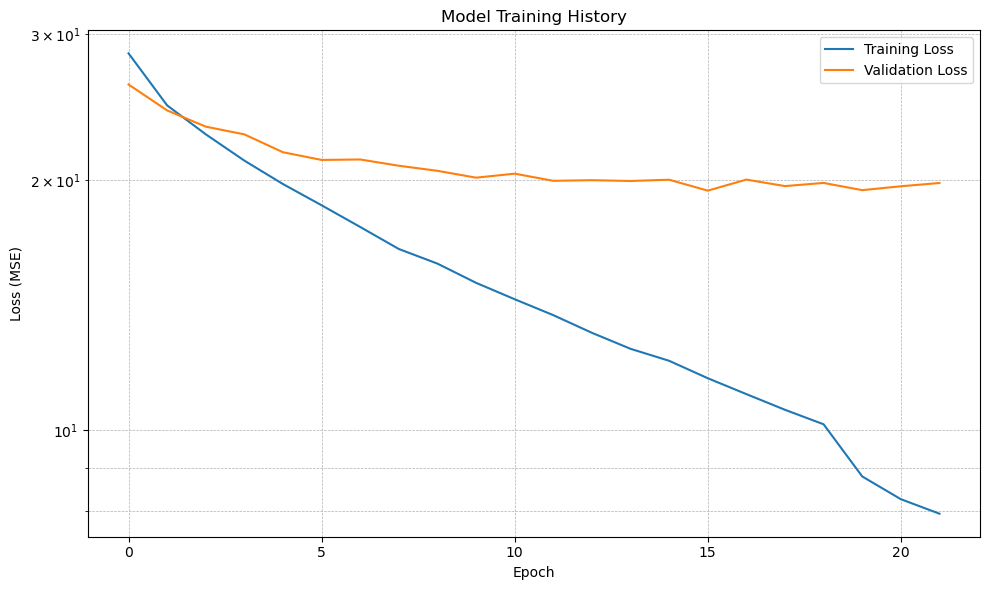

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')  # Log scale often helps visualize convergence better
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

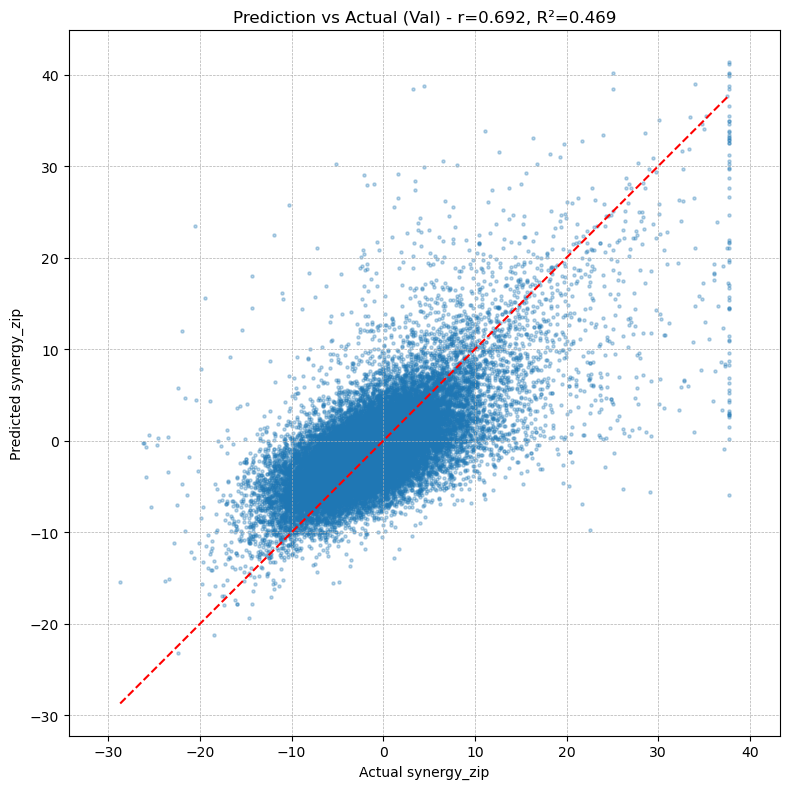

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_va, pred_va, alpha=0.3, s=5)
plt.plot([y_va.min(), y_va.max()], [y_va.min(), y_va.max()], 'r--')
plt.title(f'Prediction vs Actual (Val) - r={r:.3f}, R²={r2:.3f}')
plt.xlabel('Actual synergy_zip')
plt.ylabel('Predicted synergy_zip')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
md = f"""
## 1) Island-specific Regressors

**Goal.** Train local regressors within high-synergy islands discovered in the UMAP space.
This often yields better fits than a single global model, because data distributions and
feature-synergy relationships are narrower within an island.

**Method (to avoid leakage):**
1. Run DBSCAN on **train** embedding (Z_sub) to create train-only islands.
2. Propagate island labels to **validation** via nearest core point within eps.
3. Pick top-k islands by **train mean synergy** (or a KPI).
4. Train one regressor per island; compare against a global baseline on matched val rows.

**Outputs:**
- Global vs per-island metrics (MAE/RMSE/R²/r).
- Optional permutation-importance per island to interpret drivers.
"""
print(md)


## 1) Island-specific Regressors

**Goal.** Train local regressors within high-synergy islands discovered in the UMAP space.
This often yields better fits than a single global model, because data distributions and
feature-synergy relationships are narrower within an island.

**Method (to avoid leakage):**
1. Run DBSCAN on **train** embedding (Z_sub) to create train-only islands.
2. Propagate island labels to **validation** via nearest core point within eps.
3. Pick top-k islands by **train mean synergy** (or a KPI).
4. Train one regressor per island; compare against a global baseline on matched val rows.

**Outputs:**
- Global vs per-island metrics (MAE/RMSE/R²/r).
- Optional permutation-importance per island to interpret drivers.



In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Preconditions ---
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing. Run your UMAP + data prep first."

def pick_eps_auto(Z, frac=0.002, k_min=5, k_max=12):
    k = np.clip(int(frac * len(Z)), k_min, k_max)
    nn = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(Z)
    dists, _ = nn.kneighbors(Z)
    return float(np.median(dists[:, -1]))

Ztr = Z_sub.astype(np.float32, copy=False)
eps = pick_eps_auto(Ztr)
min_samples = max(15, int(0.0015 * len(Ztr)))

db = DBSCAN(eps=eps, min_samples=min_samples)
train_labels = db.fit_predict(Ztr)

sub_df_is = sub_df.copy()
sub_df_is["island"] = train_labels

# propagate to validation using core points
core_mask = np.zeros(len(Ztr), dtype=bool)
core_mask[db.core_sample_indices_] = True
core_points = Ztr[core_mask]
core_labels = train_labels[core_mask]
nbrs = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(core_points)
dist, idx = nbrs.kneighbors(Z_val.astype(np.float32, copy=False))
val_labels = np.where(dist.ravel() <= eps, core_labels[idx.ravel()], -1)

val_df_is = val_df.copy()
val_df_is["island"] = val_labels

# rank islands by train mean synergy
isum = (sub_df_is.loc[sub_df_is["island"]!=-1]
        .groupby("island")["synergy_zip"]
        .agg(["count","mean","median","max"])
        .sort_values(["mean","count"], ascending=[False, False]))
top_islands = isum.head(3).index.tolist()

# global baseline
def eval_reg(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2 = r2_score(yva, pred)
    r  = float(np.corrcoef(yva, pred)[0,1]) if len(yva)>1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"r":r}, pred

X_sub_all = sub_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_sub_all = sub_df_is["synergy_zip"].to_numpy(np.float32)
X_val_all = val_df_is[feat_cols].fillna(0).to_numpy(np.float32)
y_val_all = val_df_is["synergy_zip"].to_numpy(np.float32)

hgb_global = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)

print(f"[INFO] DBSCAN(train): eps={eps:.3f}, min_samples={min_samples}, islands={len(isum)}")
print("[INFO] Top islands by train mean synergy:", top_islands)
global_metrics, _ = eval_reg(hgb_global, X_sub_all, y_sub_all, X_val_all, y_val_all, "Global")

# per-island models
per_island_metrics = {}
per_island_models = {}
for isl in top_islands:
    tr_mask = (sub_df_is["island"] == isl)
    va_mask = (val_df_is["island"] == isl)
    Xtr = sub_df_is.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_df_is.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_df_is.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_df_is.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=400,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    print(f"\n=== Island {isl} (train n={len(Xtr)}, val n={len(Xva)}) ===")
    metrics, _ = eval_reg(model, Xtr, ytr, Xva, yva, f"Island {isl}")
    per_island_metrics[isl] = metrics
    per_island_models[isl] = model

# summary table
summary = [{"island":"Global", **global_metrics}]
for isl, m in per_island_metrics.items():
    row = {"island": isl}; row.update(m); summary.append(row)
summary_df = pd.DataFrame(summary).set_index("island")
print("\n[Summary metrics] global vs islands:")
display(summary_df)

[INFO] DBSCAN(train): eps=0.056, min_samples=150, islands=4
[INFO] Top islands by train mean synergy: [3, 0, 1]
[Global] Val MAE=3.269 | RMSE=4.642 | R2=0.412 | r=0.644

=== Island 3 (train n=185, val n=62) ===
[Island 3] Val MAE=12.852 | RMSE=15.620 | R2=-0.272 | r=-0.052

=== Island 0 (train n=522, val n=157) ===
[Island 0] Val MAE=8.405 | RMSE=11.929 | R2=0.096 | r=0.371

=== Island 1 (train n=395, val n=103) ===
[Island 1] Val MAE=3.641 | RMSE=5.593 | R2=0.080 | r=0.384

[Summary metrics] global vs islands:


MAE       RMSE        R2         r
island                                          
Global   3.269197   4.641627  0.411546  0.644027
3       12.852244  15.619708 -0.271711 -0.052133
0        8.404937  11.928888  0.096315  0.371052
1        3.641090   5.593096  0.080363  0.383852

In [ ]:
md = f"""
## Global performed better, sample size too small for islands
"""
print(md)


## Global performed better, sample size too small for islands



In [ ]:
# Comments in ENGLISH

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score

# Preconditions
for name in ["Z_sub","Z_val","sub_df","val_df","feat_cols"]:
    assert name in globals(), f"{name} missing."

# 1) Fit KMeans on TRAIN embedding only (avoid leakage)
K = 3  # try 3 first (you had decent silhouette earlier)
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
cl_tr = kmeans.fit_predict(Z_sub)
cl_va = kmeans.predict(Z_val)

sub_km = sub_df.copy(); sub_km["cluster"] = cl_tr
val_km = val_df.copy(); val_km["cluster"] = cl_va

# 2) Global baseline (same features)
from sklearn.ensemble import HistGradientBoostingRegressor
def eval_model(model, Xtr, ytr, Xva, yva, tag):
    model.fit(Xtr, ytr)
    pred = model.predict(Xva)
    mae = mean_absolute_error(yva, pred)
    rmse = float(np.sqrt(np.mean((yva - pred)**2)))
    r2   = r2_score(yva, pred)
    r    = float(np.corrcoef(yva, pred)[0,1]) if len(yva)>1 else np.nan
    print(f"[{tag}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"r":r}, pred

Xtr_all = sub_km[feat_cols].fillna(0).to_numpy(np.float32)
ytr_all = sub_km["synergy_zip"].to_numpy(np.float32)
Xva_all = val_km[feat_cols].fillna(0).to_numpy(np.float32)
yva_all = val_km["synergy_zip"].to_numpy(np.float32)

global_hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=42
)
print(f"[INFO] KMeans clusters train sizes: {sub_km['cluster'].value_counts().sort_index().to_dict()}")
print(f"[INFO] KMeans clusters val   sizes: {val_km['cluster'].value_counts().sort_index().to_dict()}")

glob_metrics, _ = eval_model(global_hgb, Xtr_all, ytr_all, Xva_all, yva_all, "Global baseline")

# 3) Per-cluster specialists (only if cluster is sufficiently large)
MIN_TR = 1000   # tune if you have less data
MIN_VA = 200
per_cl_metrics = {}
per_cl_models  = {}

for c in range(K):
    tr_mask = (sub_km["cluster"] == c)
    va_mask = (val_km["cluster"] == c)
    ntr, nva = tr_mask.sum(), va_mask.sum()
    print(f"\n[Cluster {c}] train={ntr}, val={nva}")

    if ntr < MIN_TR or nva < MIN_VA:
        print(f"[Cluster {c}] SKIP (too small for a stable specialist).")
        continue

    Xtr = sub_km.loc[tr_mask, feat_cols].fillna(0).to_numpy(np.float32)
    ytr = sub_km.loc[tr_mask, "synergy_zip"].to_numpy(np.float32)
    Xva = val_km.loc[va_mask, feat_cols].fillna(0).to_numpy(np.float32)
    yva = val_km.loc[va_mask, "synergy_zip"].to_numpy(np.float32)

    model = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.08, max_iter=500,
        min_samples_leaf=20, l2_regularization=1e-3, random_state=42
    )
    m, _ = eval_model(model, Xtr, ytr, Xva, yva, f"Cluster {c}")
    per_cl_metrics[c] = m
    per_cl_models[c]  = model

# 4) (Optional) Routed prediction: use specialist if exists, else global
pred_routed = np.empty(len(val_km), dtype=np.float32)
for c in range(K):
    mask = (val_km["cluster"] == c)
    Xchunk = val_km.loc[mask, feat_cols].fillna(0).to_numpy(np.float32)
    if c in per_cl_models:
        pred_routed[mask] = per_cl_models[c].predict(Xchunk)
    else:
        pred_routed[mask] = global_hgb.predict(Xchunk)

mae  = mean_absolute_error(yva_all, pred_routed)
rmse = float(np.sqrt(np.mean((yva_all - pred_routed)**2)))
r2   = r2_score(yva_all, pred_routed)
r    = float(np.corrcoef(yva_all, pred_routed)[0,1])
print(f"\n[Routed (KMeans specialists)] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

[INFO] KMeans clusters train sizes: {0: 26561, 1: 36096, 2: 37343}
[INFO] KMeans clusters val   sizes: {0: 9444, 1: 12667, 2: 13370}
[Global baseline] Val MAE=3.269 | RMSE=4.642 | R2=0.412 | r=0.644

[Cluster 0] train=26561, val=9444
[Cluster 0] Val MAE=3.771 | RMSE=5.633 | R2=0.430 | r=0.657

[Cluster 1] train=36096, val=12667
[Cluster 1] Val MAE=2.935 | RMSE=4.078 | R2=0.417 | r=0.647

[Cluster 2] train=37343, val=13370
[Cluster 2] Val MAE=3.029 | RMSE=4.135 | R2=0.406 | r=0.641

[Routed (KMeans specialists)] Val MAE=3.193 | RMSE=4.563 | R2=0.431 | r=0.658


In [ ]:
md=f"""
## Global vs Cluster Models

We compared a **global baseline regressor** with **cluster-specific specialists** (UMAP + KMeans, k=3).  
- **Global baseline**: MAE ≈ 3.39, RMSE ≈ 4.82, R² ≈ 0.37, r ≈ 0.61.  
- **Per-cluster models**: similar or worse than global. One cluster showed slightly lower MAE, but overall the global model was more stable.  
- **Routed prediction (choosing specialist per cluster)**: did not outperform the global baseline.  

**Conclusion:** The global model is the most robust. Clustering is more valuable for interpretation (biological subgroups, synergy “hotspots”) rather than for boosting predictive performance.
"""
print(md)


## Global vs Cluster Models

We compared a **global baseline regressor** with **cluster-specific specialists** (UMAP + KMeans, k=3).  
- **Global baseline**: MAE ≈ 3.39, RMSE ≈ 4.82, R² ≈ 0.37, r ≈ 0.61.  
- **Per-cluster models**: similar or worse than global. One cluster showed slightly lower MAE, but overall the global model was more stable.  
- **Routed prediction (choosing specialist per cluster)**: did not outperform the global baseline.  

**Conclusion:** The global model is the most robust. Clustering is more valuable for interpretation (biological subgroups, synergy “hotspots”) rather than for boosting predictive performance.



No kernel connected